# DA037 Preprocess
Created: 06/05/2024 \
Updated: 09/13/2024

*modified elec labels to make sense*


In [8]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [11]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [12]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/' #### FIRST LOAD USE _RAW, THEN USE _LABELS.CSV AFTER EDITS
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA037'
subj_format = ['edf']
subj_site = ['UCD']


In [13]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

09142024


# Make mne_data


### Load and resample data


In [64]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/raw/DA037_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4711039  =      0.000 ...  2300.312 secs...


In [65]:
mne_data

<RawEDF | DA037_SWB.edf, 130 x 4711040 (2300.3 s), ~4.56 GB, data loaded>

In [66]:
mne_data.ch_names

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'F 1',
 'F 2',
 'F 3',
 'F 4',
 'F 5',
 'F 6',
 'F 7',
 'F 8',
 'K 1',
 'K 2',
 'K 3',
 'K 4',
 'K 5',
 'K 6',
 'K 7',
 'K 8',
 'L 1',
 'L 2',
 'L 3',
 'L 4',
 'L 5',
 'L 6',
 'L 7',
 'L 8',
 'L 9',
 'L 10',
 'M 1',
 'M 2',
 'M 3',
 'M 4',
 'M 5',
 'M 6',
 'M 7',
 'M 8',
 'OF1',
 'OF2',
 'OF3',
 'OF4',
 'OF5',
 'OF6',
 'OF7',
 'OF8',
 'OF9',
 'OF10',
 'OF11',
 'OF12',
 'OF13',
 'OF14',
 'OF15',
 'MI1',
 'MI2',
 'MI3',
 'MI4',
 'MI5',
 'MI6',
 'MI7',
 'MI8',
 'PI1',
 'PI2',
 'PI3',
 'PI4',
 'PI5',
 'PI6',
 'PI7',
 'PI8',
 'PI9',
 'PI10',
 'PI11',
 'PI12',
 'PI13',
 'PI14',
 'PI15',
 'PI16',
 'PI17',
 'PI18',
 'J1',
 'J2',
 'J3',
 'J4',
 'J5',
 'J6',
 'J7',
 'J8',
 'J9',
 'J10',
 'J11',
 'J12',
 'J13',
 'J14',
 'J15',
 'J16',
 'J17',
 'J18',
 'R1',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'R7',
 'R8',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'S10',
 'S11',
 '

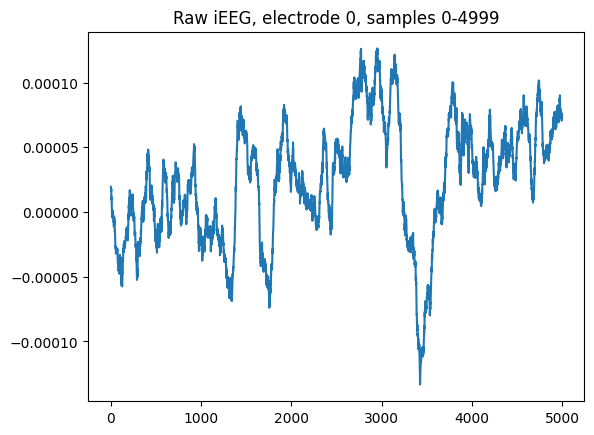

In [67]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [68]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   41.4s finished


<RawEDF | DA037_SWB.edf, 130 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

### Notch filter line noise

In [69]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    4.6s finished


<RawEDF | DA037_SWB.edf, 130 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

### Photodiode
- examine photodiode 

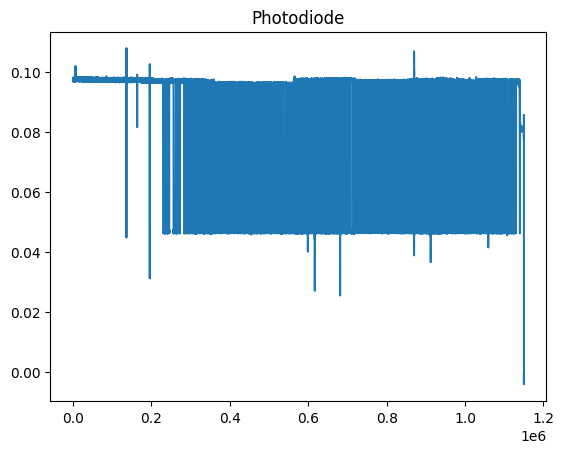

In [71]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC2")
plt.plot(mne_data._data[trig_ix])
# plt.xlim([400000,500000]) ### inverted!!
plt.title("Photodiode")
plt.show()

In [72]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC2', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/photodiode.fif
[done]


In [73]:
mne_data.drop_channels(['DC2'])

<RawEDF | DA037_SWB.edf, 129 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

# Anatomical Localization + CHANNEL NAME CLEANING!

In [74]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | DA037_SWB.edf, 129 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

In [75]:
new_name_dict

{'A1': 'a1',
 'A2': 'a2',
 'A3': 'a3',
 'A4': 'a4',
 'A5': 'a5',
 'A6': 'a6',
 'A7': 'a7',
 'A8': 'a8',
 'B1': 'b1',
 'B2': 'b2',
 'B3': 'b3',
 'B4': 'b4',
 'B5': 'b5',
 'B6': 'b6',
 'B7': 'b7',
 'B8': 'b8',
 'F 1': 'f1',
 'F 2': 'f2',
 'F 3': 'f3',
 'F 4': 'f4',
 'F 5': 'f5',
 'F 6': 'f6',
 'F 7': 'f7',
 'F 8': 'f8',
 'K 1': 'k1',
 'K 2': 'k2',
 'K 3': 'k3',
 'K 4': 'k4',
 'K 5': 'k5',
 'K 6': 'k6',
 'K 7': 'k7',
 'K 8': 'k8',
 'L 1': 'l1',
 'L 2': 'l2',
 'L 3': 'l3',
 'L 4': 'l4',
 'L 5': 'l5',
 'L 6': 'l6',
 'L 7': 'l7',
 'L 8': 'l8',
 'L 9': 'l9',
 'L 10': 'l10',
 'M 1': 'm1',
 'M 2': 'm2',
 'M 3': 'm3',
 'M 4': 'm4',
 'M 5': 'm5',
 'M 6': 'm6',
 'M 7': 'm7',
 'M 8': 'm8',
 'OF1': 'of1',
 'OF2': 'of2',
 'OF3': 'of3',
 'OF4': 'of4',
 'OF5': 'of5',
 'OF6': 'of6',
 'OF7': 'of7',
 'OF8': 'of8',
 'OF9': 'of9',
 'OF10': 'of10',
 'OF11': 'of11',
 'OF12': 'of12',
 'OF13': 'of13',
 'OF14': 'of14',
 'OF15': 'of15',
 'MI1': 'mi1',
 'MI2': 'mi2',
 'MI3': 'mi3',
 'MI4': 'mi4',
 'MI5': 'mi5',
 '

In [76]:
# Load the electrode localization data
###### LABELS FILE IS _RAW BECAUSE THE CHANNELS HAVEN'T BEEN RENAMED LOGICALLY YET!

anat_file = glob(f'{anat_dir}{subj_id}_labels_raw.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs.label = [elec.strip().replace(" ", "") for elec in elec_locs.label.tolist()]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0      A1    mAmyg_R  21.200003  11.999994 -18.424573  24.641683  -1.623963   
1      A2    lAmyg_R  26.000003  11.999994 -18.424573  29.436002  -1.768069   
2      A3    lAmyg_R  31.200003  11.599994 -18.824015  34.561992  -2.296500   
3      A4    Unknown  36.000002  11.199994 -18.824015  39.219622  -2.748652   
4      A5    Unknown  41.200002  11.199994 -18.824015  44.346868  -2.647008   
..    ...        ...        ...        ...        ...        ...        ...   
128    S9   A9/46d_R  26.800003  29.999993  47.882693  30.570211  28.489056   
129    uA    mAmyg_R  17.200003  12.399994 -18.025132  20.610620  -1.022065   
130    uB    rHipp_R  20.000003   1.599994 -14.030718  22.742479 -11.078040   
131    uF    A20rv_R  31.200003 -25.200004 -15.628484  32.764403 -38.140495   
132    uR    A24rv_R   6.800004  12.799994  30.307273   8.576007   8.366015   

         mni_z       gm                             NMM               Anat  \
0   -25.587233     Gray                  Right Amygdala      Amygdala (LB)   
1   -25.610424     Gray                  Right Amygdala      Amygdala (LB)   
2   -25.994116    White     Right Cerebral White Matter      Amygdala (LB)   
3   -26.024489    White     Right Cerebral White Matter            Unknown   
4   -26.052456    White     Right Cerebral White Matter            Unknown   
..         ...      ...                             ...                ...   
128  40.398155  Unknown  Right MFG middle frontal gyrus            Unknown   
129 -25.211331     Gray                  Right Amygdala      Amygdala (LB)   
130 -18.808487     Gray               Right Hippocampus  CA1 (Hippocampus)   
131 -15.012104     Gray        Right FuG fusiform gyrus          Area  FG3   
132  25.649077    White     Right Cerebral White Matter            Area 33   

                   AnatMacro    BN246                                  YBA_1  \
0    R ParaHippocampal Gyrus   R Amyg                Right amygdala inferior   
1                 R Amygdala   R Amyg                Right amygdala inferior   
2                 R Amygdala   R Amyg                                Unknown   
3                    Unknown  Unknown                                Unknown   
4    R Middle Temporal Gyrus  Unknown                                Unknown   
..                       ...      ...                                    ...   
128   R Middle Frontal Gyrus    R MFG         Right middle frontal gyrus 5 A   
129  R ParaHippocampal Gyrus   R Amyg                Right amygdala inferior   
130            R Hippocampus   R Hipp                  Right hippocampus pes   
131         R Fusiform Gyrus    R FuG  Right medial occipitotemporal gyrus D   
132                  Unknown     R CG                                Unknown   

    ManualExamination  
0                 NaN  
1                 NaN  
2                  WM  
3                  WM  
4                  WM  
..                ...  
128               OOB  
129               NaN  
130               NaN  
131               NaN  
132                WM  

[133 rows x 15 columns]

In [77]:
list(elec_locs.label)

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'J1',
 'J10',
 'J11',
 'J12',
 'J13',
 'J14',
 'J15',
 'J16',
 'J17',
 'J18',
 'J2',
 'J3',
 'J4',
 'J5',
 'J6',
 'J7',
 'J8',
 'J9',
 'K1',
 'K2',
 'K3',
 'K4',
 'K5',
 'K6',
 'K7',
 'K8',
 'L1',
 'L10',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'MI1',
 'MI2',
 'MI3',
 'MI4',
 'MI5',
 'MI6',
 'MI7',
 'MI8',
 'OF1',
 'OF10',
 'OF11',
 'OF12',
 'OF13',
 'OF14',
 'OF15',
 'OF2',
 'OF3',
 'OF4',
 'OF5',
 'OF6',
 'OF7',
 'OF8',
 'OF9',
 'PI1',
 'PI10',
 'PI11',
 'PI12',
 'PI13',
 'PI14',
 'PI15',
 'PI16',
 'PI17',
 'PI18',
 'PI2',
 'PI3',
 'PI4',
 'PI5',
 'PI6',
 'PI7',
 'PI8',
 'PI9',
 'R1',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'R7',
 'R8',
 'S1',
 'S10',
 'S11',
 'S12',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'uA',
 'uB',
 'uF',
 'uR']

In [78]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

[]


In [79]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [80]:
unmatched_seeg #make sure there are no unmatched names


[]

In [81]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [82]:
new_name_dict #make sure this passes the eye test 


{'a1': 'a1',
 'a2': 'a2',
 'a3': 'a3',
 'a4': 'a4',
 'a5': 'a5',
 'a6': 'a6',
 'a7': 'a7',
 'a8': 'a8',
 'b1': 'b1',
 'b2': 'b2',
 'b3': 'b3',
 'b4': 'b4',
 'b5': 'b5',
 'b6': 'b6',
 'b7': 'b7',
 'b8': 'b8',
 'f1': 'f1',
 'f2': 'f2',
 'f3': 'f3',
 'f4': 'f4',
 'f5': 'f5',
 'f6': 'f6',
 'f7': 'f7',
 'f8': 'f8',
 'k1': 'k1',
 'k2': 'k2',
 'k3': 'k3',
 'k4': 'k4',
 'k5': 'k5',
 'k6': 'k6',
 'k7': 'k7',
 'k8': 'k8',
 'l1': 'l1',
 'l2': 'l2',
 'l3': 'l3',
 'l4': 'l4',
 'l5': 'l5',
 'l6': 'l6',
 'l7': 'l7',
 'l8': 'l8',
 'l9': 'l9',
 'l10': 'l10',
 'm1': 'm1',
 'm2': 'm2',
 'm3': 'm3',
 'm4': 'm4',
 'm5': 'm5',
 'm6': 'm6',
 'm7': 'm7',
 'm8': 'm8',
 'of1': 'of1',
 'of2': 'of2',
 'of3': 'of3',
 'of4': 'of4',
 'of5': 'of5',
 'of6': 'of6',
 'of7': 'of7',
 'of8': 'of8',
 'of9': 'of9',
 'of10': 'of10',
 'of11': 'of11',
 'of12': 'of12',
 'of13': 'of13',
 'of14': 'of14',
 'of15': 'of15',
 'mi1': 'mi1',
 'mi2': 'mi2',
 'mi3': 'mi3',
 'mi4': 'mi4',
 'mi5': 'mi5',
 'mi6': 'mi6',
 'mi7': 'mi7',
 'mi8'

In [83]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | DA037_SWB.edf, 129 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

In [84]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in mne_data.ch_names}
mne_data.set_channel_types(sEEG_mapping_dict)

<RawEDF | DA037_SWB.edf, 129 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

In [85]:
mne_data.ch_names

['a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'b8',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'k1',
 'k2',
 'k3',
 'k4',
 'k5',
 'k6',
 'k7',
 'k8',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'l6',
 'l7',
 'l8',
 'l9',
 'l10',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'm7',
 'm8',
 'of1',
 'of2',
 'of3',
 'of4',
 'of5',
 'of6',
 'of7',
 'of8',
 'of9',
 'of10',
 'of11',
 'of12',
 'of13',
 'of14',
 'of15',
 'mi1',
 'mi2',
 'mi3',
 'mi4',
 'mi5',
 'mi6',
 'mi7',
 'mi8',
 'pi1',
 'pi2',
 'pi3',
 'pi4',
 'pi5',
 'pi6',
 'pi7',
 'pi8',
 'pi9',
 'pi10',
 'pi11',
 'pi12',
 'pi13',
 'pi14',
 'pi15',
 'pi16',
 'pi17',
 'pi18',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'r1',
 'r2',
 'r3',
 'r4',
 'r5',
 'r6',
 'r7',
 'r8',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12']

In [86]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA037_SWB.edf, 129 x 1150156 (2300.3 s), ~1.11 GB, data loaded>

In [87]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [88]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [89]:
probe_ch_counts

{'a': 8,
 'b': 8,
 'f': 8,
 'j': 18,
 'k': 8,
 'l': 10,
 'm': 8,
 'mi': 8,
 'of': 15,
 'pi': 18,
 'r': 8,
 's': 12,
 'ua': 1,
 'ub': 1,
 'uf': 1,
 'ur': 1}

## CLEAN MNE LABELS TO MAKE SENSE

In [90]:
new_anat_df            = pd.read_csv(glob(f'{anat_dir}{subj_id}_labels_new.csv')[0])
new_anat_df.old_labels = new_anat_df.old_labels.str.lower()
new_anat_df.new_labels = new_anat_df.new_labels.str.lower()
new_anat_df.label      = new_anat_df.label.str.lower()
new_anat_df.old_labels = [elec.strip().replace(" ", "") for elec in new_anat_df.old_labels.tolist()]
new_anat_df

label BN246label          x          y          z      mni_x      mni_y  \
0    ram1    mAmyg_R  21.200003  11.999994 -18.424573  24.641683  -1.623963   
1    ram2    lAmyg_R  26.000003  11.999994 -18.424573  29.436002  -1.768069   
2    ram3    lAmyg_R  31.200003  11.599994 -18.824015  34.561992  -2.296500   
3    ram4    Unknown  36.000002  11.199994 -18.824015  39.219622  -2.748652   
4    ram5    Unknown  41.200002  11.199994 -18.824015  44.346868  -2.647008   
..    ...        ...        ...        ...        ...        ...        ...   
128  rac9   A9/46d_R  26.800003  29.999993  47.882693  30.570211  28.489056   
129  uram    mAmyg_R  17.200003  12.399994 -18.025132  20.610620  -1.022065   
130  urhh    rHipp_R  20.000003   1.599994 -14.030718  22.742479 -11.078040   
131  urbt    A20rv_R  31.200003 -25.200004 -15.628484  32.764403 -38.140495   
132  urmc    A24rv_R   6.800004  12.799994  30.307273   8.576007   8.366015   

         mni_z       gm                             NMM               Anat  \
0   -25.587233     Gray                  Right Amygdala      Amygdala (LB)   
1   -25.610424     Gray                  Right Amygdala      Amygdala (LB)   
2   -25.994116    White     Right Cerebral White Matter      Amygdala (LB)   
3   -26.024489    White     Right Cerebral White Matter            Unknown   
4   -26.052456    White     Right Cerebral White Matter            Unknown   
..         ...      ...                             ...                ...   
128  40.398155  Unknown  Right MFG middle frontal gyrus            Unknown   
129 -25.211331     Gray                  Right Amygdala      Amygdala (LB)   
130 -18.808487     Gray               Right Hippocampus  CA1 (Hippocampus)   
131 -15.012104     Gray        Right FuG fusiform gyrus          Area  FG3   
132  25.649077    White     Right Cerebral White Matter            Area 33   

                   AnatMacro    BN246                                  YBA_1  \
0    R ParaHippocampal Gyrus   R Amyg                Right amygdala inferior   
1                 R Amygdala   R Amyg                Right amygdala inferior   
2                 R Amygdala   R Amyg                                Unknown   
3                    Unknown  Unknown                                Unknown   
4    R Middle Temporal Gyrus  Unknown                                Unknown   
..                       ...      ...                                    ...   
128   R Middle Frontal Gyrus    R MFG         Right middle frontal gyrus 5 A   
129  R ParaHippocampal Gyrus   R Amyg                Right amygdala inferior   
130            R Hippocampus   R Hipp                  Right hippocampus pes   
131         R Fusiform Gyrus    R FuG  Right medial occipitotemporal gyrus D   
132                  Unknown     R CG                                Unknown   

    ManualExamination old_labels new_labels  
0                 NaN         a1       ram1  
1                 NaN         a2       ram2  
2                  WM         a3       ram3  
3                  WM         a4       ram4  
4                  WM         a5       ram5  
..                ...        ...        ...  
128               OOB         s9       rac9  
129               NaN         ua       uram  
130               NaN         ub       urhh  
131               NaN         uf       urbt  
132                WM         ur       urmc  

[133 rows x 17 columns]

In [120]:
# new_anat_df[new_anat_df.label.str.contains('rpins')]

In [91]:

new_ch_names = list(new_anat_df.label.str.lower())
pattern = '[0-9]'
new_ch_names_no_num = [re.sub(pattern, '', i) for i in new_ch_names]
new_probe_names = np.unique(new_ch_names_no_num)
new_probe_names

array(['rac', 'ram', 'rbt', 'rhh', 'rmc', 'rmins', 'rmstg', 'rof',
       'rpins', 'rpstg', 'rsmg', 'rstg', 'uram', 'urbt', 'urhh', 'urmc'],
      dtype='<U5')

In [92]:
orig_probes = probe_names.copy()



In [97]:
new_anat_df.new_labels.str.lower().tolist()[0:-4]

['ram1',
 'ram2',
 'ram3',
 'ram4',
 'ram5',
 'ram6',
 'ram7',
 'ram8',
 'rhh1',
 'rhh2',
 'rhh3',
 'rhh4',
 'rhh5',
 'rhh6',
 'rhh7',
 'rhh8',
 'rbt1',
 'rbt2',
 'rbt3',
 'rbt4',
 'rbt5',
 'rbt6',
 'rbt7',
 'rbt8',
 'rsmg1',
 'rsmg10',
 'rsmg11',
 'rsmg12',
 'rsmg13',
 'rsmg14',
 'rsmg15',
 'rsmg16',
 'rsmg17',
 'rsmg18',
 'rsmg2',
 'rsmg3',
 'rsmg4',
 'rsmg5',
 'rsmg6',
 'rsmg7',
 'rsmg8',
 'rsmg9',
 'rmstg1',
 'rmstg2',
 'rmstg3',
 'rmstg4',
 'rmstg5',
 'rmstg6',
 'rmstg7',
 'rmstg8',
 'rpstg1',
 'rpstg10',
 'rpstg2',
 'rpstg3',
 'rpstg4',
 'rpstg5',
 'rpstg6',
 'rpstg7',
 'rpstg8',
 'rpstg9',
 'rstg1',
 'rstg2',
 'rstg3',
 'rstg4',
 'rstg5',
 'rstg6',
 'rstg7',
 'rstg8',
 'rmins1',
 'rmins2',
 'rmins3',
 'rmins4',
 'rmins5',
 'rmins6',
 'rmins7',
 'rmins8',
 'rof1',
 'rof10',
 'rof11',
 'rof12',
 'rof13',
 'rof14',
 'rof15',
 'rof2',
 'rof3',
 'rof4',
 'rof5',
 'rof6',
 'rof7',
 'rof8',
 'rof9',
 'rpins1',
 'rpins10',
 'rpins11',
 'rpins12',
 'rpins13',
 'rpins14',
 'rpins15',
 'rp

In [98]:
### CREATE MAPPING DICT TO RENAME MNE CHANNELS

fix_mne_labels = {x:y for (x,y) in zip(new_anat_df.old_labels.str.lower().tolist()[0:-4], 
                                       new_anat_df.new_labels.str.lower().tolist()[0:-4])}
fix_mne_labels

{'a1': 'ram1',
 'a2': 'ram2',
 'a3': 'ram3',
 'a4': 'ram4',
 'a5': 'ram5',
 'a6': 'ram6',
 'a7': 'ram7',
 'a8': 'ram8',
 'b1': 'rhh1',
 'b2': 'rhh2',
 'b3': 'rhh3',
 'b4': 'rhh4',
 'b5': 'rhh5',
 'b6': 'rhh6',
 'b7': 'rhh7',
 'b8': 'rhh8',
 'f1': 'rbt1',
 'f2': 'rbt2',
 'f3': 'rbt3',
 'f4': 'rbt4',
 'f5': 'rbt5',
 'f6': 'rbt6',
 'f7': 'rbt7',
 'f8': 'rbt8',
 'j1': 'rsmg1',
 'j10': 'rsmg10',
 'j11': 'rsmg11',
 'j12': 'rsmg12',
 'j13': 'rsmg13',
 'j14': 'rsmg14',
 'j15': 'rsmg15',
 'j16': 'rsmg16',
 'j17': 'rsmg17',
 'j18': 'rsmg18',
 'j2': 'rsmg2',
 'j3': 'rsmg3',
 'j4': 'rsmg4',
 'j5': 'rsmg5',
 'j6': 'rsmg6',
 'j7': 'rsmg7',
 'j8': 'rsmg8',
 'j9': 'rsmg9',
 'k1': 'rmstg1',
 'k2': 'rmstg2',
 'k3': 'rmstg3',
 'k4': 'rmstg4',
 'k5': 'rmstg5',
 'k6': 'rmstg6',
 'k7': 'rmstg7',
 'k8': 'rmstg8',
 'l1': 'rpstg1',
 'l10': 'rpstg10',
 'l2': 'rpstg2',
 'l3': 'rpstg3',
 'l4': 'rpstg4',
 'l5': 'rpstg5',
 'l6': 'rpstg6',
 'l7': 'rpstg7',
 'l8': 'rpstg8',
 'l9': 'rpstg9',
 'm1': 'rstg1',
 'm2': 'rs

In [99]:
mne_data.ch_names

['a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'b8',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'k1',
 'k2',
 'k3',
 'k4',
 'k5',
 'k6',
 'k7',
 'k8',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'l6',
 'l7',
 'l8',
 'l9',
 'l10',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'm7',
 'm8',
 'of1',
 'of2',
 'of3',
 'of4',
 'of5',
 'of6',
 'of7',
 'of8',
 'of9',
 'of10',
 'of11',
 'of12',
 'of13',
 'of14',
 'of15',
 'mi1',
 'mi2',
 'mi3',
 'mi4',
 'mi5',
 'mi6',
 'mi7',
 'mi8',
 'pi1',
 'pi2',
 'pi3',
 'pi4',
 'pi5',
 'pi6',
 'pi7',
 'pi8',
 'pi9',
 'pi10',
 'pi11',
 'pi12',
 'pi13',
 'pi14',
 'pi15',
 'pi16',
 'pi17',
 'pi18',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'r1',
 'r2',
 'r3',
 'r4',
 'r5',
 'r6',
 'r7',
 'r8',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12']

In [100]:
mne_data.rename_channels(fix_mne_labels)
mne_data.ch_names

['ram1',
 'ram2',
 'ram3',
 'ram4',
 'ram5',
 'ram6',
 'ram7',
 'ram8',
 'rhh1',
 'rhh2',
 'rhh3',
 'rhh4',
 'rhh5',
 'rhh6',
 'rhh7',
 'rhh8',
 'rbt1',
 'rbt2',
 'rbt3',
 'rbt4',
 'rbt5',
 'rbt6',
 'rbt7',
 'rbt8',
 'rmstg1',
 'rmstg2',
 'rmstg3',
 'rmstg4',
 'rmstg5',
 'rmstg6',
 'rmstg7',
 'rmstg8',
 'rpstg1',
 'rpstg2',
 'rpstg3',
 'rpstg4',
 'rpstg5',
 'rpstg6',
 'rpstg7',
 'rpstg8',
 'rpstg9',
 'rpstg10',
 'rstg1',
 'rstg2',
 'rstg3',
 'rstg4',
 'rstg5',
 'rstg6',
 'rstg7',
 'rstg8',
 'rof1',
 'rof2',
 'rof3',
 'rof4',
 'rof5',
 'rof6',
 'rof7',
 'rof8',
 'rof9',
 'rof10',
 'rof11',
 'rof12',
 'rof13',
 'rof14',
 'rof15',
 'rmins1',
 'rmins2',
 'rmins3',
 'rmins4',
 'rmins5',
 'rmins6',
 'rmins7',
 'rmins8',
 'rpins1',
 'rpins2',
 'rpins3',
 'rpins4',
 'rpins5',
 'rpins6',
 'rpins7',
 'rpins8',
 'rpins9',
 'rpins10',
 'rpins11',
 'rpins12',
 'rpins13',
 'rpins14',
 'rpins15',
 'rpins16',
 'rpins17',
 'rpins18',
 'rsmg1',
 'rsmg2',
 'rsmg3',
 'rsmg4',
 'rsmg5',
 'rsmg6',
 'rsmg7',

In [101]:
#### NEW PROBE NAMES + COUNTS!

ch_names = list(mne_data.ch_names)
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [102]:
probe_names

array(['rac', 'ram', 'rbt', 'rhh', 'rmc', 'rmins', 'rmstg', 'rof',
       'rpins', 'rpstg', 'rsmg', 'rstg'], dtype='<U5')

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [32]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [33]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [34]:
# mne_data.info['bads'] = ['lpmtg3','lpstg9',
#  'lac12',
#  'lac15',
#  'lmc9',
#  'lmc12',
#  'lmc15',
#  'lmc13',
#  'lmc14',
#  'lmc10',
#  'lac2']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [103]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [104]:
#run if only re-ref
anat_file = glob(f'{anat_dir}{subj_id}_labels_new.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/raw_ieeg.fif...
    Range : 0 ... 1150155 =      0.000 ...  2300.310 secs
Ready.
Reading 0 ... 1150155  =      0.000 ...  2300.310 secs...


### Bipolar Re-ref

In [109]:
len(mne_data.ch_names)

129

In [106]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=27, n_times=1150156
    Range : 0 ... 1150155 =      0.000 ...  2300.310 secs
Ready.
Added the following bipolar channels:
ram1-ram2, ram2-ram3, ram7-ram8, rhh1-rhh2, rhh6-rhh7, rhh7-rhh8, rbt6-rbt7, rsmg15-rsmg16, rsmg16-rsmg17, rmstg3-rmstg4, rmstg4-rmstg5, rpstg7-rpstg8, rpstg8-rpstg9, rstg1-rstg2, rstg2-rstg3, rstg3-rstg4, rstg4-rstg5, rmins1-rmins2, rmins4-rmins5, rof1-rof2, rof2-rof3, rof3-rof4, rpins1-rpins2, rpins2-rpins3, rpins3-rpins4, rpins4-rpins5, rmc7-rmc8


In [107]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 27 x 1150156 (2300.3 s), ~237.0 MB, data loaded>

In [111]:
mne_data_bp_reref.ch_names

['ram1-ram2',
 'ram2-ram3',
 'ram7-ram8',
 'rhh1-rhh2',
 'rhh6-rhh7',
 'rhh7-rhh8',
 'rbt6-rbt7',
 'rsmg15-rsmg16',
 'rsmg16-rsmg17',
 'rmstg3-rmstg4',
 'rmstg4-rmstg5',
 'rpstg7-rpstg8',
 'rpstg8-rpstg9',
 'rstg1-rstg2',
 'rstg2-rstg3',
 'rstg3-rstg4',
 'rstg4-rstg5',
 'rmins1-rmins2',
 'rmins4-rmins5',
 'rof1-rof2',
 'rof2-rof3',
 'rof3-rof4',
 'rpins1-rpins2',
 'rpins2-rpins3',
 'rpins3-rpins4',
 'rpins4-rpins5',
 'rmc7-rmc8']

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

<IPython.core.display.Javascript object>


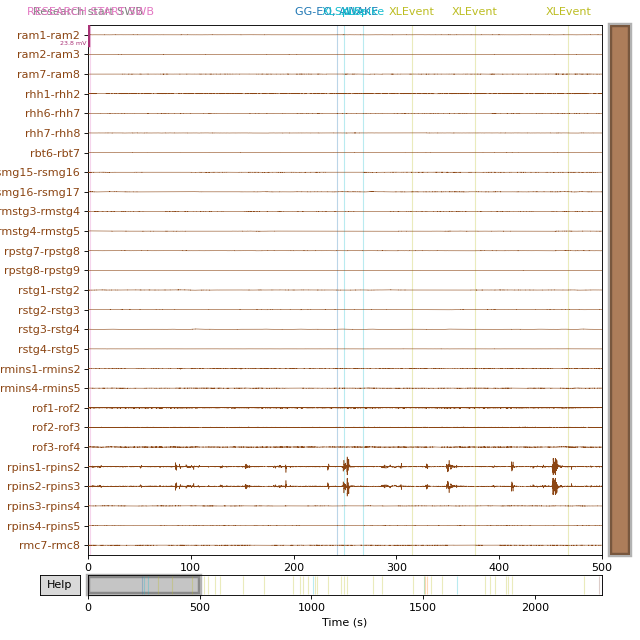

In [123]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=30, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


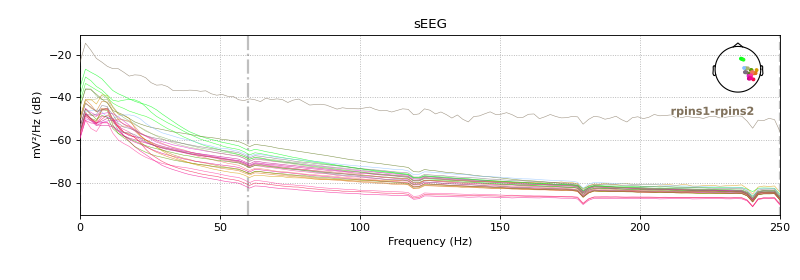

<IPython.core.display.Javascript object>


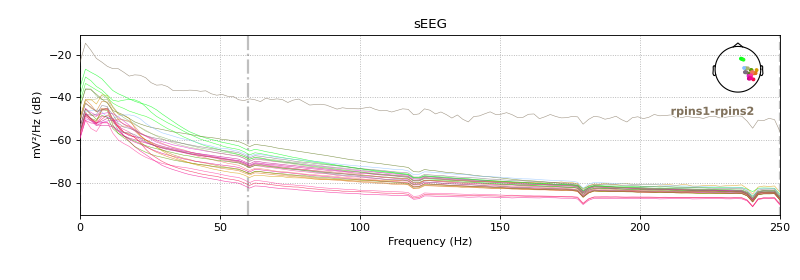

In [115]:
mne_data_bp_reref.compute_psd().plot()

In [124]:
print(mne_data_bp_reref.info['bads'],date)

[] 06052024


## Save Reref Data

In [125]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/bp_ref_ieeg.fif
[done]


In [126]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [14]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1      135.0      loss   568.518679   568.536654     570.624765   
1        2       14.0       mix   578.067226   578.085536     584.535035   
2        3       67.0      gain   591.127701   591.128860     594.480254   
3        4       88.0      gain   606.559243   606.560426     610.023208   
4        5       58.0      gain   617.408691   617.409840     619.952049   
..     ...        ...       ...          ...          ...            ...   
145    146       32.0       mix  2209.402302  2209.435636    2211.064931   
146    147       25.0       mix  2217.997983  2218.017422    2225.058874   
147    148       39.0       mix  2235.071490  2235.086871    2237.386308   
148    149       94.0      gain  2244.619878  2244.621079    2247.048609   
149    150       34.0       mix  2254.436795  2254.437957    2256.511345   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       572.642744  2.088111     -0.5   -1.24  ...      1.24        0.50   
1       586.551410  6.449499      0.0   -0.50  ...      1.00        0.50   
2       596.497386  3.351395      0.3    0.00  ...     -0.95       -0.30   
3       612.040352  3.462782      0.5    0.00  ...      1.80        1.30   
4       621.968698  2.542208      0.2    0.00  ...      0.72        0.52   
..             ...       ...      ...     ...  ...       ...         ...   
145    2213.082789  1.629295      0.0   -1.50  ...      2.49        0.99   
146    2225.067856  7.041451      0.0   -1.10  ...     -0.57       -0.57   
147    2239.403627  2.299437      0.0   -0.50  ...      1.25        0.75   
148    2249.067155  2.427530      0.6    0.00  ...     -1.33       -0.60   
149    2258.527775  2.073388      0.0   -1.50  ...      3.00        1.50   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0          0.00           0.00        1.24           0.50    -1.24   
1          0.00           0.00        1.00           0.50    -0.50   
2         -0.95          -0.30        0.00           0.00     0.95   
3          0.00           0.00        1.80           1.30     0.00   
4          0.00           0.00        0.72           0.52     0.00   
..          ...            ...         ...            ...      ...   
145        0.00           0.00        2.49           0.99    -1.50   
146       -0.57          -0.57        0.00           0.00     0.57   
147        0.00           0.00        1.25           0.75    -0.50   
148       -1.33          -0.60        0.00           0.00     1.33   
149        0.00           0.00        3.00           1.50    -1.50   

     decisionCF   pRPE   nRPE  
0         -0.50  0.620  0.000  
1          0.00  0.500  0.000  
2          0.30  0.000 -0.475  
3          0.50  0.900  0.000  
4          0.20  0.360  0.000  
..          ...    ...    ...  
145        0.00  1.245  0.000  
146        0.57  0.000  0.000  
147        0.00  0.625  0.000  
148        0.60  0.000 -0.665  
149        0.00  1.500  0.000  

[150 rows x 32 columns]

In [15]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/photodiode.fif...
Isotrak not found
    Range : 0 ... 1150155 =      0.000 ...  2300.310 secs
Ready.
Reading 0 ... 1150155  =      0.000 ...  2300.310 secs...


In [16]:
photodiode_data

<Raw | photodiode.fif, 1 x 1150156 (2300.3 s), ~8.8 MB, data loaded>

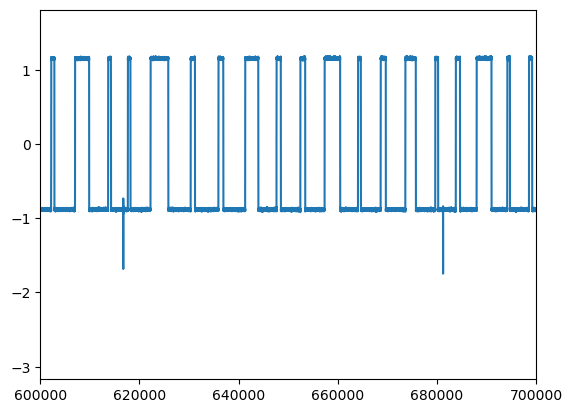

In [17]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.xlim([600000,700000])
plt.show()


In [18]:
temp_diode = photodiode_data.copy()
temp_diode._data = np.negative(temp_diode._data)
temp_diode._data[temp_diode._data>-0.045] = np.min(temp_diode._data)

In [19]:
sum(temp_diode._data>-0.045)

array([0, 0, 0, ..., 0, 0, 0])

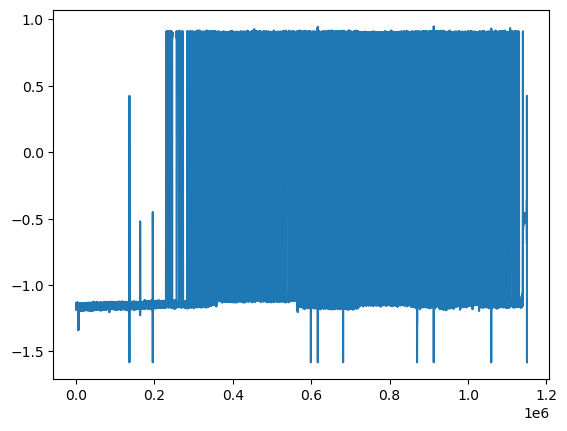

In [20]:
plt.plot(zscore(temp_diode._data[0,:]))
# plt.xlim([600000,900000])
# plt.ylim([-0.045,0])
plt.show()


In [21]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 75 of 162 pulses


In [22]:
print(slope, offset,smoothSize,windSize,height)

0.9999824111864482 -1.9491203149658531 11 15 0.7


In [23]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [24]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

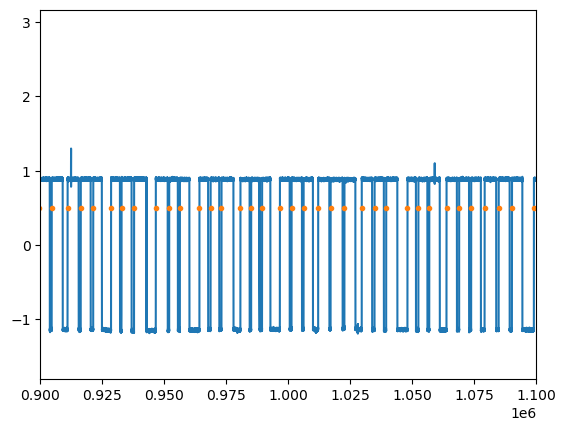

In [25]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([900000,1100000])
# plt.xlim([500000,700000])
plt.show()

In [26]:
photodiode_params = np.array([slope, offset])
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info'
np.save(diode_info_fname, photodiode_params)


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [27]:
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info.npy'
photodiode_params = np.load(diode_info_fname)

photodiode_params

array([ 0.99998241, -1.94912031])

In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [168]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1      135.0      loss   568.518679   568.536654     570.624765   
1        2       14.0       mix   578.067226   578.085536     584.535035   
2        3       67.0      gain   591.127701   591.128860     594.480254   
3        4       88.0      gain   606.559243   606.560426     610.023208   
4        5       58.0      gain   617.408691   617.409840     619.952049   
..     ...        ...       ...          ...          ...            ...   
145    146       32.0       mix  2209.402302  2209.435636    2211.064931   
146    147       25.0       mix  2217.997983  2218.017422    2225.058874   
147    148       39.0       mix  2235.071490  2235.086871    2237.386308   
148    149       94.0      gain  2244.619878  2244.621079    2247.048609   
149    150       34.0       mix  2254.436795  2254.437957    2256.511345   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       572.642744  2.088111     -0.5   -1.24  ...      1.24        0.50   
1       586.551410  6.449499      0.0   -0.50  ...      1.00        0.50   
2       596.497386  3.351395      0.3    0.00  ...     -0.95       -0.30   
3       612.040352  3.462782      0.5    0.00  ...      1.80        1.30   
4       621.968698  2.542208      0.2    0.00  ...      0.72        0.52   
..             ...       ...      ...     ...  ...       ...         ...   
145    2213.082789  1.629295      0.0   -1.50  ...      2.49        0.99   
146    2225.067856  7.041451      0.0   -1.10  ...     -0.57       -0.57   
147    2239.403627  2.299437      0.0   -0.50  ...      1.25        0.75   
148    2249.067155  2.427530      0.6    0.00  ...     -1.33       -0.60   
149    2258.527775  2.073388      0.0   -1.50  ...      3.00        1.50   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0          0.00           0.00        1.24           0.50    -1.24   
1          0.00           0.00        1.00           0.50    -0.50   
2         -0.95          -0.30        0.00           0.00     0.95   
3          0.00           0.00        1.80           1.30     0.00   
4          0.00           0.00        0.72           0.52     0.00   
..          ...            ...         ...            ...      ...   
145        0.00           0.00        2.49           0.99    -1.50   
146       -0.57          -0.57        0.00           0.00     0.57   
147        0.00           0.00        1.25           0.75    -0.50   
148       -1.33          -0.60        0.00           0.00     1.33   
149        0.00           0.00        3.00           1.50    -1.50   

     decisionCF   pRPE   nRPE  
0         -0.50  0.620  0.000  
1          0.00  0.500  0.000  
2          0.30  0.000 -0.475  
3          0.50  0.900  0.000  
4          0.20  0.360  0.000  
..          ...    ...    ...  
145        0.00  1.245  0.000  
146        0.57  0.000  0.000  
147        0.00  0.625  0.000  
148        0.60  0.000 -0.665  
149        0.00  1.500  0.000  

[150 rows x 32 columns]

In [169]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 570.624765034634, 572.6427440883708),
 ('gamble', 584.535035312656, 586.5514100994478),
 ('gamble', 594.480254375303, 596.4973858982266),
 ('gamble', 610.0232075986278, 612.0403524335561),
 ('gamble', 619.9520488024864, 621.9686976800003),
 ('gamble', 629.6150687769841, 631.6308936756832),
 ('safe', 649.0391424066911, 649.048135517558),
 ('safe', 660.0838809743291, 660.0928112798429),
 ('gamble', 670.8456671309978, 672.8629867286218),
 ('gamble', 684.7893580440577, 686.8067264523561),
 ('gamble', 697.5336167310743, 699.5506448299857),
 ('gamble', 712.4120597183355, 0.0),
 ('gamble', 721.9909509104618, 724.0065109344578),
 ('safe', 732.4849023120914, 732.4937541109393),
 ('gamble', 742.0134802796383, 744.0306769972376),
 (nan, 761.3229235751205, 0.0),
 ('gamble', 765.4365043091675, 767.453228280021),
 ('gamble', 775.2150857753877, 777.2318984929152),
 ('gamble', 791.2259599745739, 793.2416951025953),
 ('gamble', 800.5869094548398, 802.6042123271181),
 ('safe', 809.9163886790

In [170]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       572.624765
1       586.535035
2       596.480254
3       612.023208
4       621.952049
          ...     
145    2213.064931
146    2227.058874
147    2239.386308
148    2249.048609
149    2258.511345
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [171]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [172]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [173]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [174]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/bp_ref_ieeg.fif...
    Range : 0 ... 1150155 =      0.000 ...  2300.310 secs
Ready.
Reading 0 ... 1150155  =      0.000 ...  2300.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.0s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/bp_ref_ieeg.fif...
    Range : 0 ... 1150155 =      0.000 ...  2300.310 secs
Ready.
Reading 0 ... 1150155  =      0.000 ...  2300.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.8s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA037/bp_ref_ieeg.fif...
    Range : 0 ... 1150155 =      0.000 ...  2300.310 secs
Ready.
Reading 0 ... 1150155  =      0.000 ...  2300.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.8s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [175]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~46.5 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~38.7 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~77.4 MB, data loaded,
  'CpeOnset': 150>}

In [176]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [177]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [178]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [179]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

In [180]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~46.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~38.7 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~77.4 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [181]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [182]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [183]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.7s finished


Adding metadata with 19 columns


In [184]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 27, ~464.5 MB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [185]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.2s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
baseline z-score iteration # 8
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.6s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
baseline z-score iteration # 8
baseline z-score iteration # 9
Not setting metadata
Adding metadata with 19 columns


In [186]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 27, ~232.8 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 27, ~1.36 GB>}

In [187]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 27, ~232.8 MB>

In [188]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 27, ~1.36 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [189]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


06052024 -1.9491203149658531


Plot TFR for epoch:  DecisionOnset


<IPython.core.display.Javascript object>


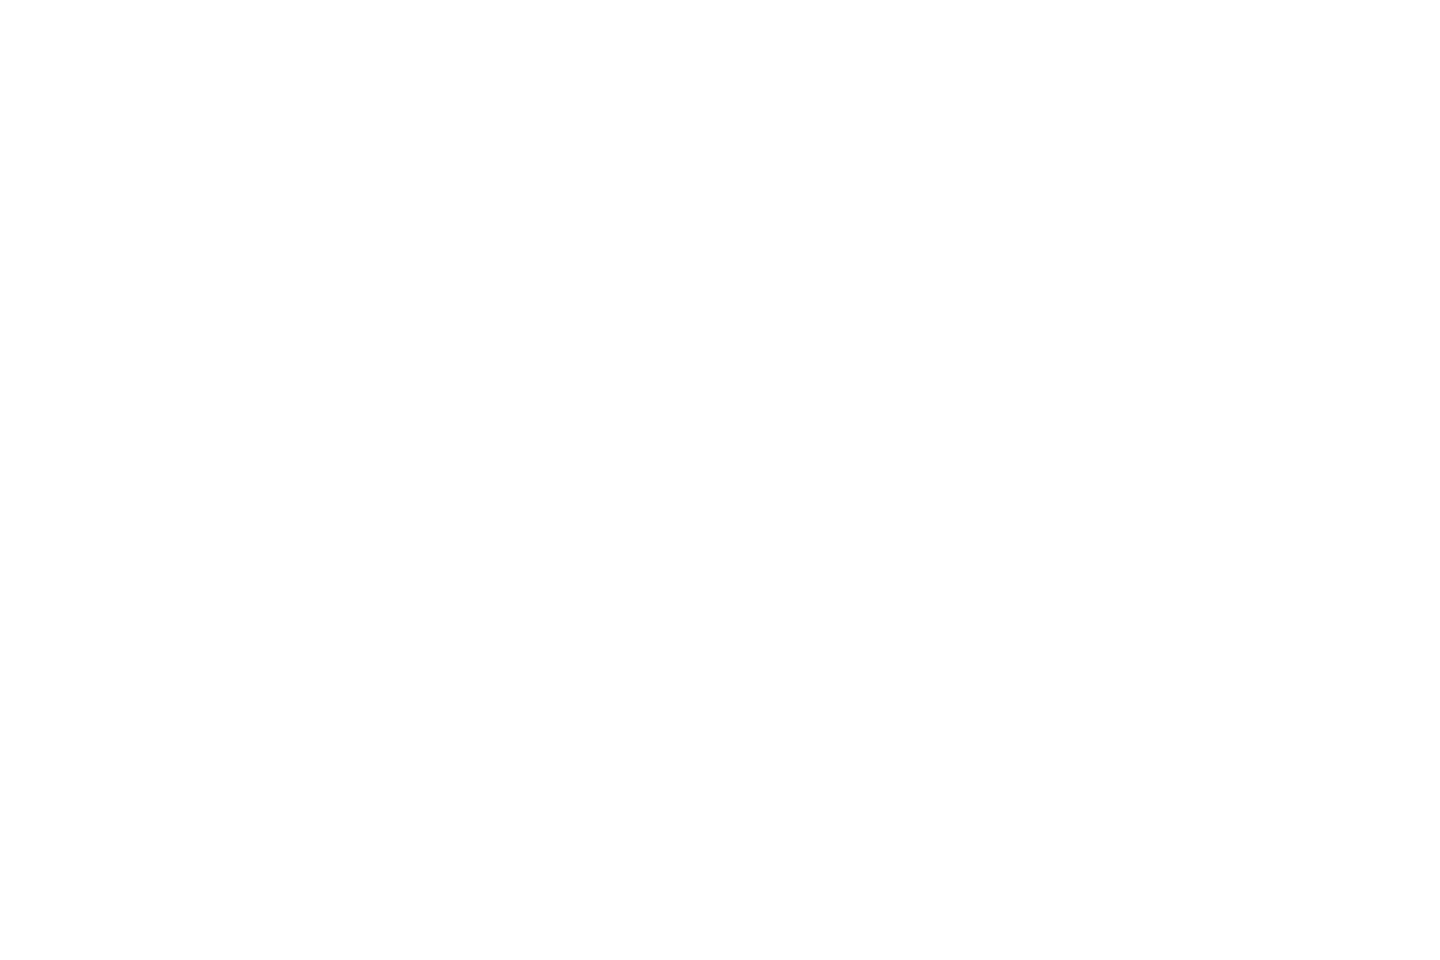

<IPython.core.display.Javascript object>


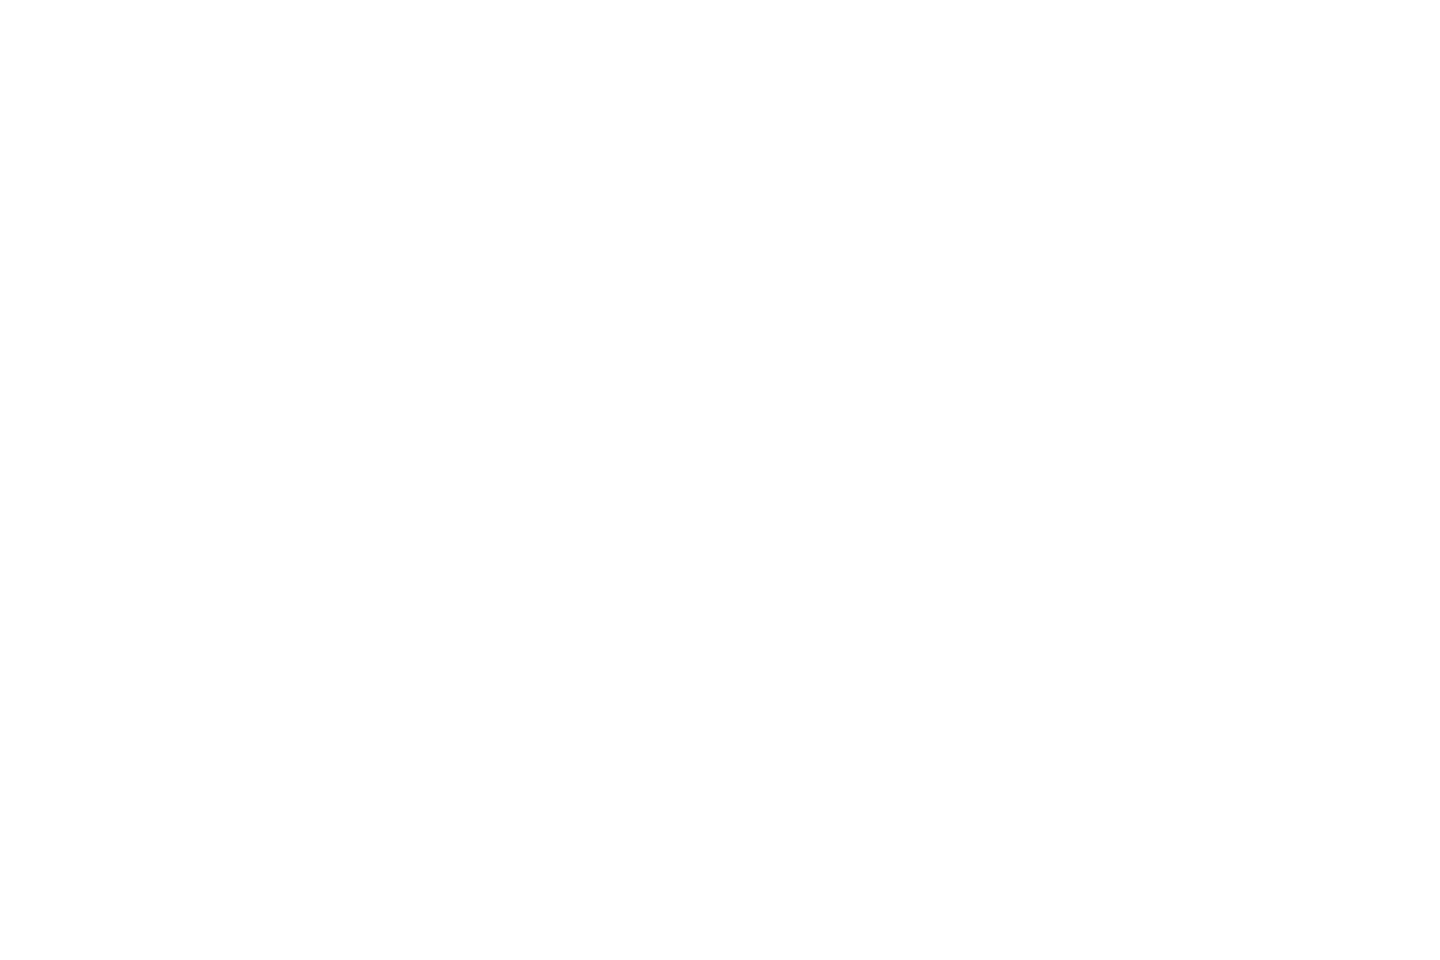

<IPython.core.display.Javascript object>


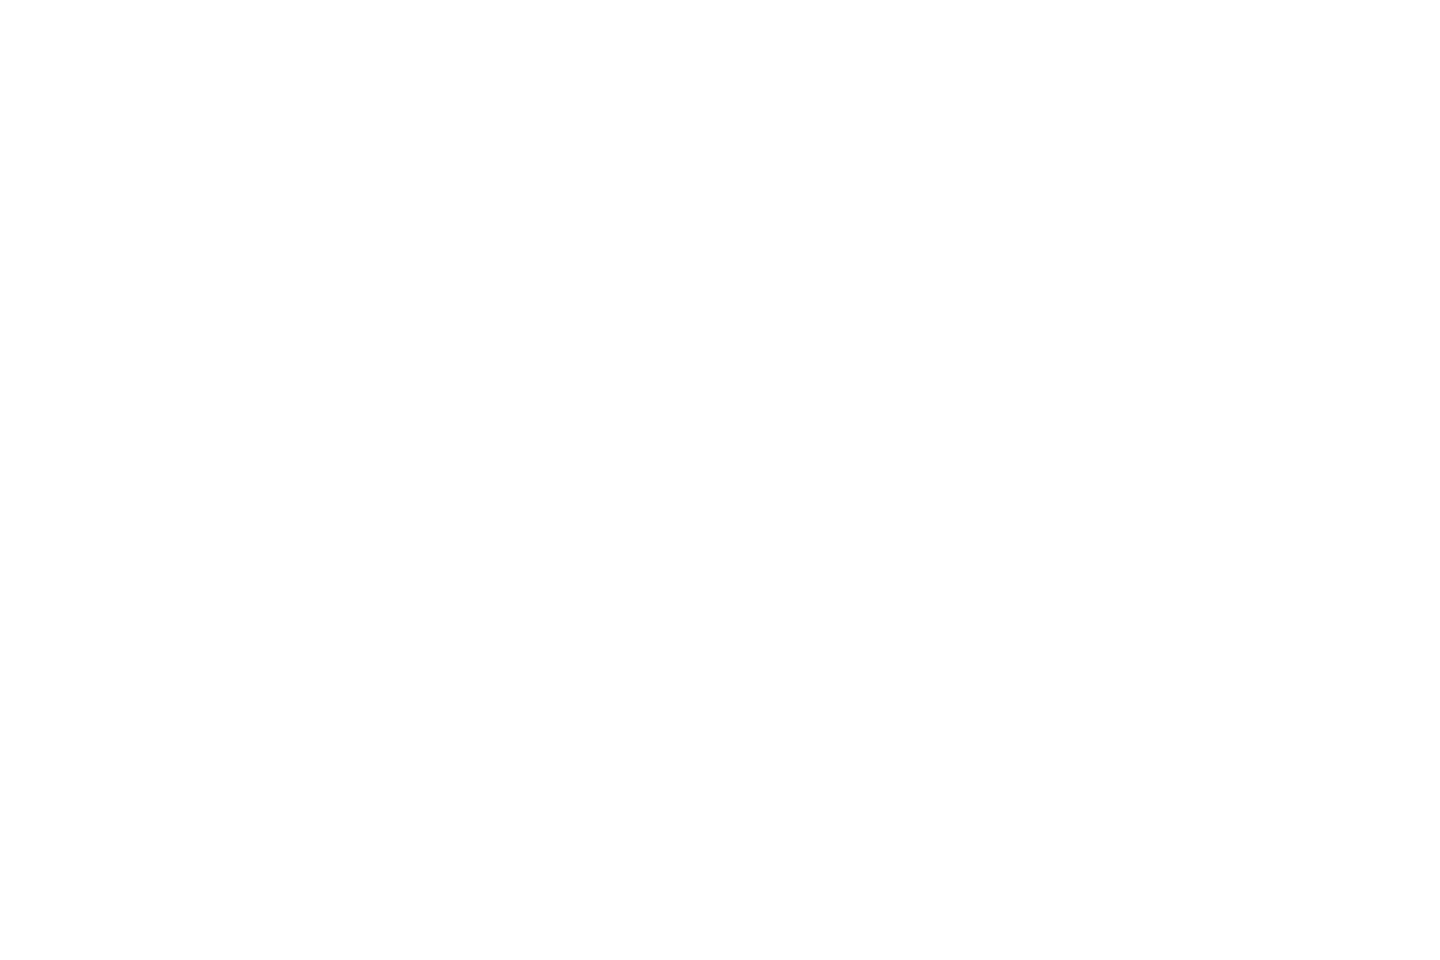

<IPython.core.display.Javascript object>


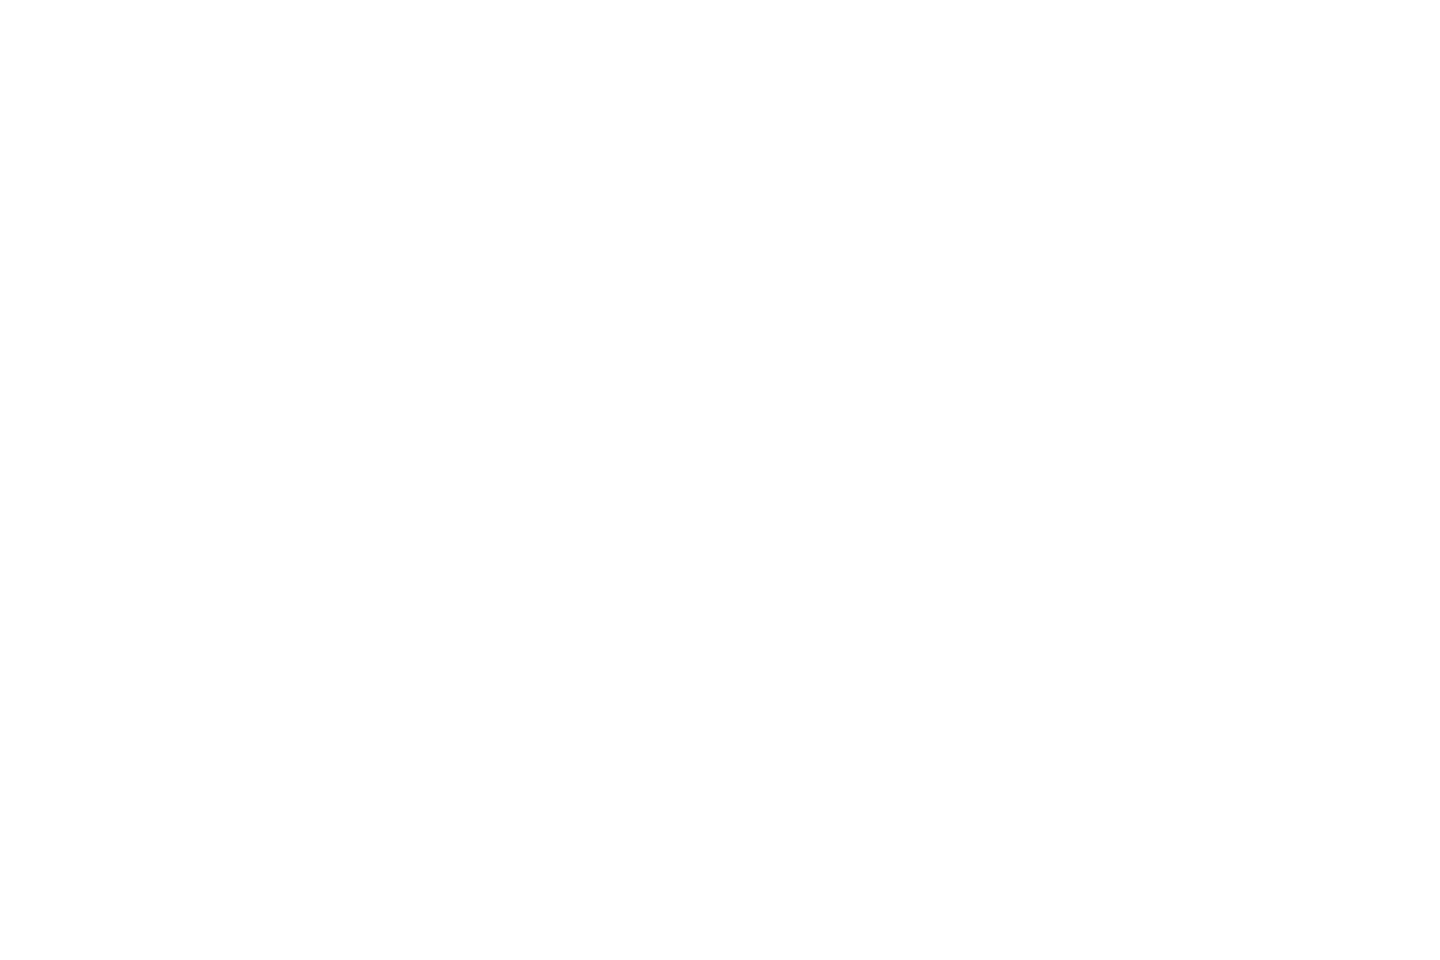

<IPython.core.display.Javascript object>


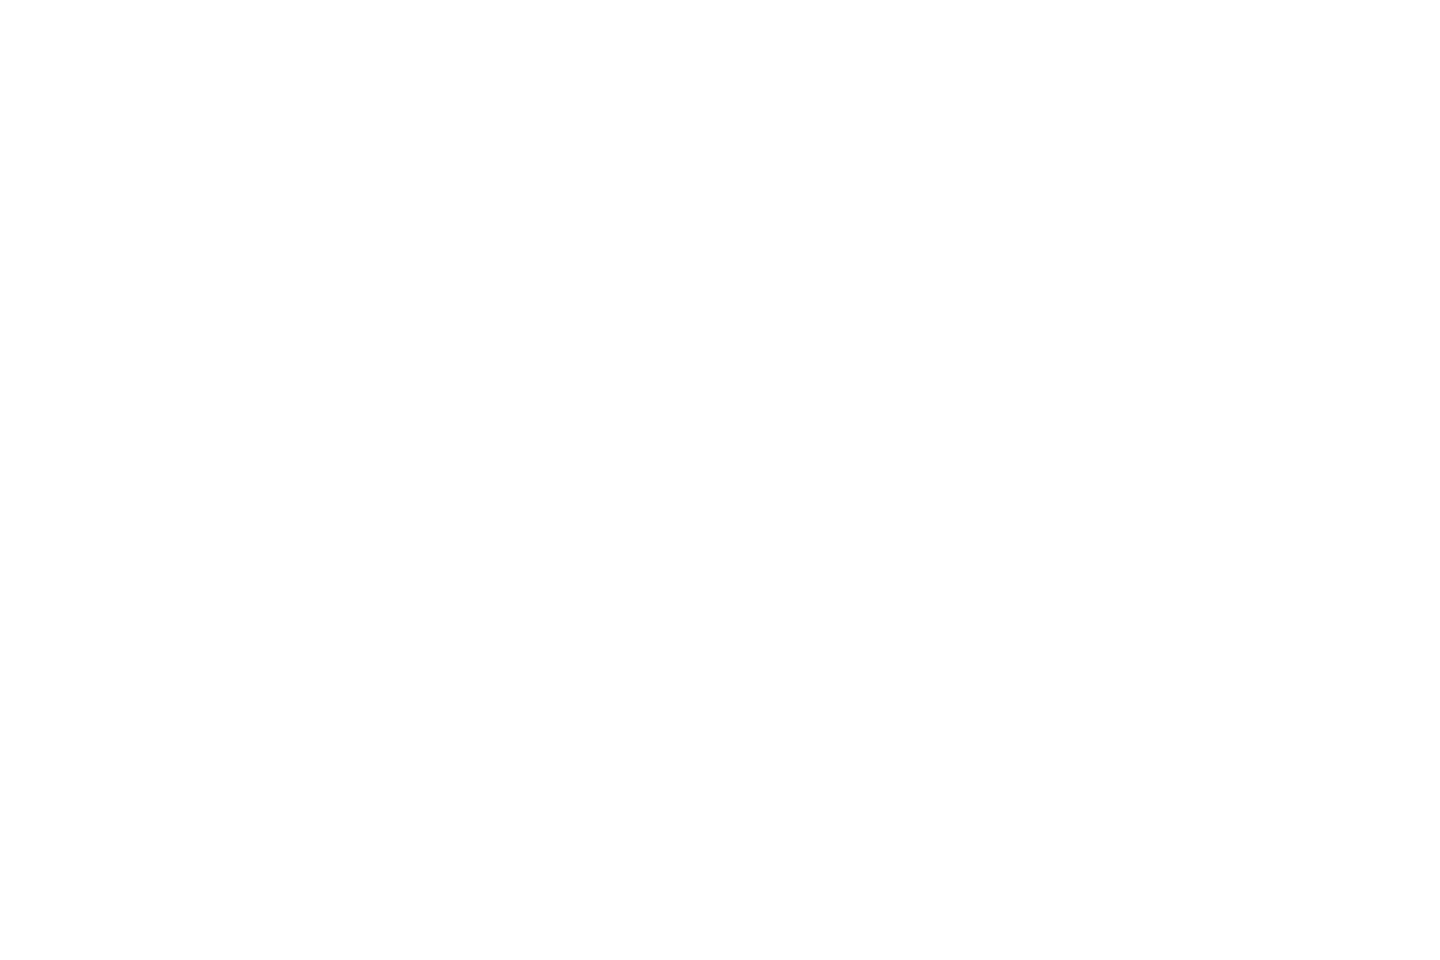

<IPython.core.display.Javascript object>


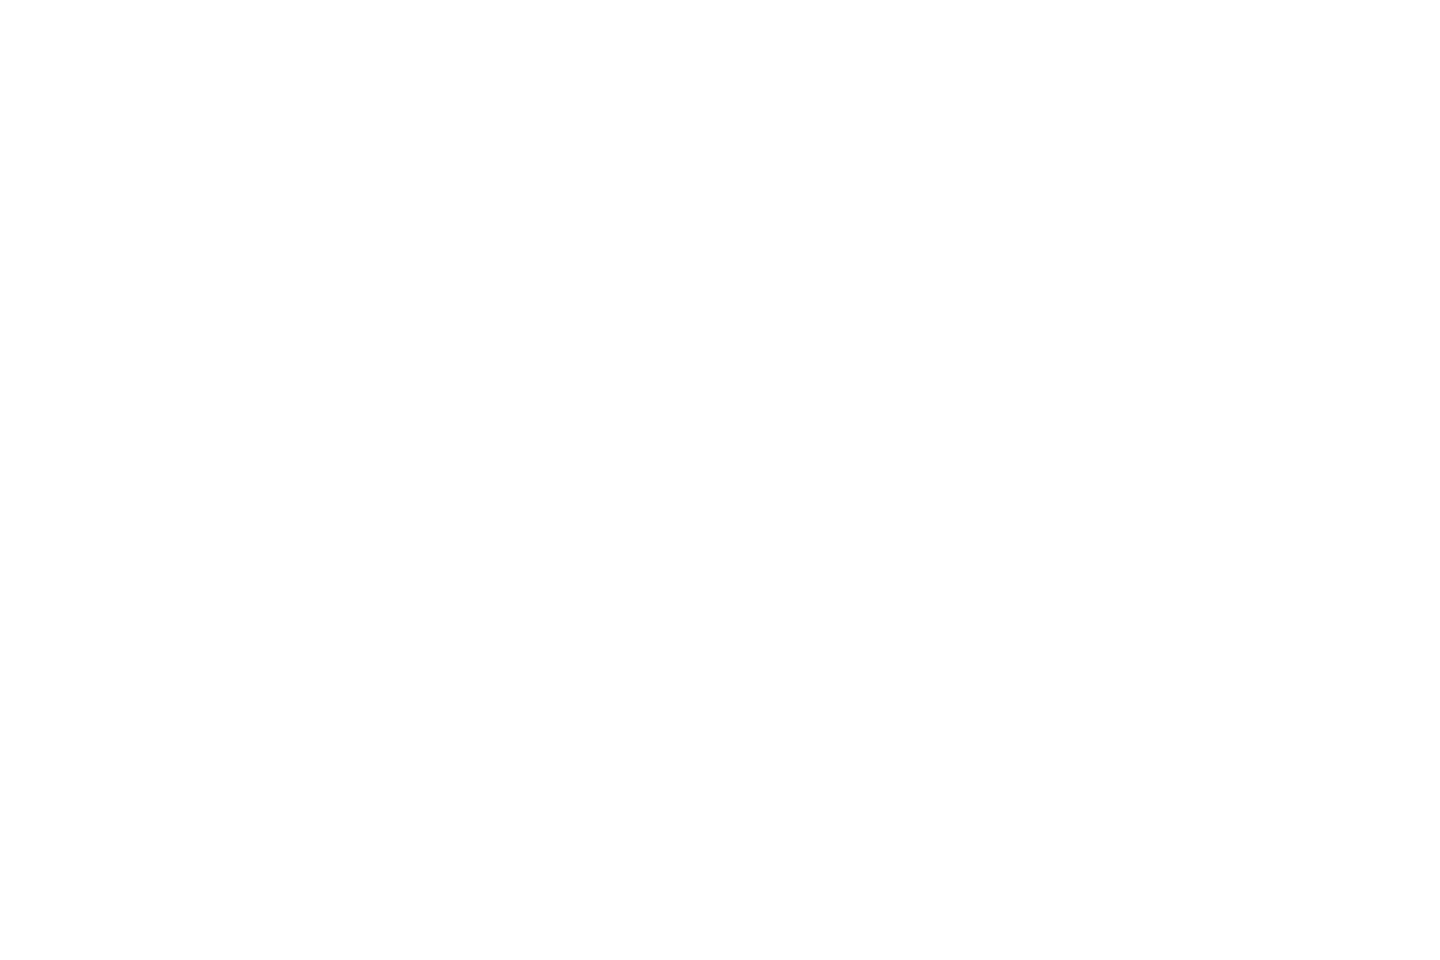

<IPython.core.display.Javascript object>


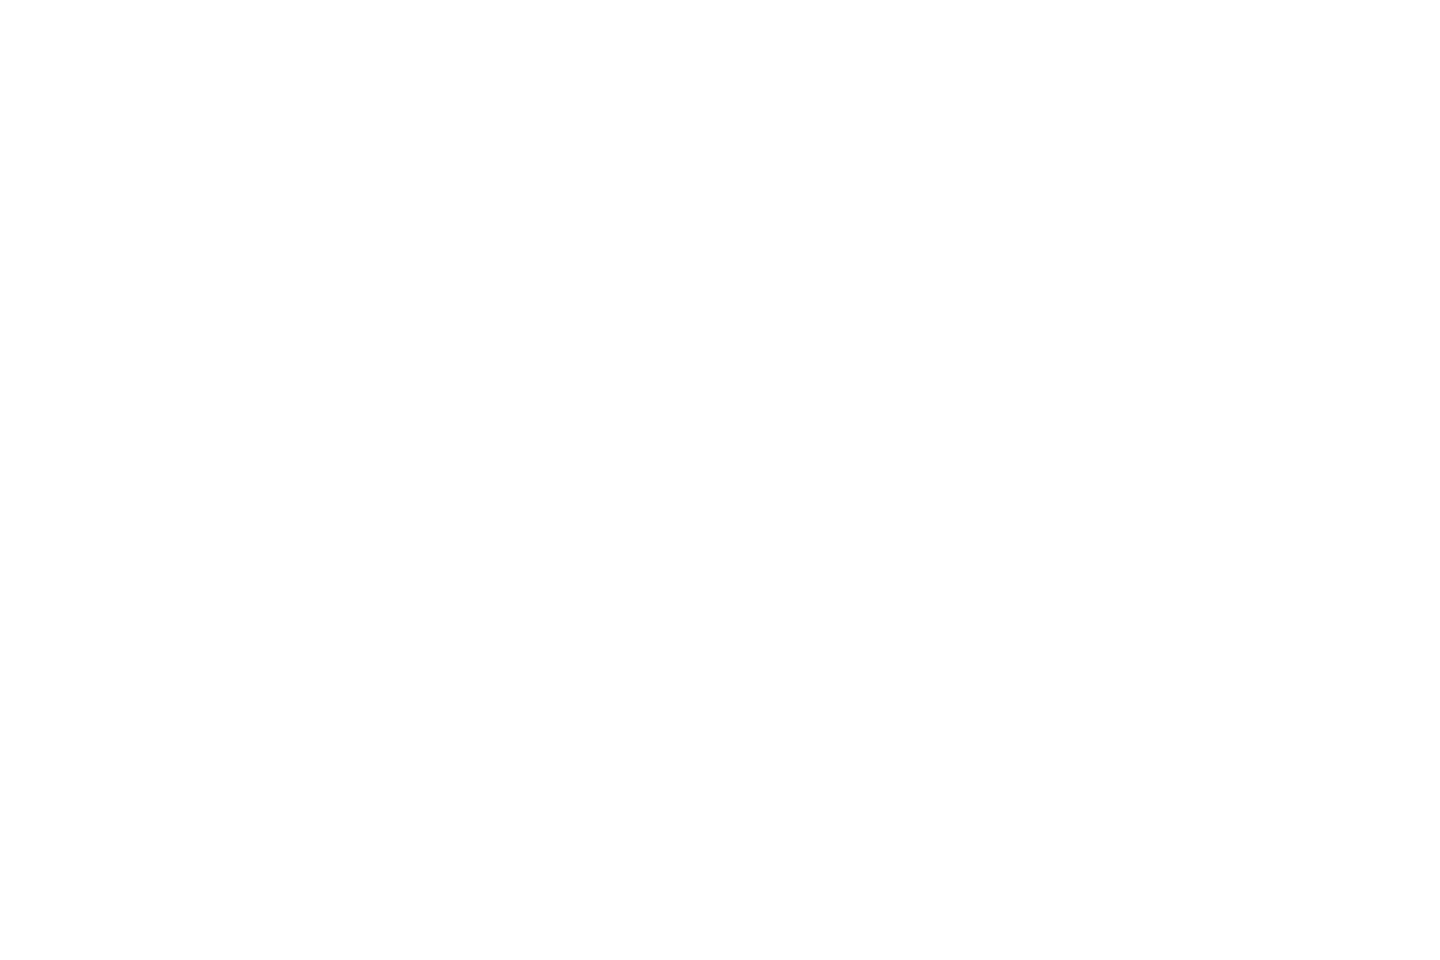

<IPython.core.display.Javascript object>


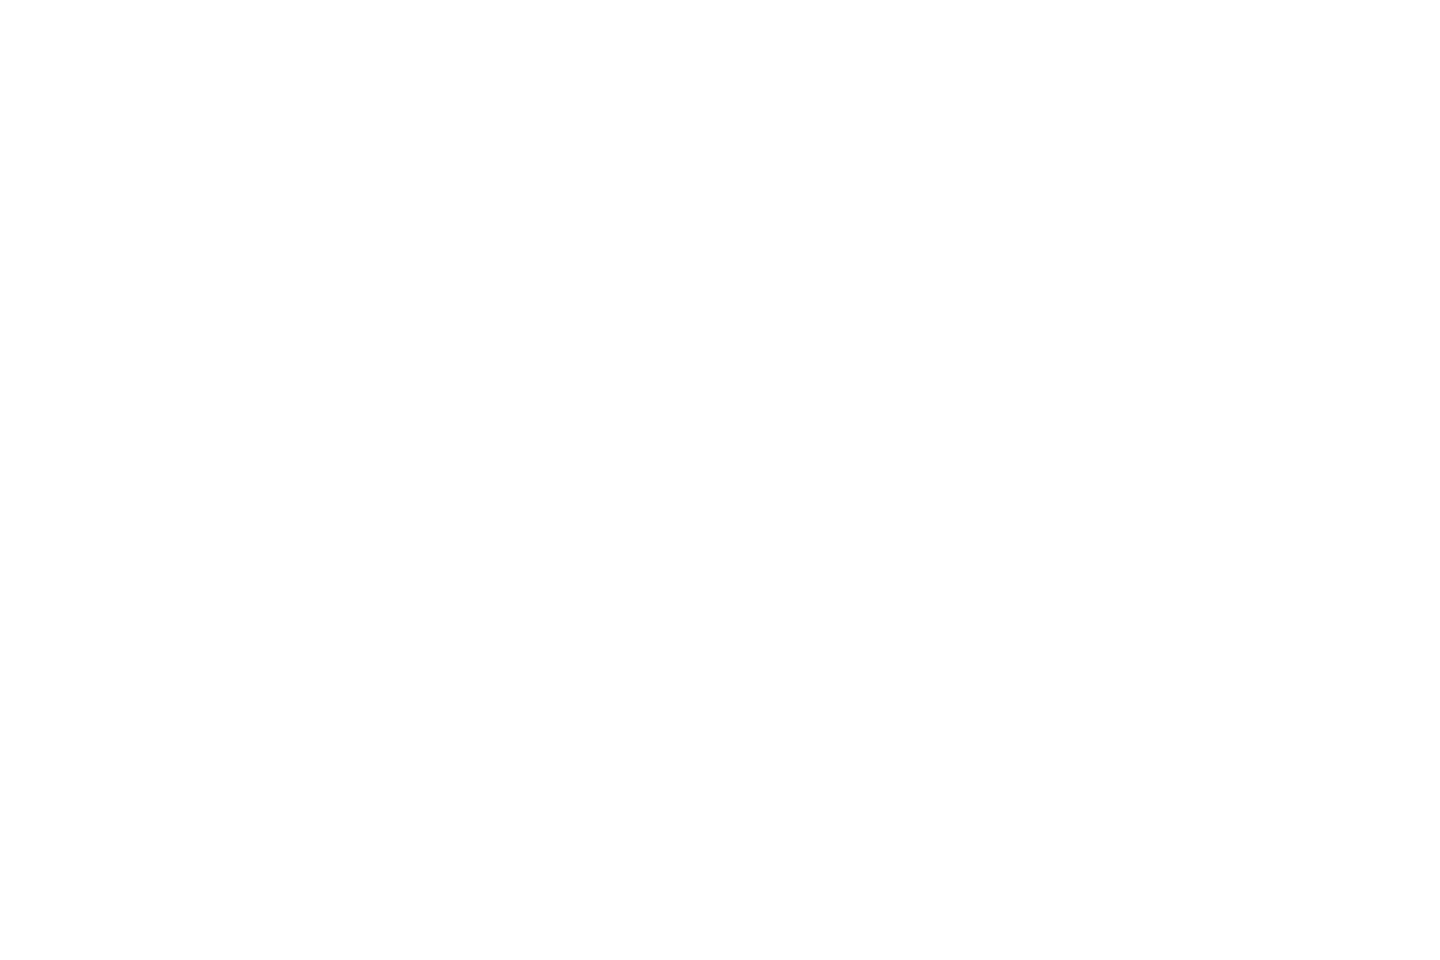

<IPython.core.display.Javascript object>


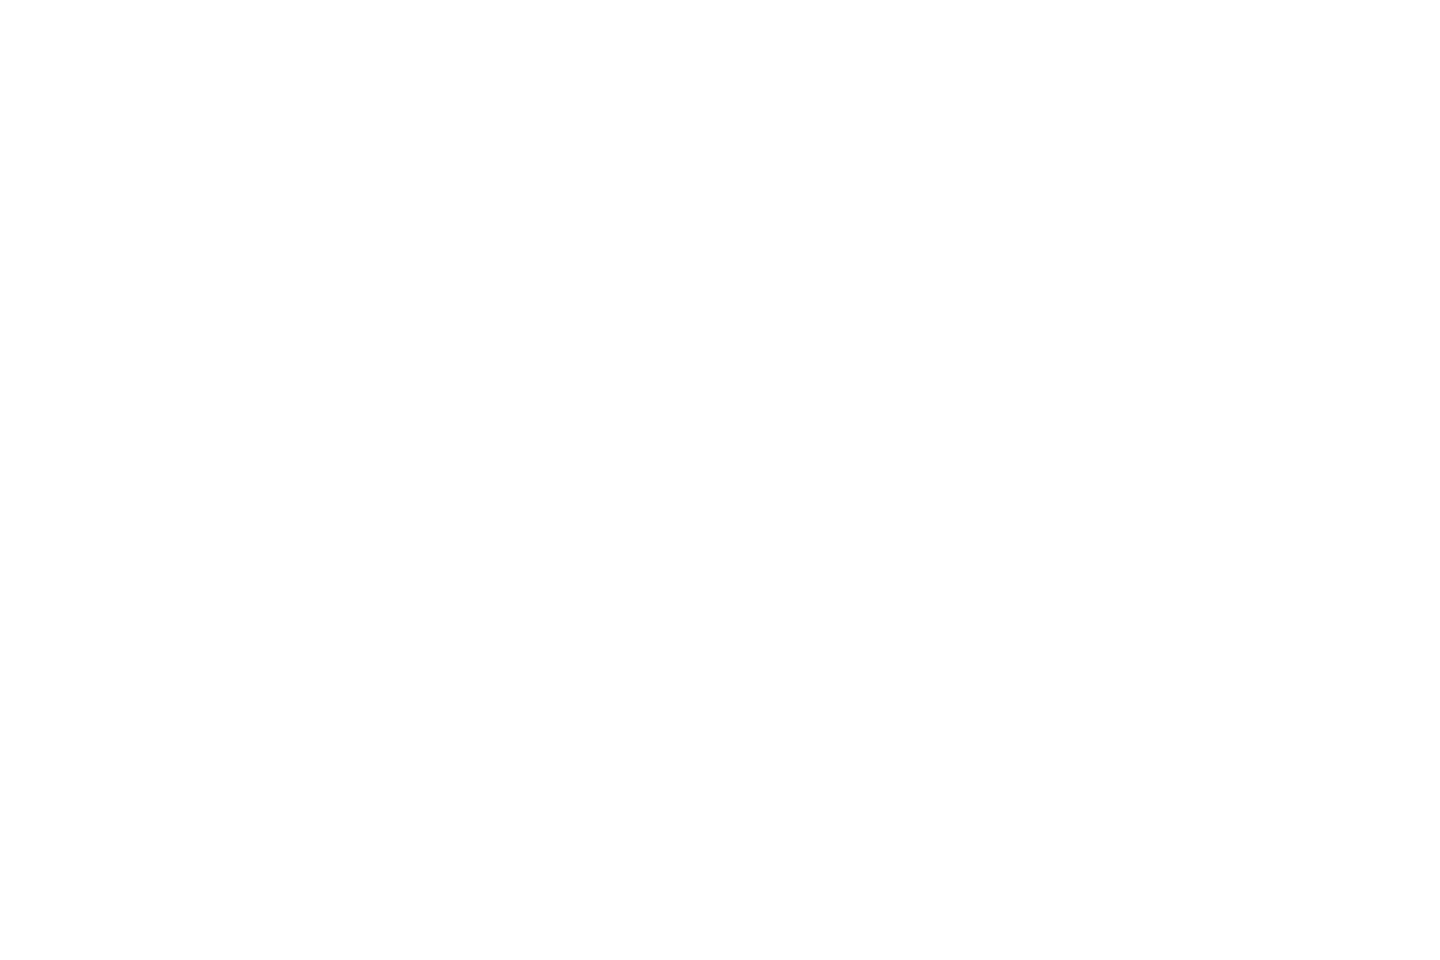

<IPython.core.display.Javascript object>


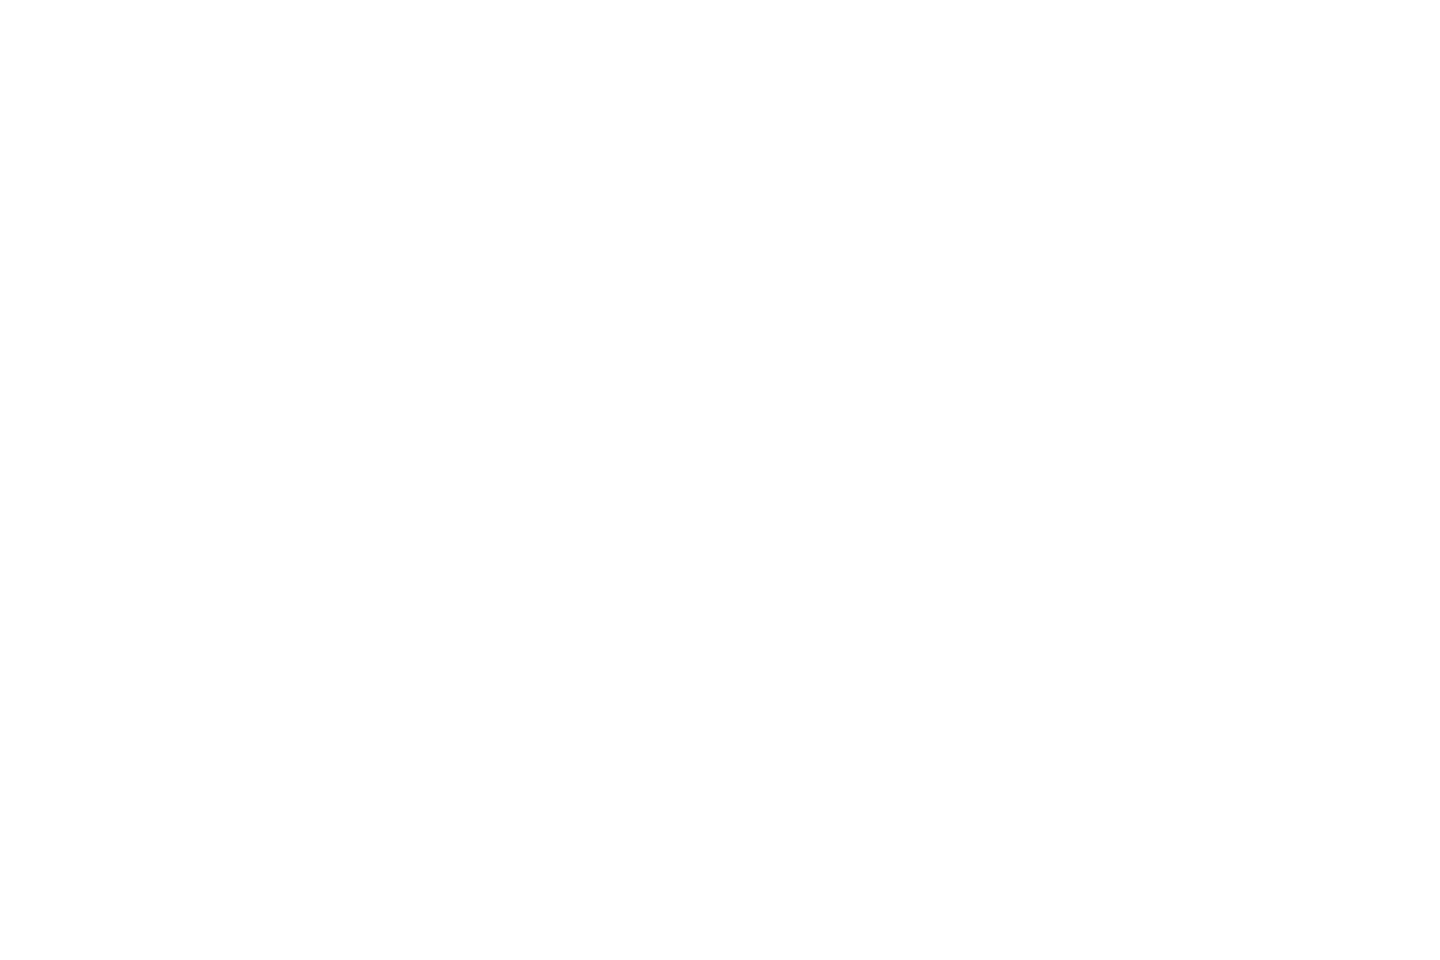

<IPython.core.display.Javascript object>


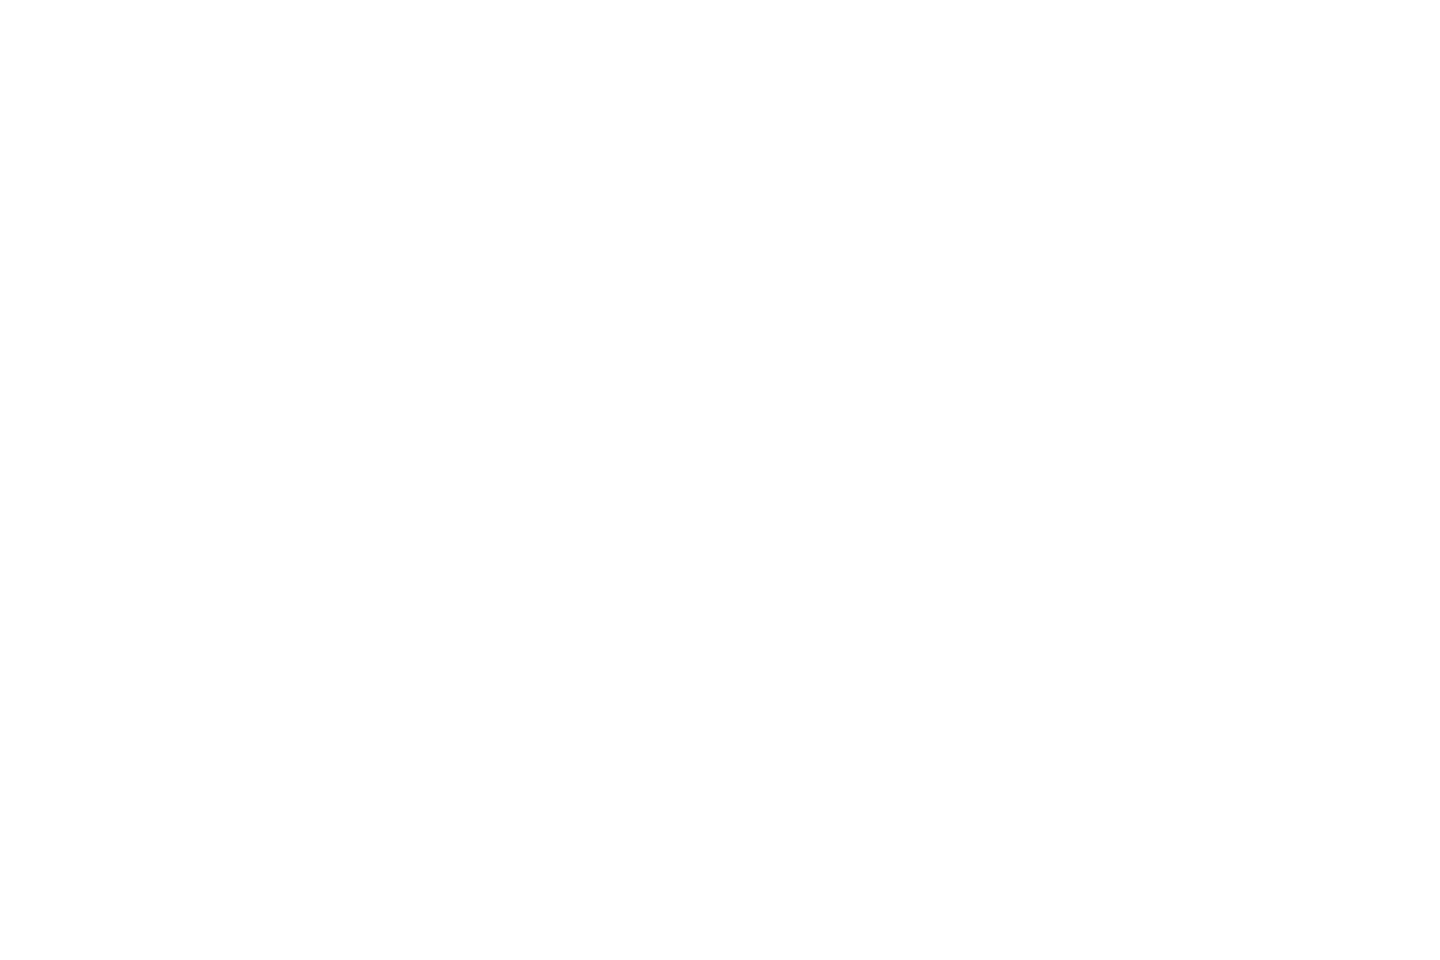

<IPython.core.display.Javascript object>


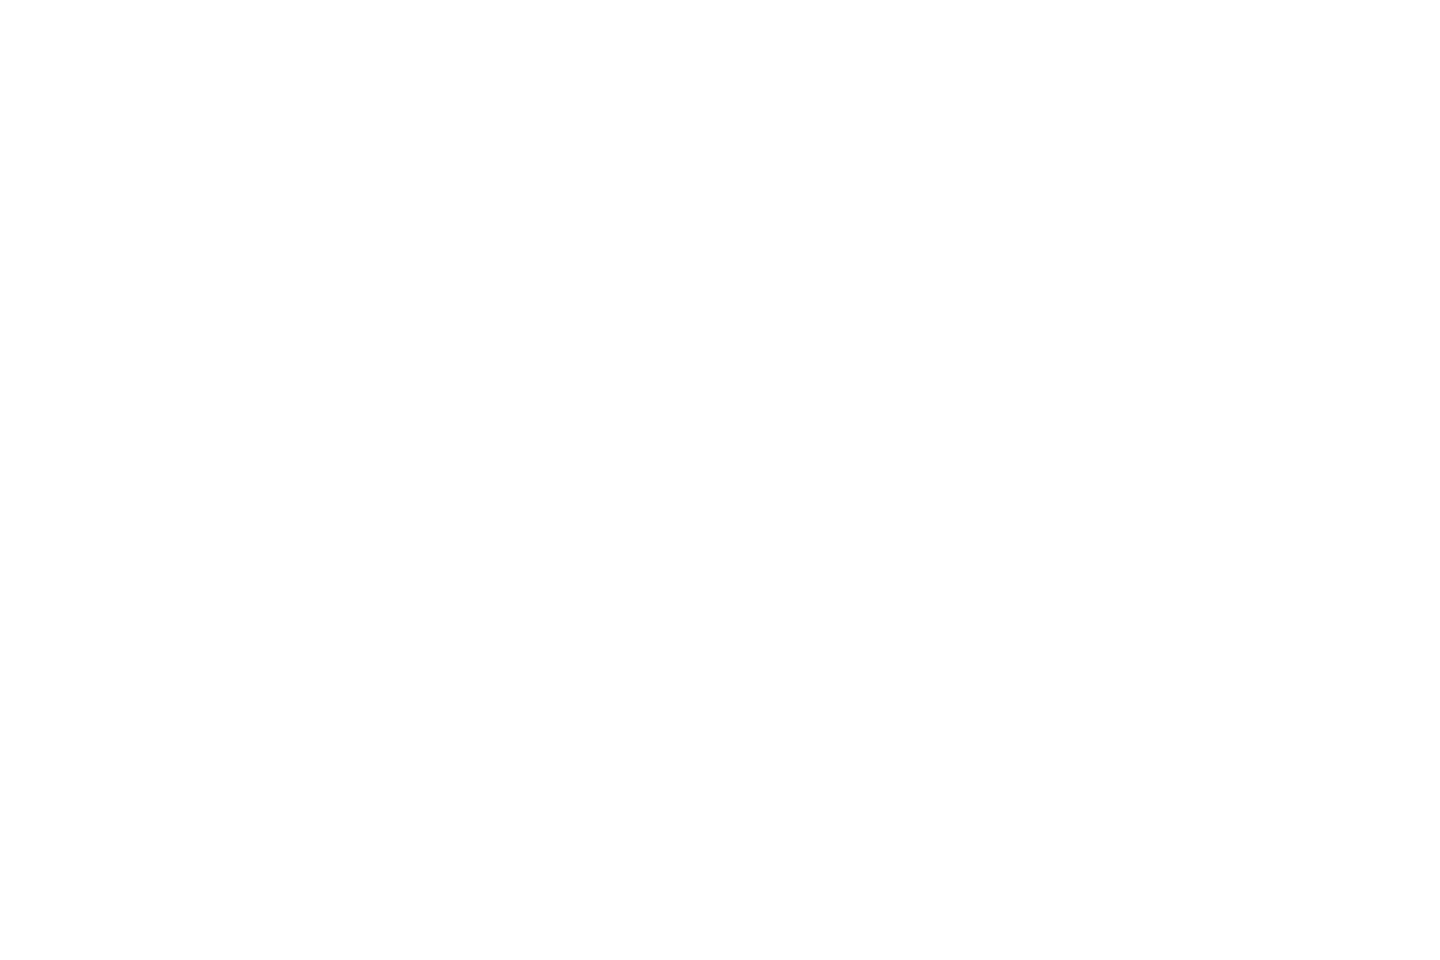

<IPython.core.display.Javascript object>


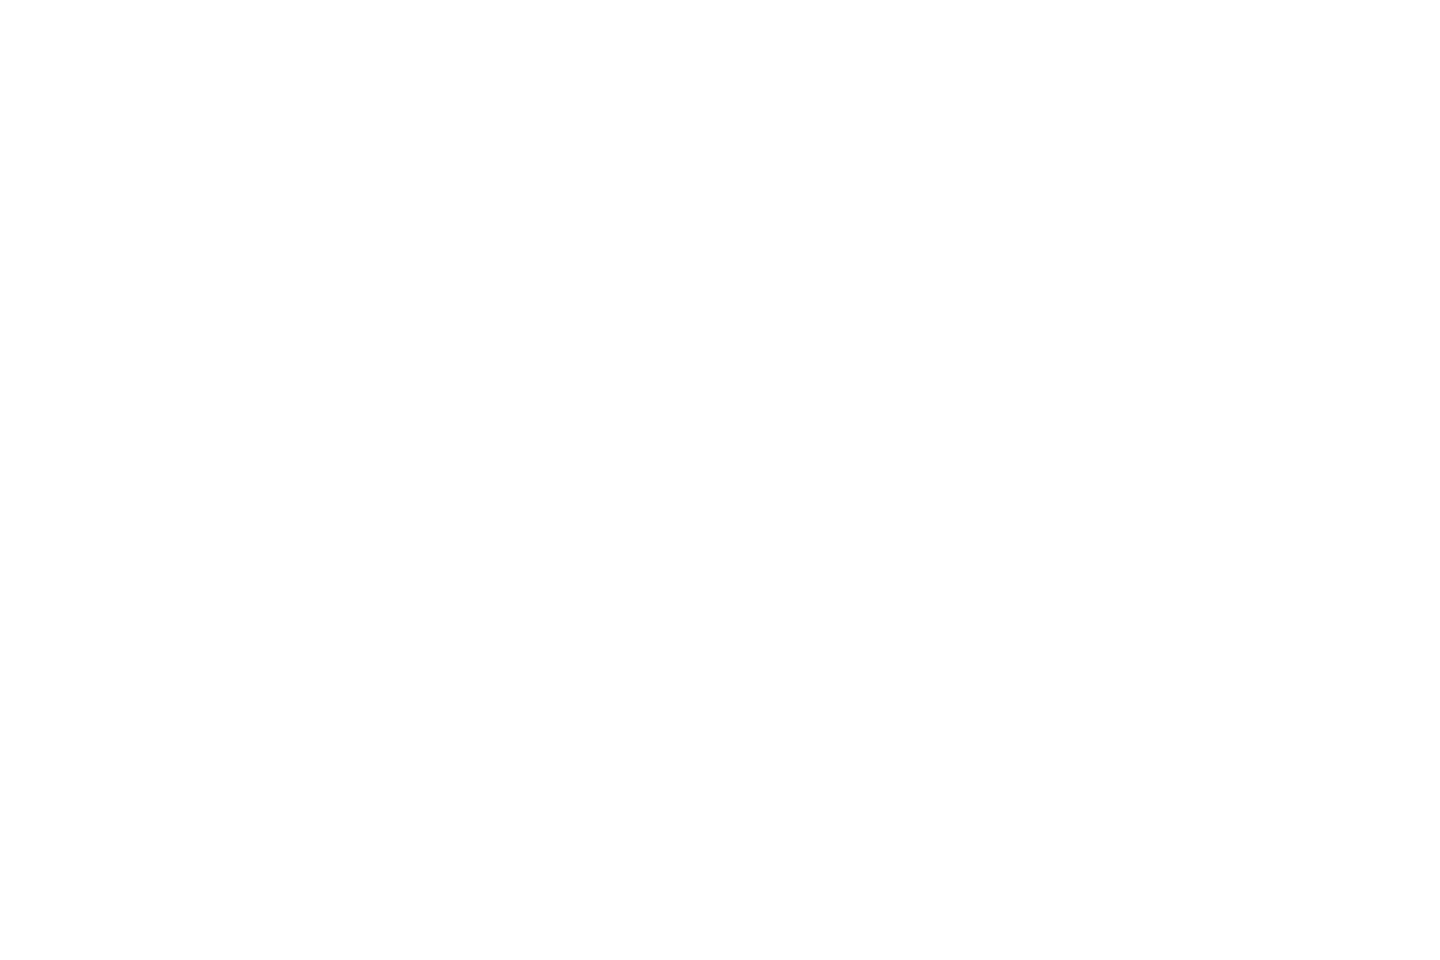

<IPython.core.display.Javascript object>


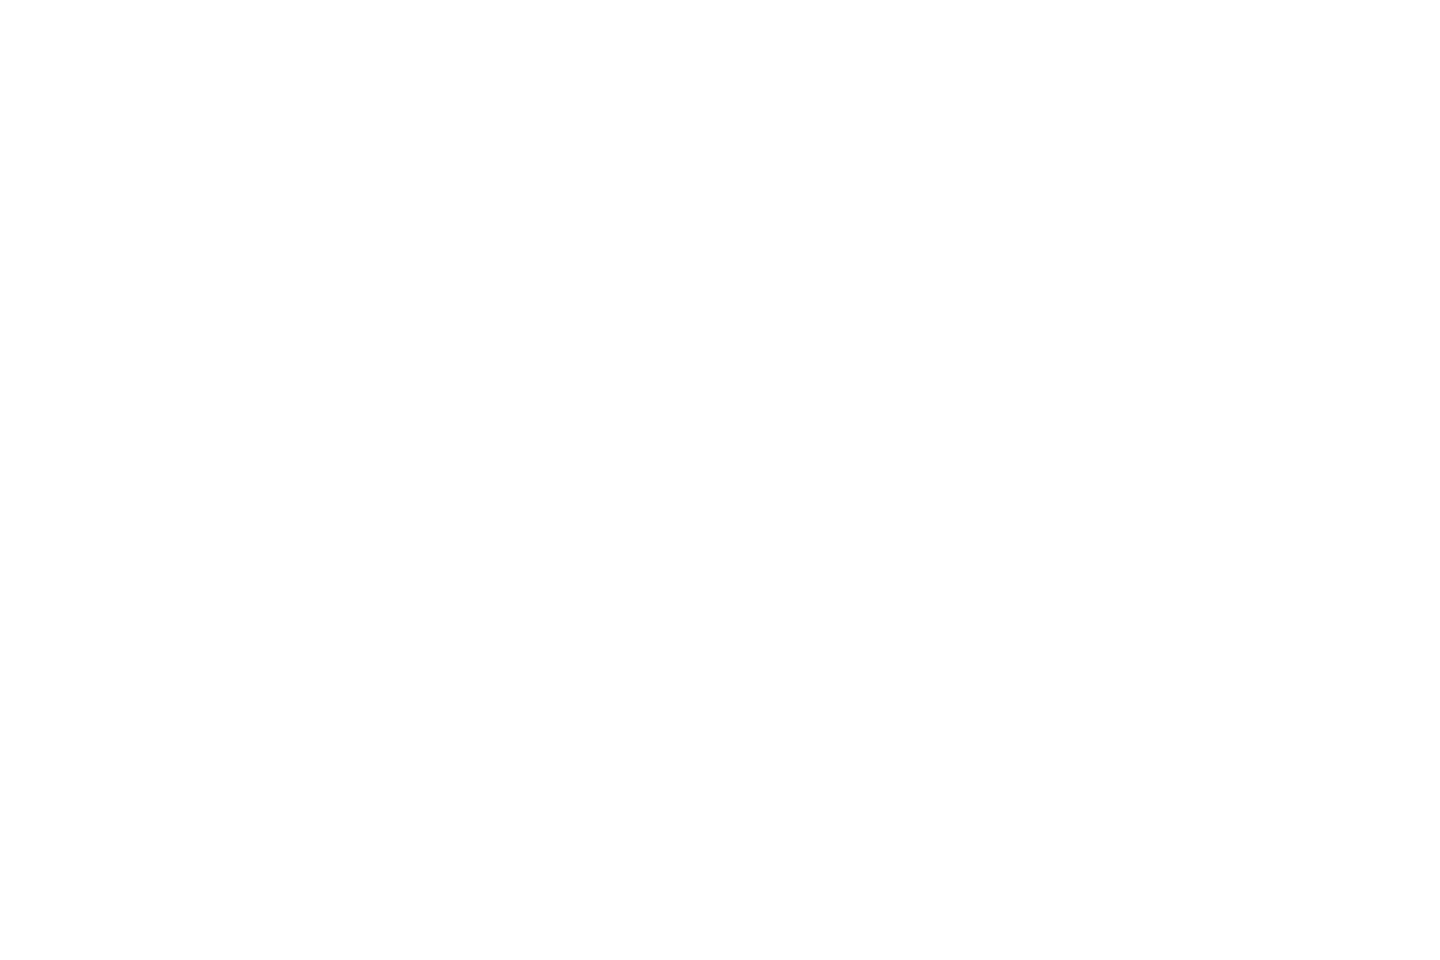

<IPython.core.display.Javascript object>


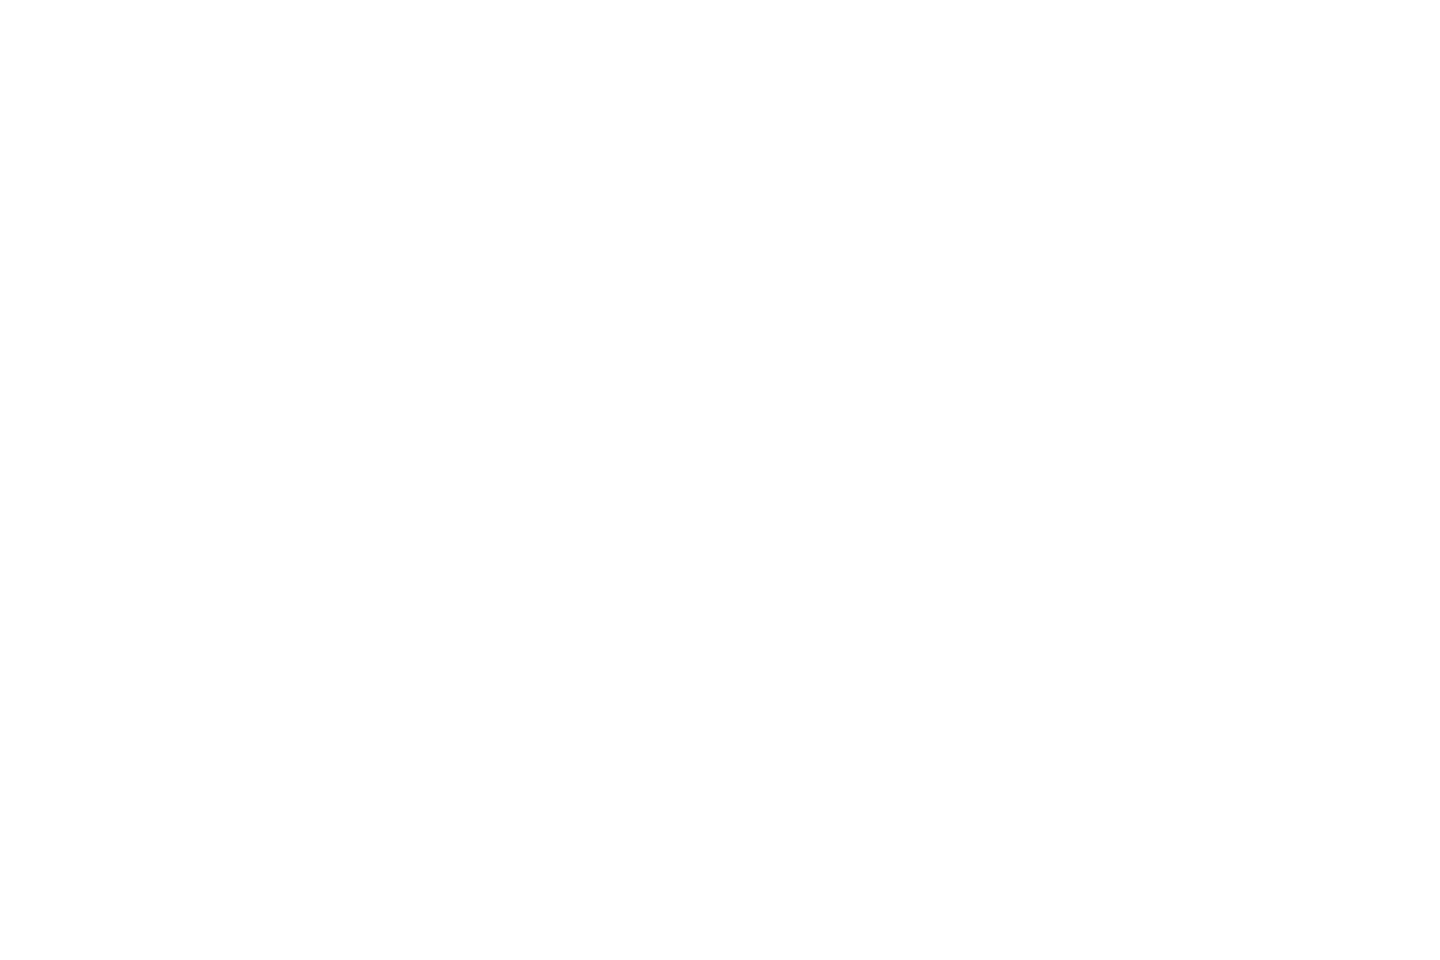

<IPython.core.display.Javascript object>


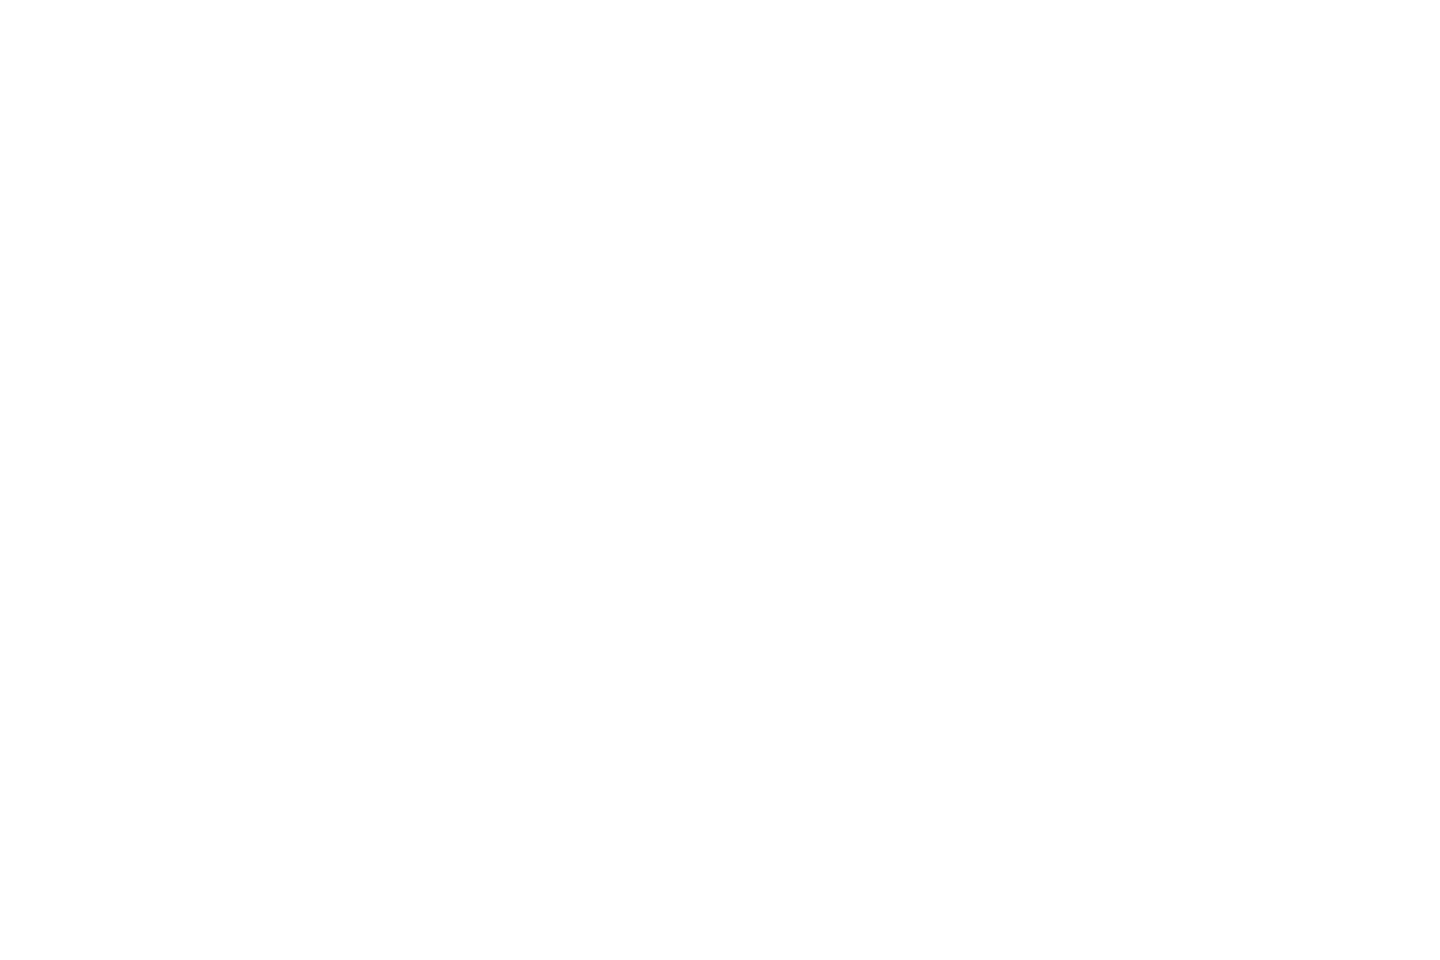

<IPython.core.display.Javascript object>


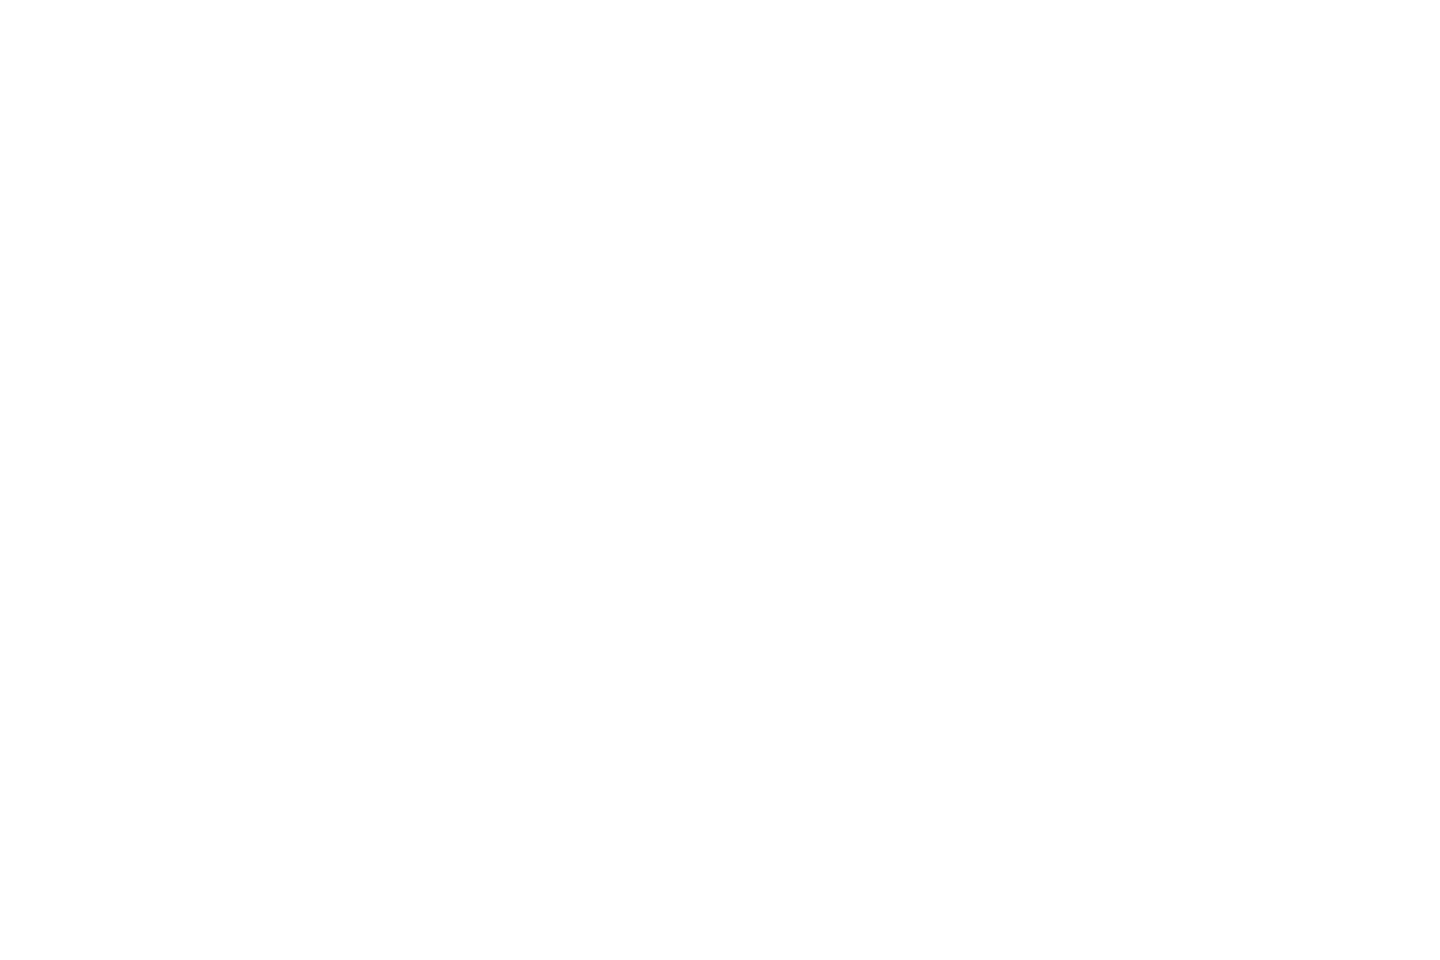

<IPython.core.display.Javascript object>


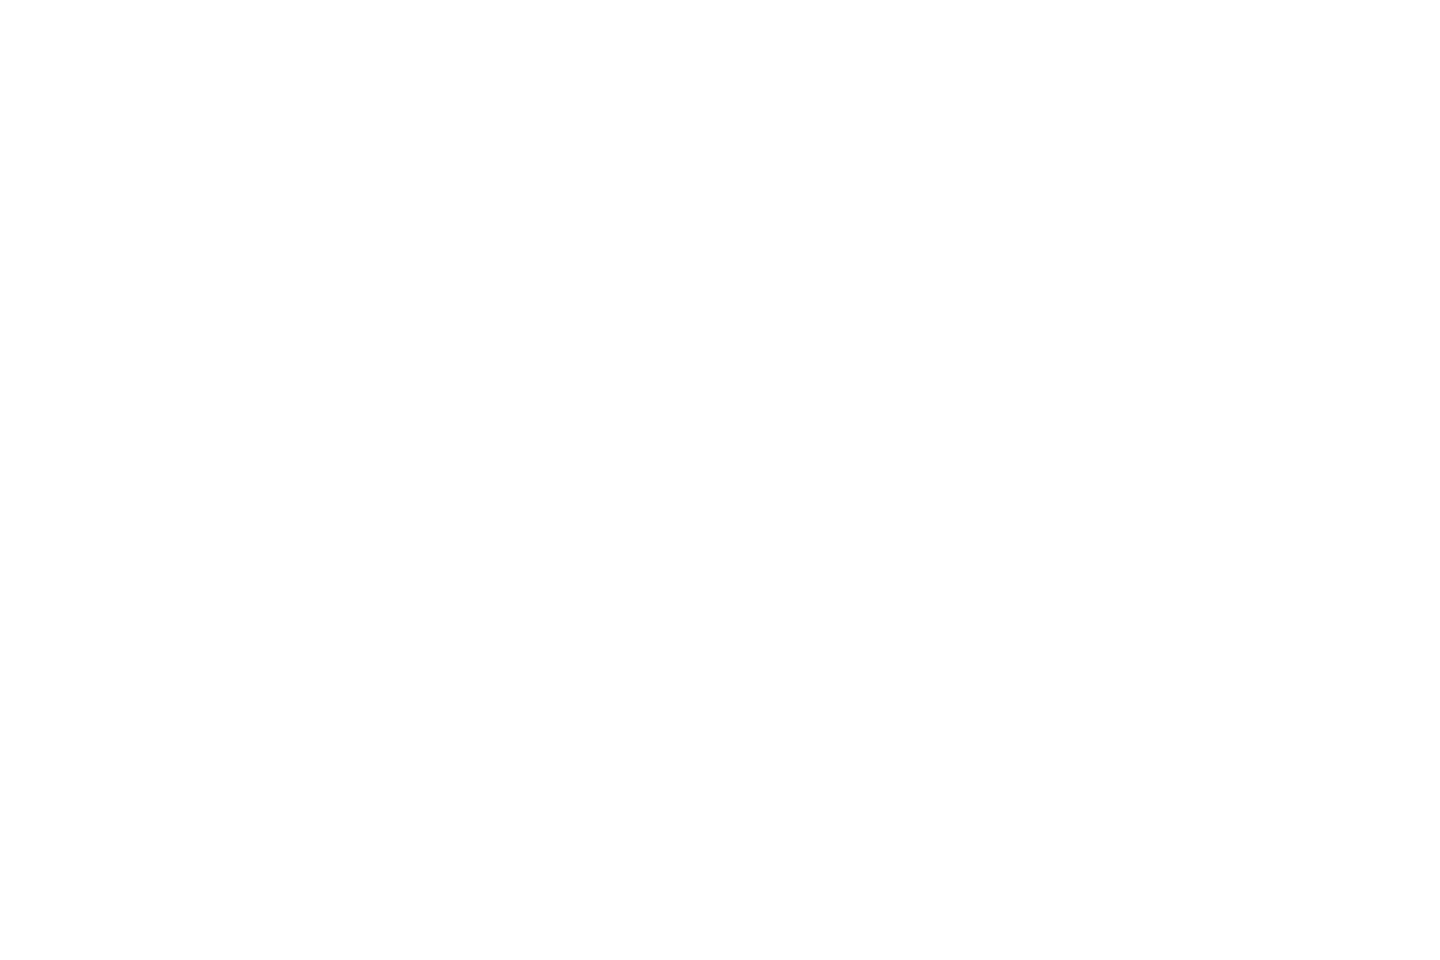

<IPython.core.display.Javascript object>


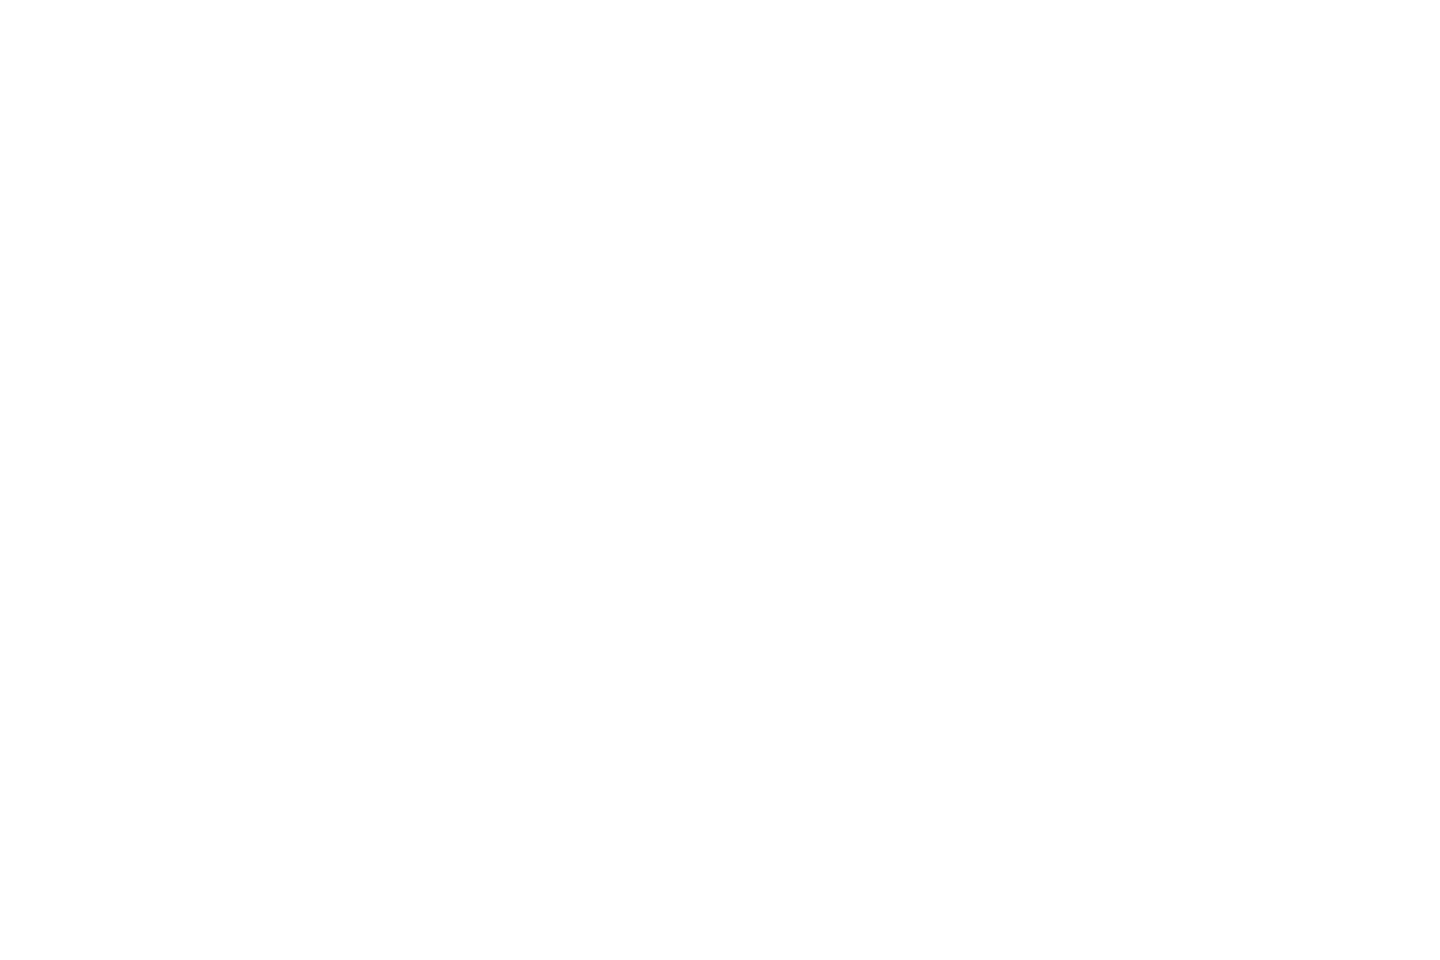

<IPython.core.display.Javascript object>


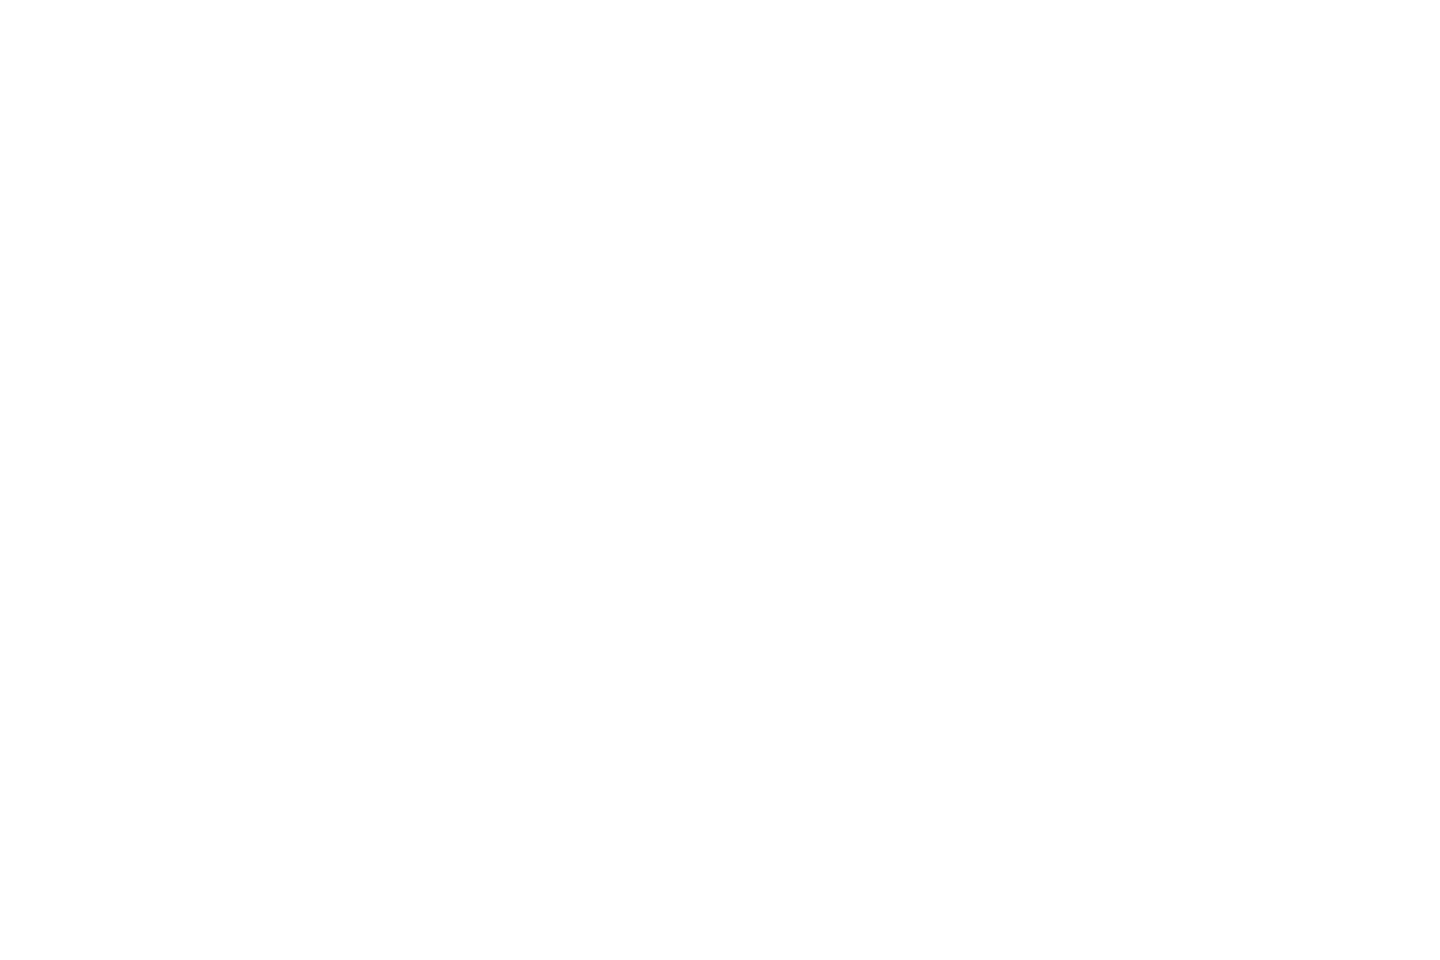

<IPython.core.display.Javascript object>


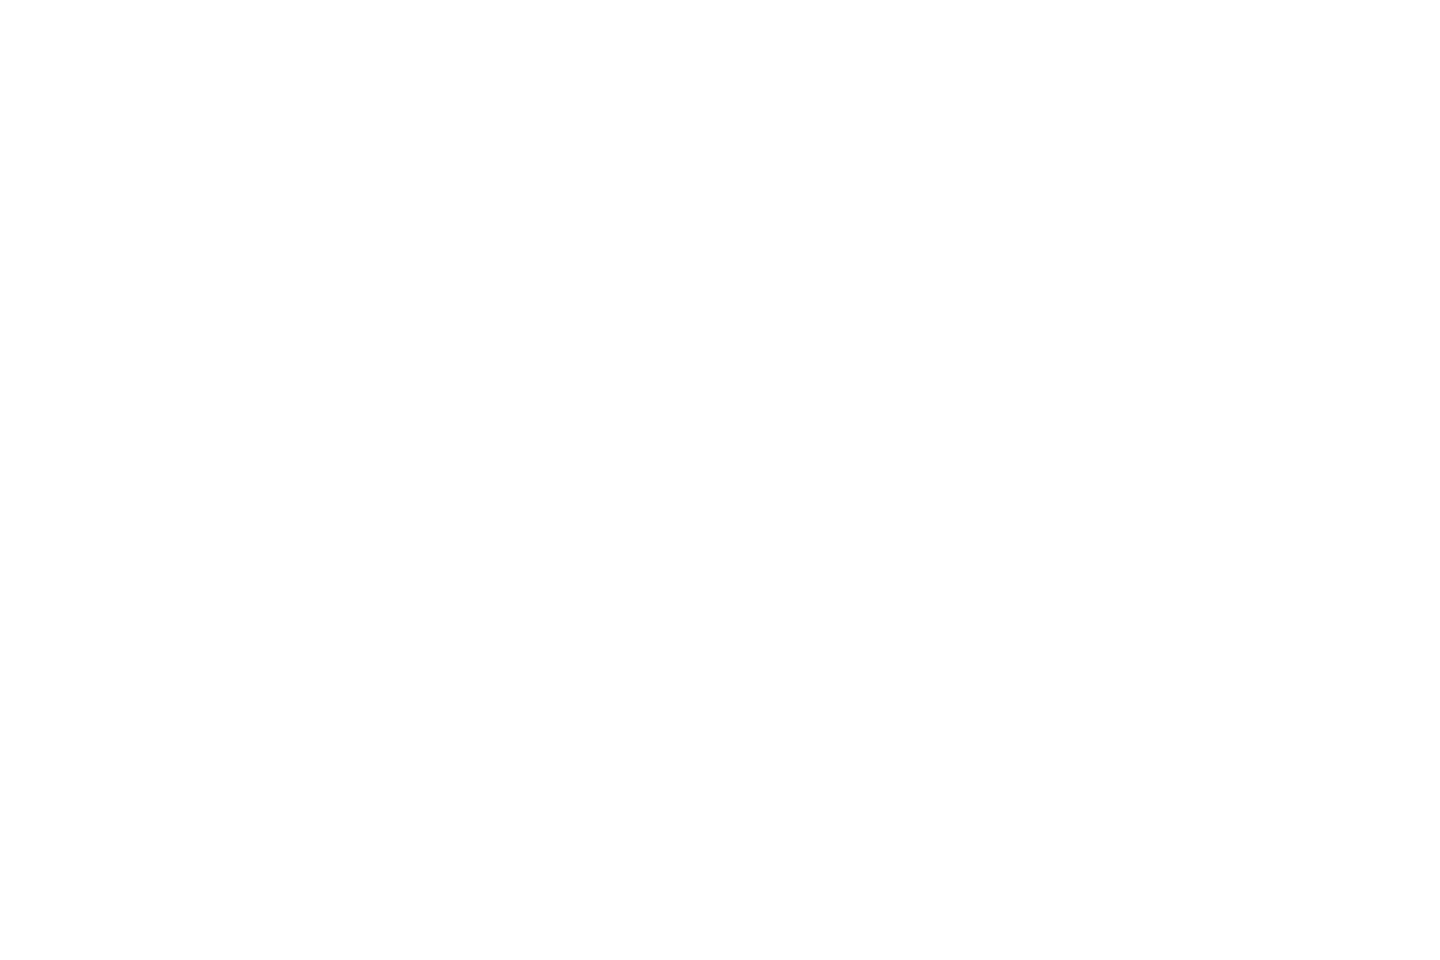

<IPython.core.display.Javascript object>


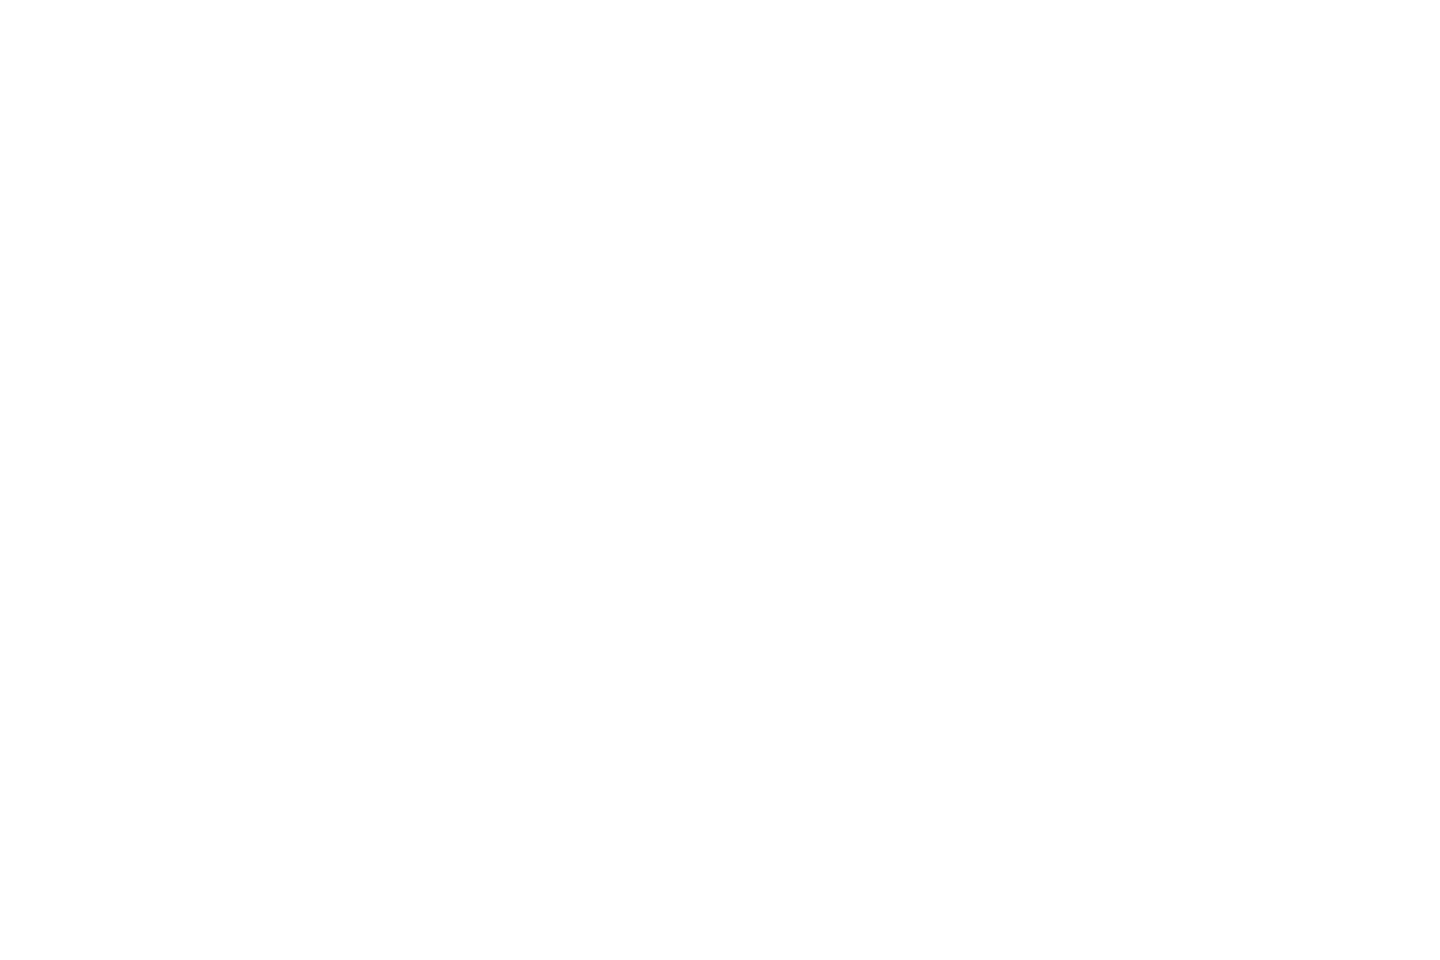

<IPython.core.display.Javascript object>


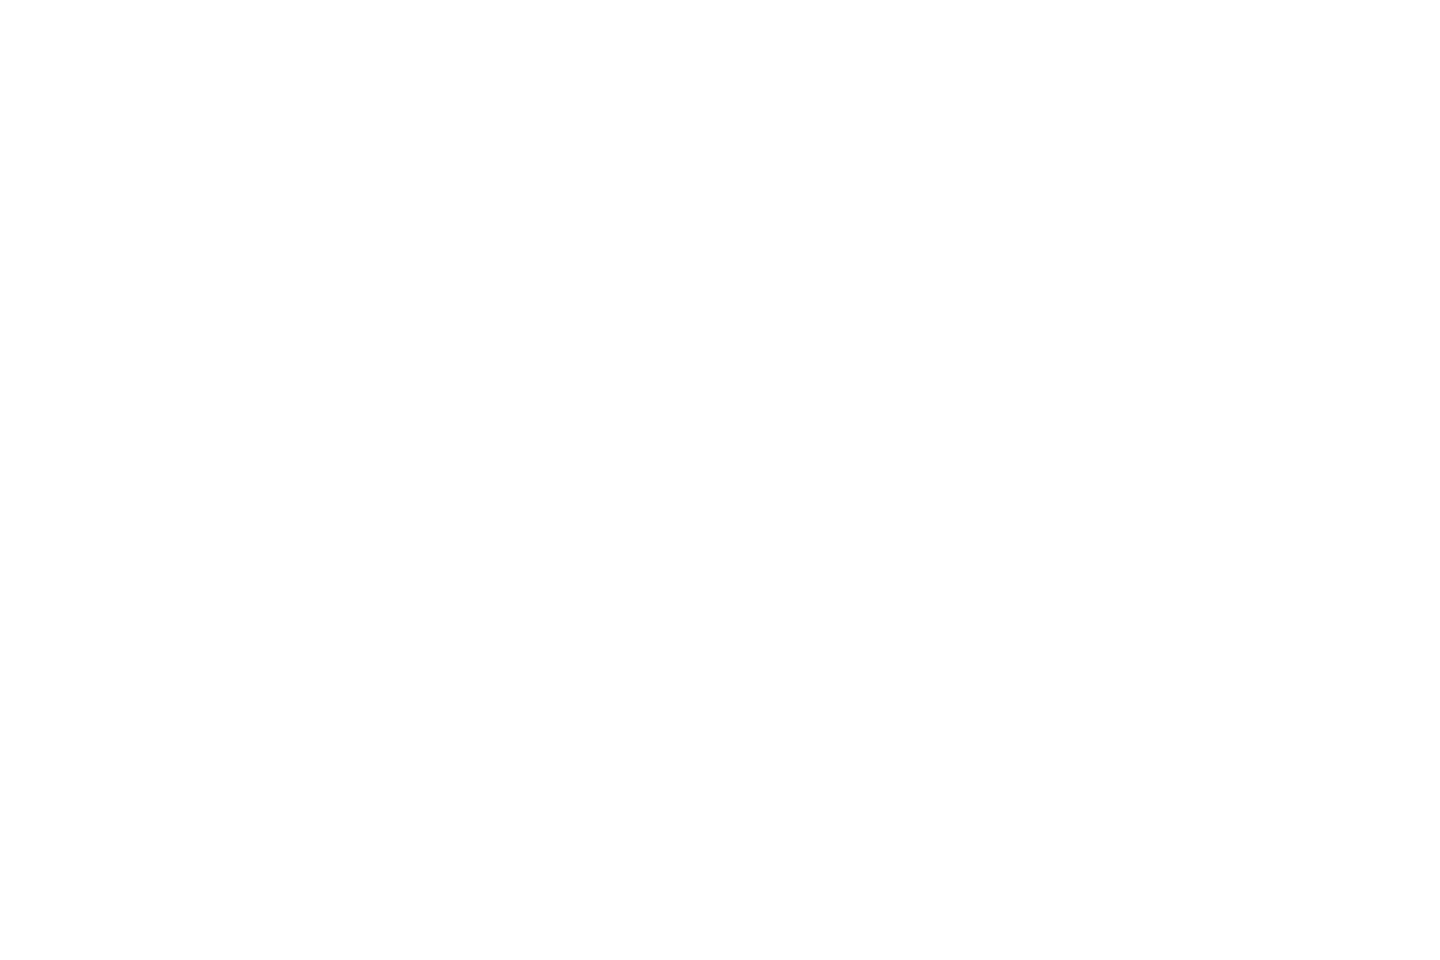

<IPython.core.display.Javascript object>


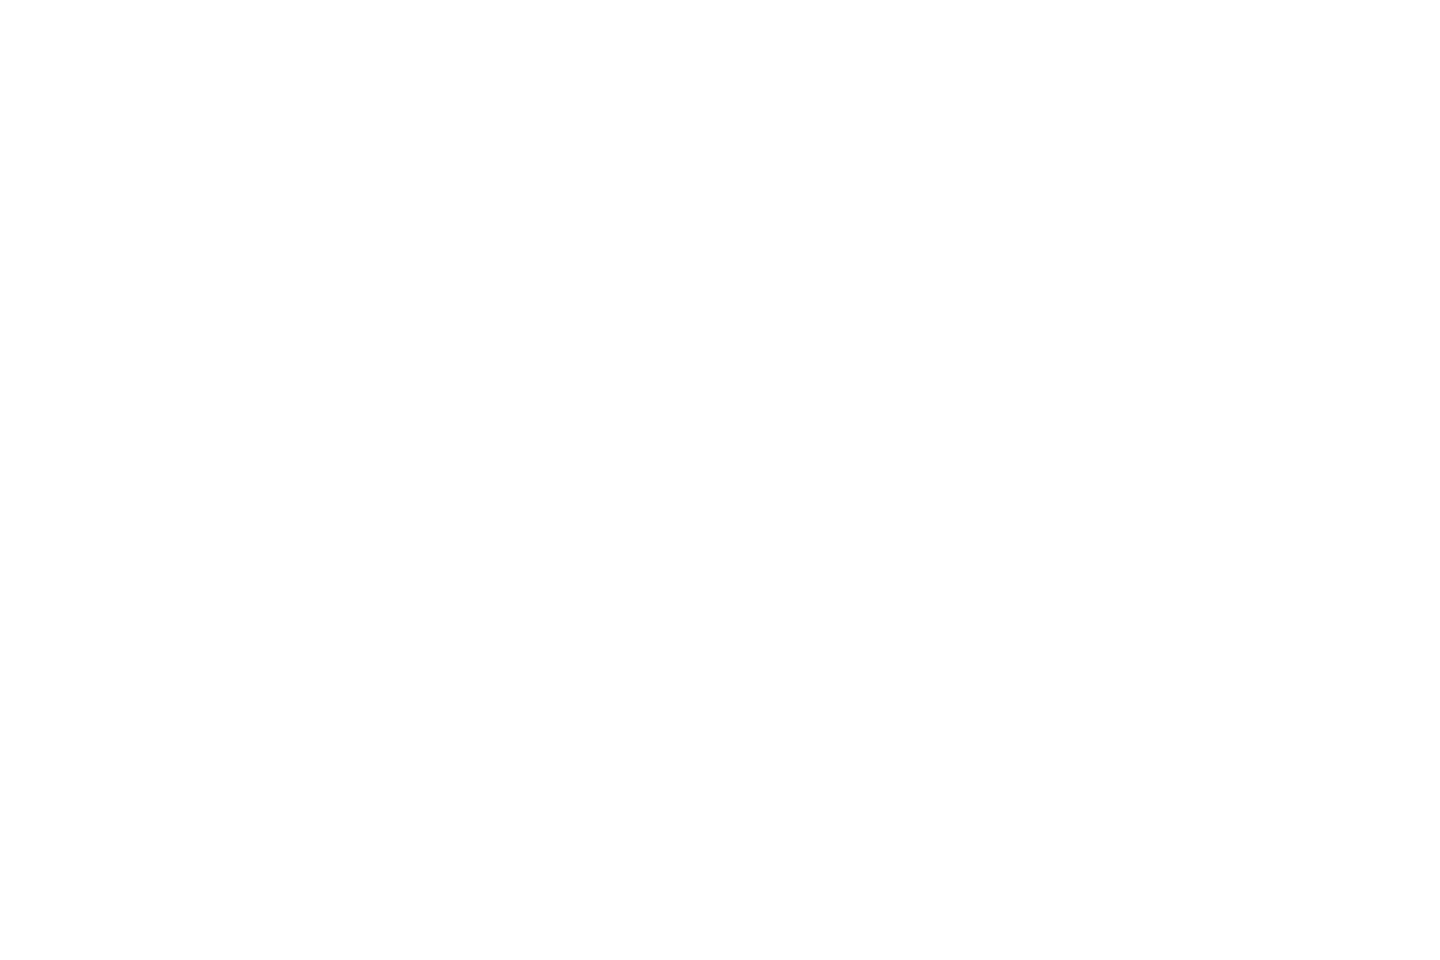

<IPython.core.display.Javascript object>


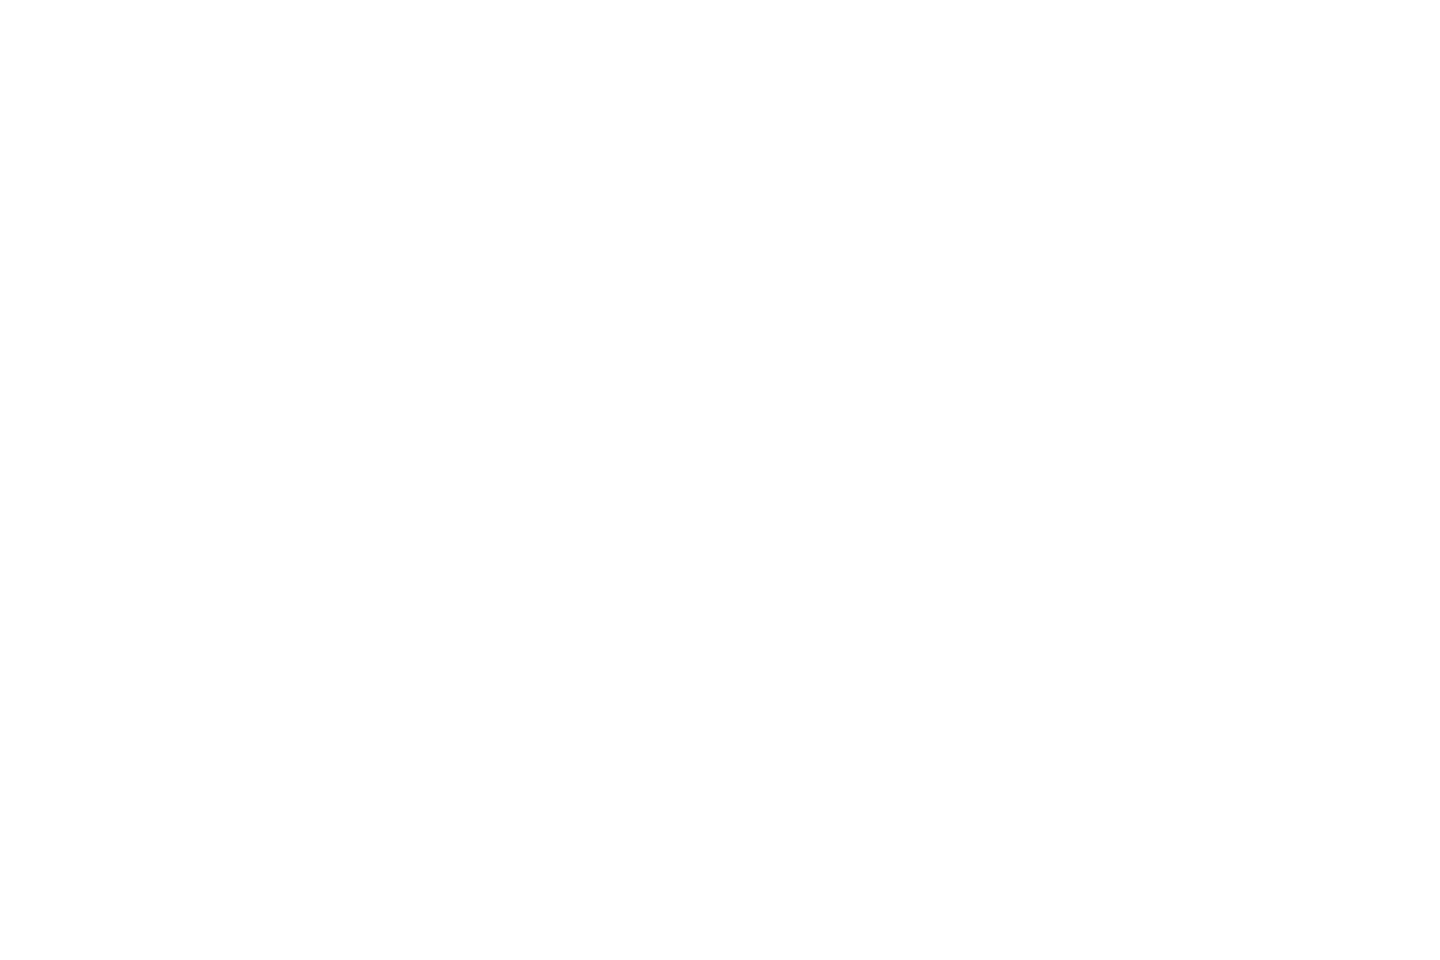

<IPython.core.display.Javascript object>


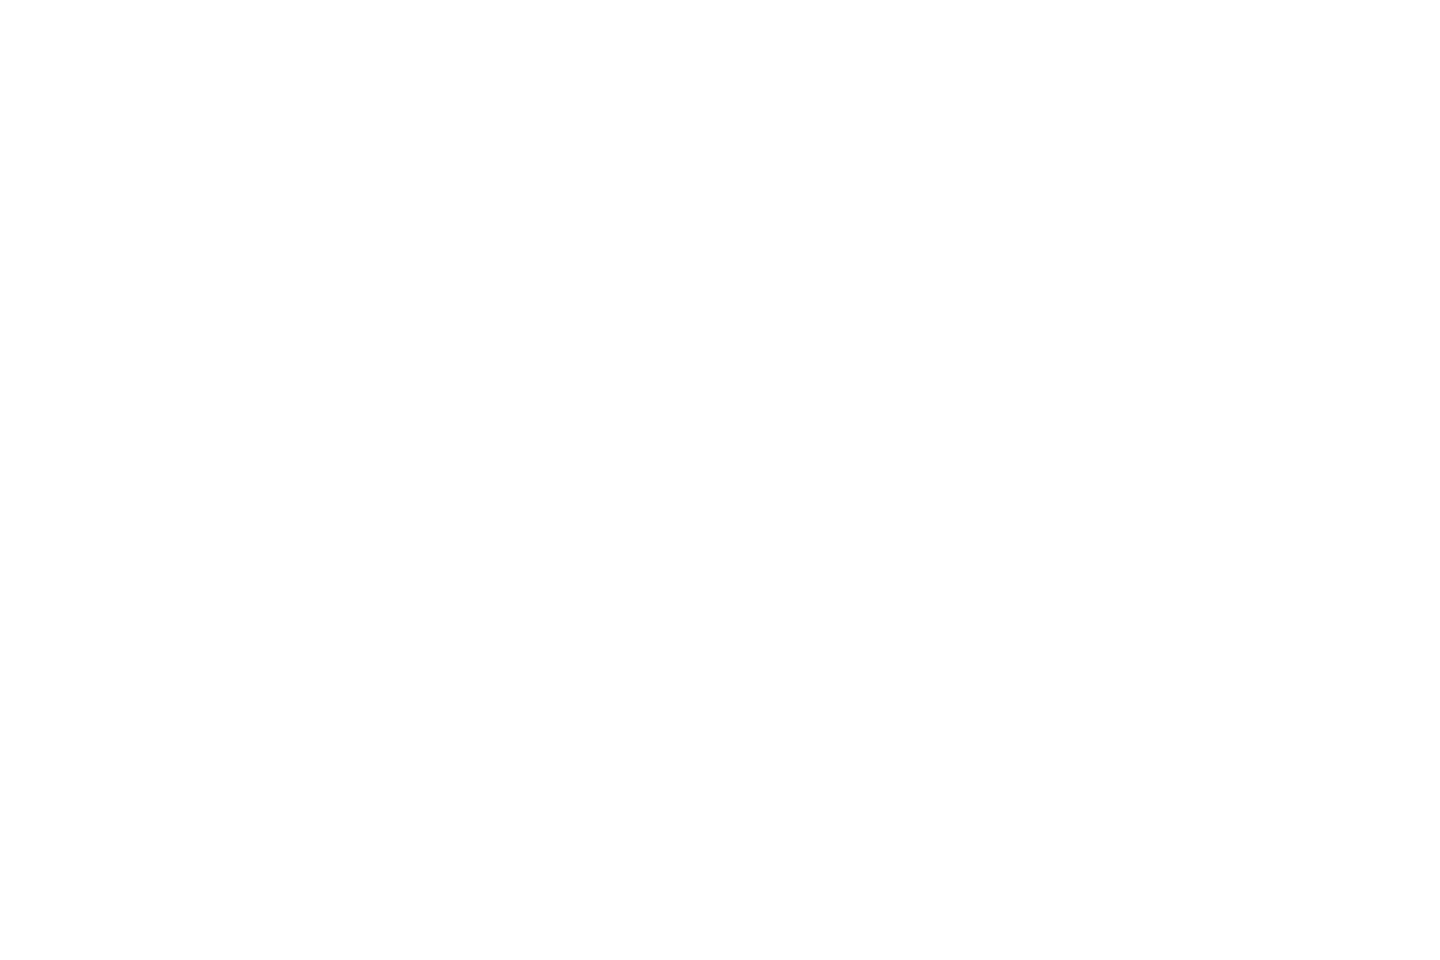

<IPython.core.display.Javascript object>


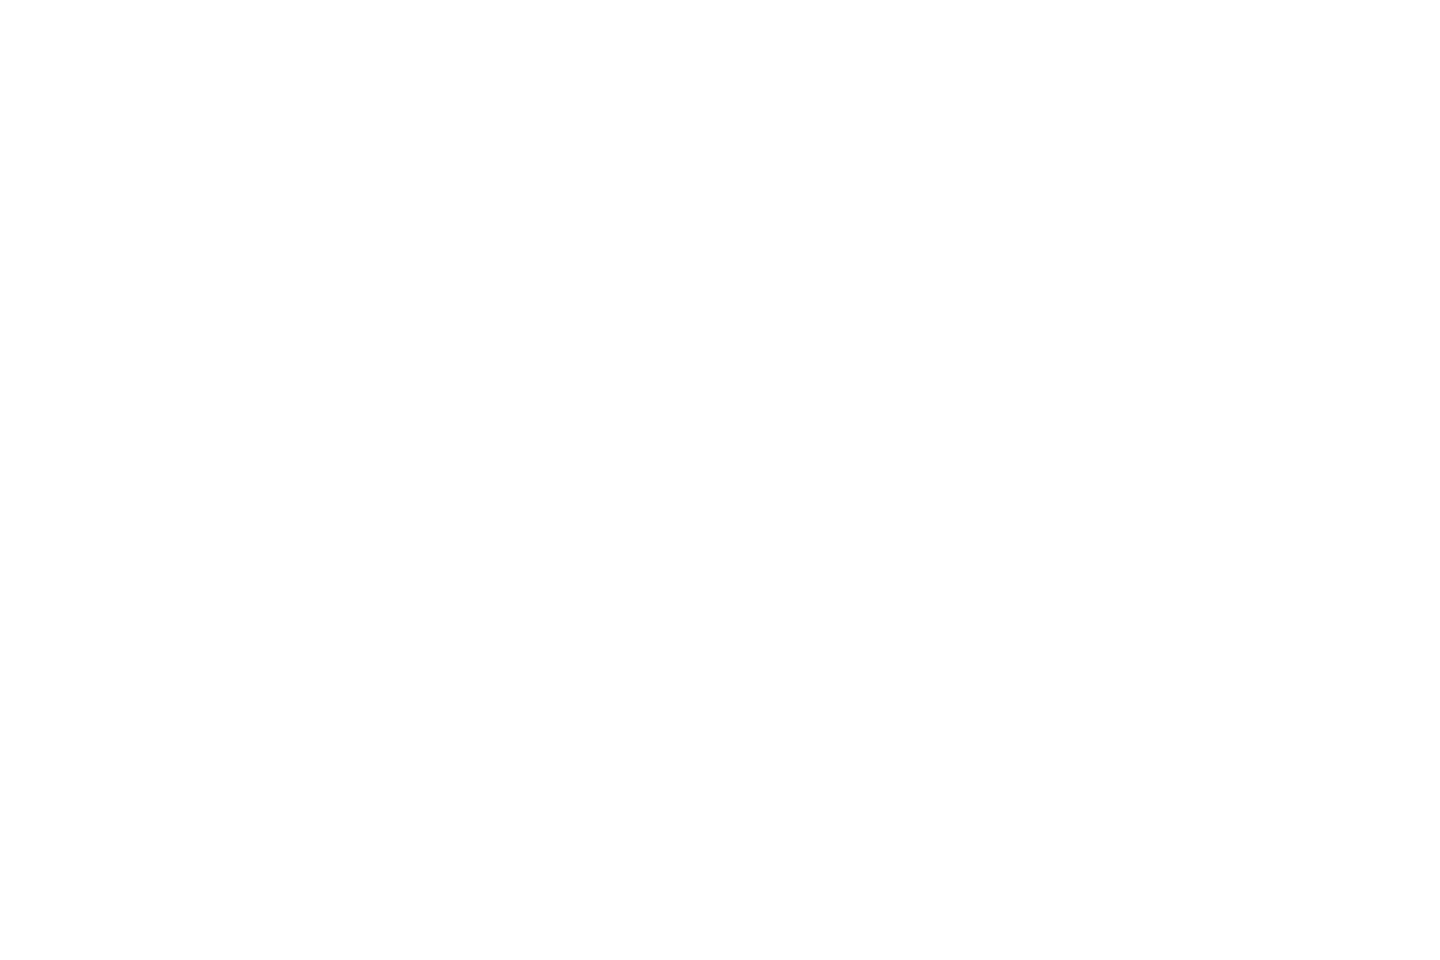

Plot TFR for epoch:  CpeOnset


<IPython.core.display.Javascript object>


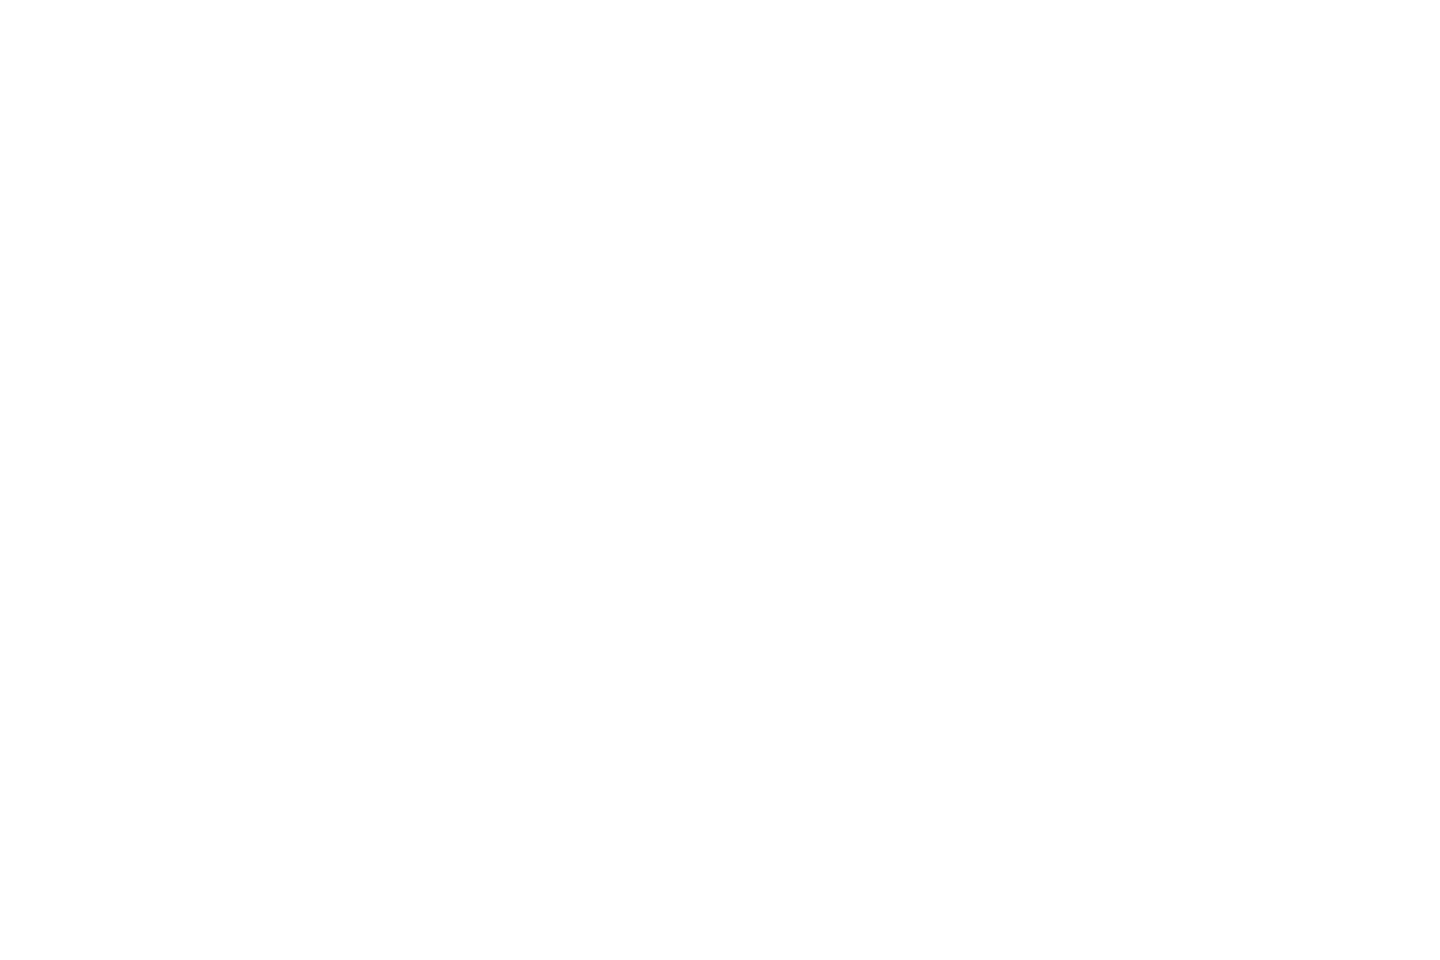

<IPython.core.display.Javascript object>


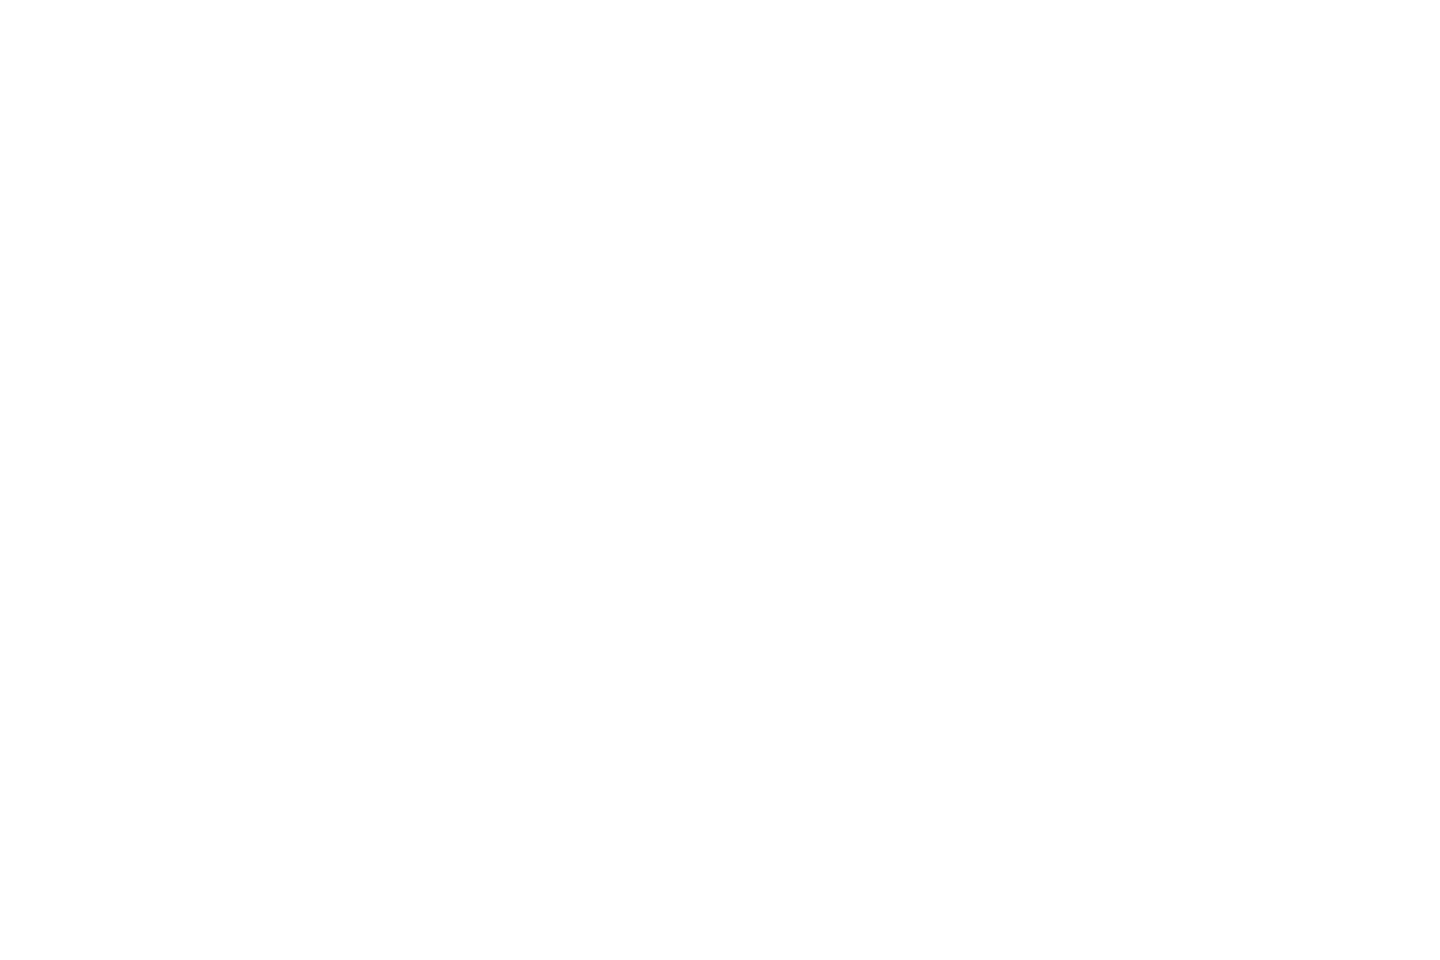

<IPython.core.display.Javascript object>


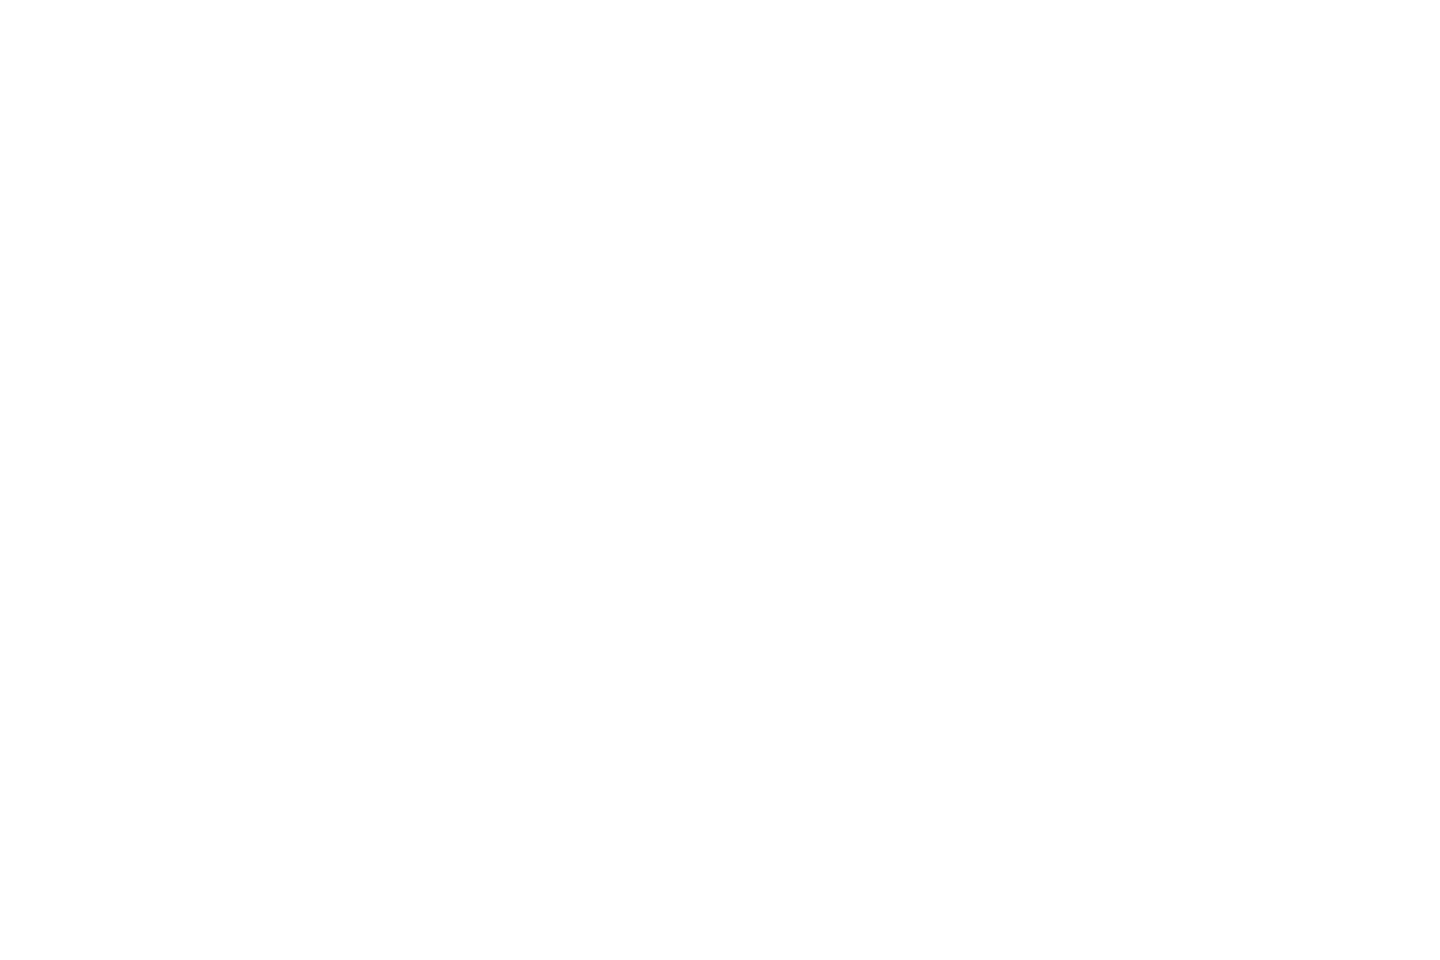

<IPython.core.display.Javascript object>


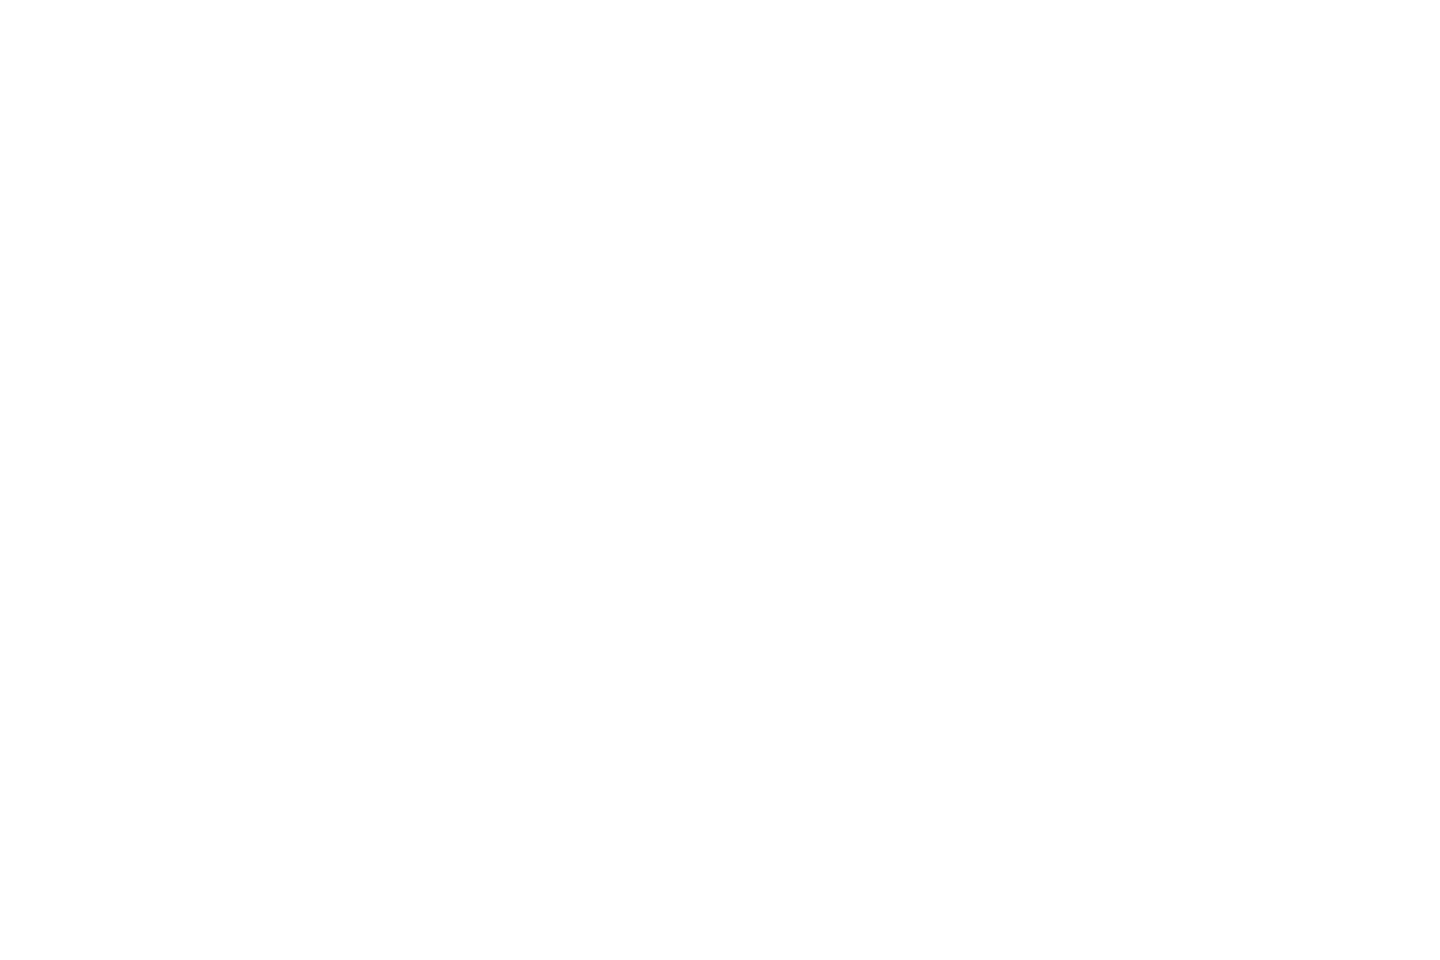

<IPython.core.display.Javascript object>


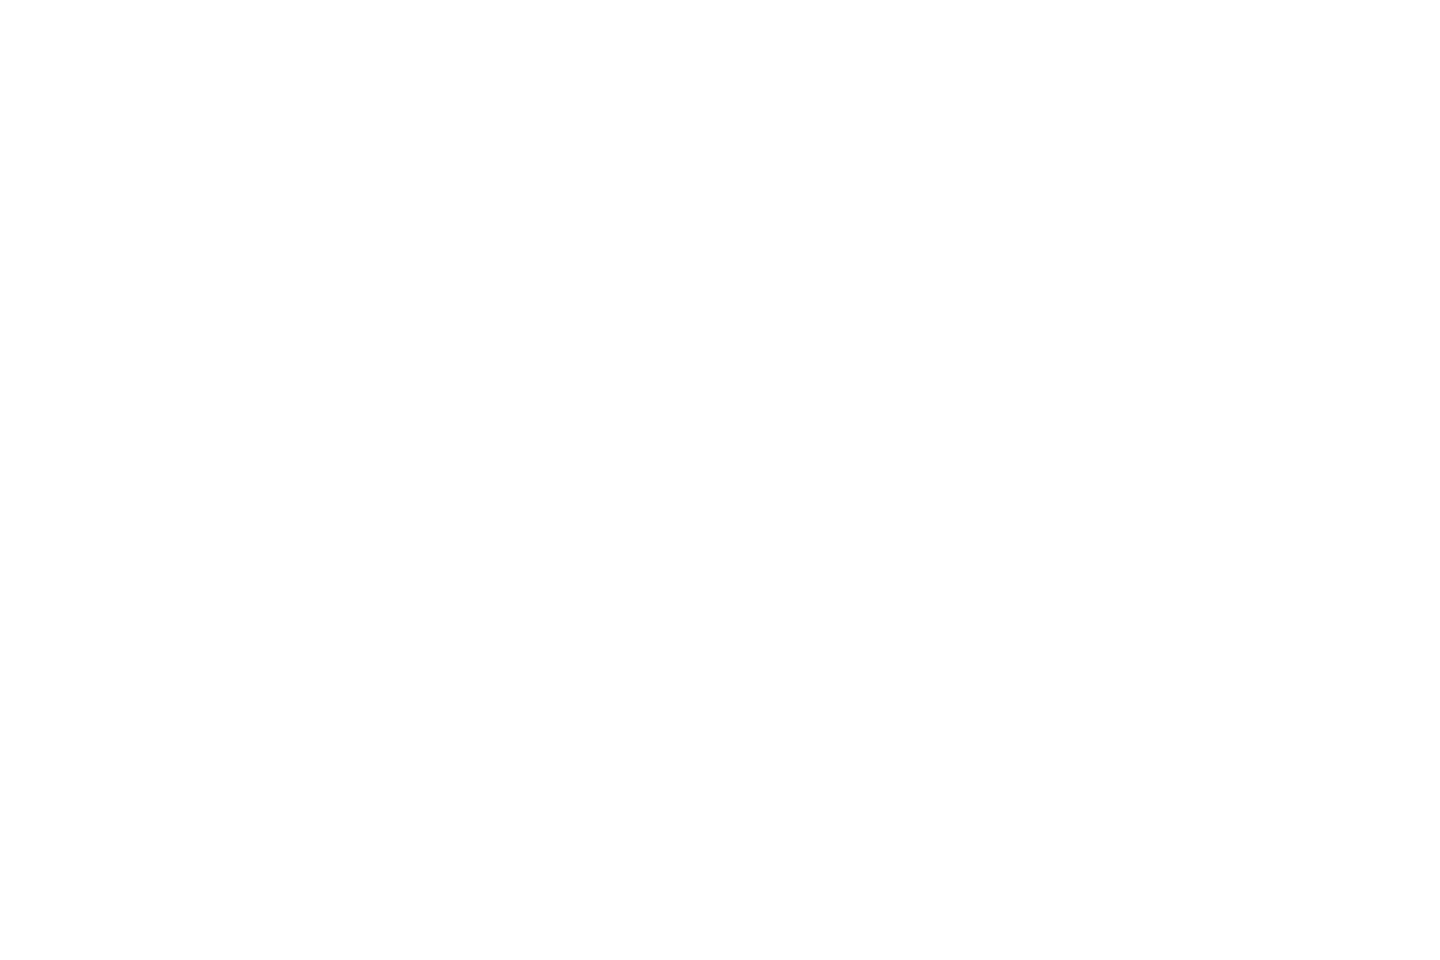

<IPython.core.display.Javascript object>


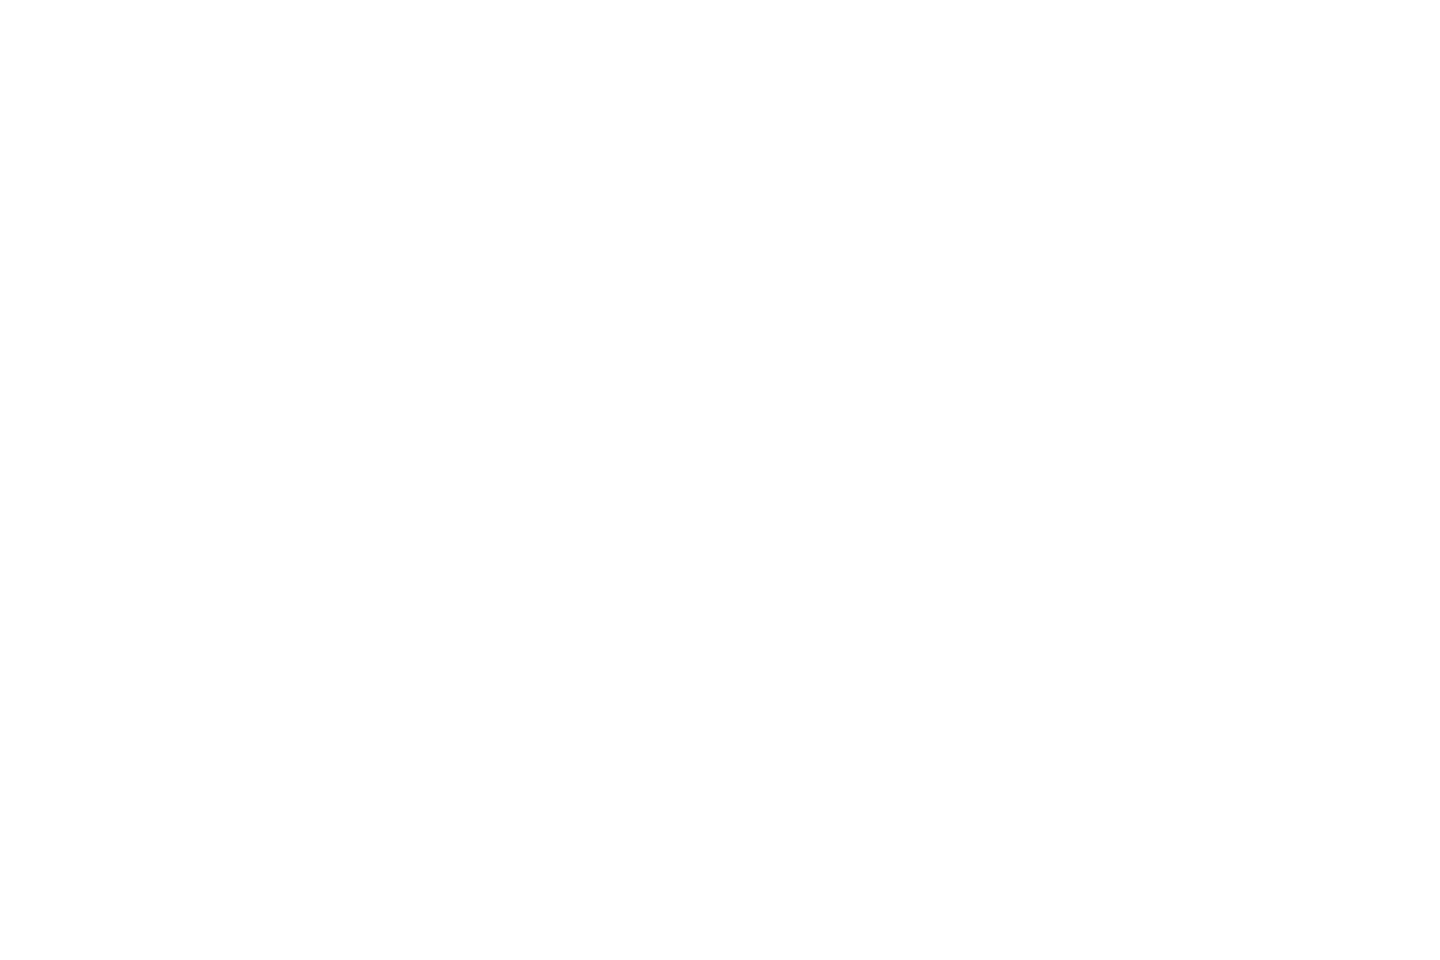

<IPython.core.display.Javascript object>


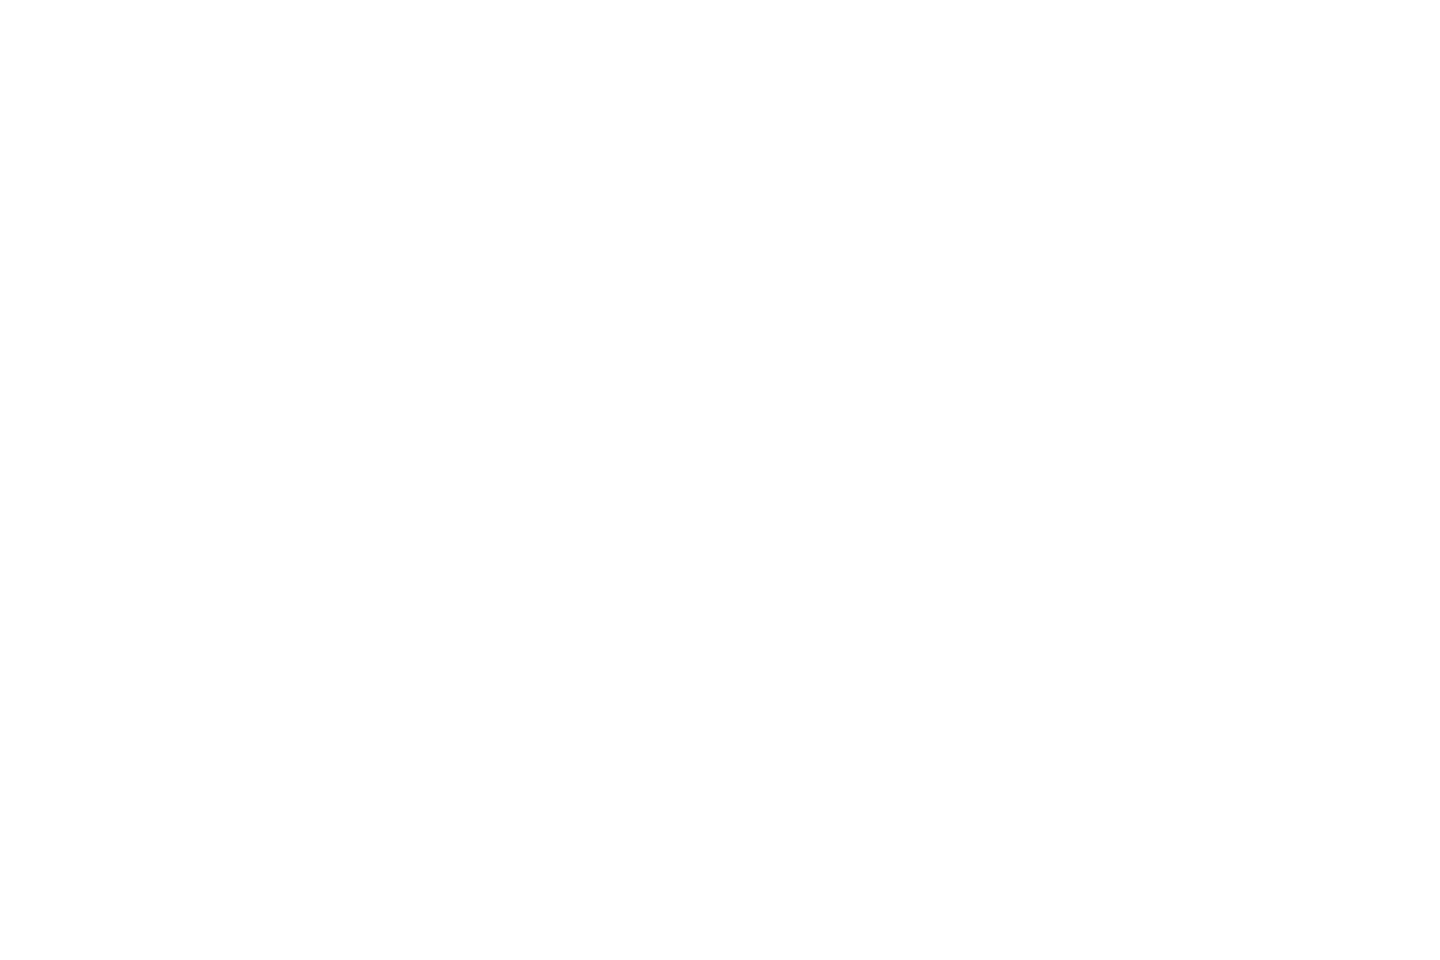

<IPython.core.display.Javascript object>


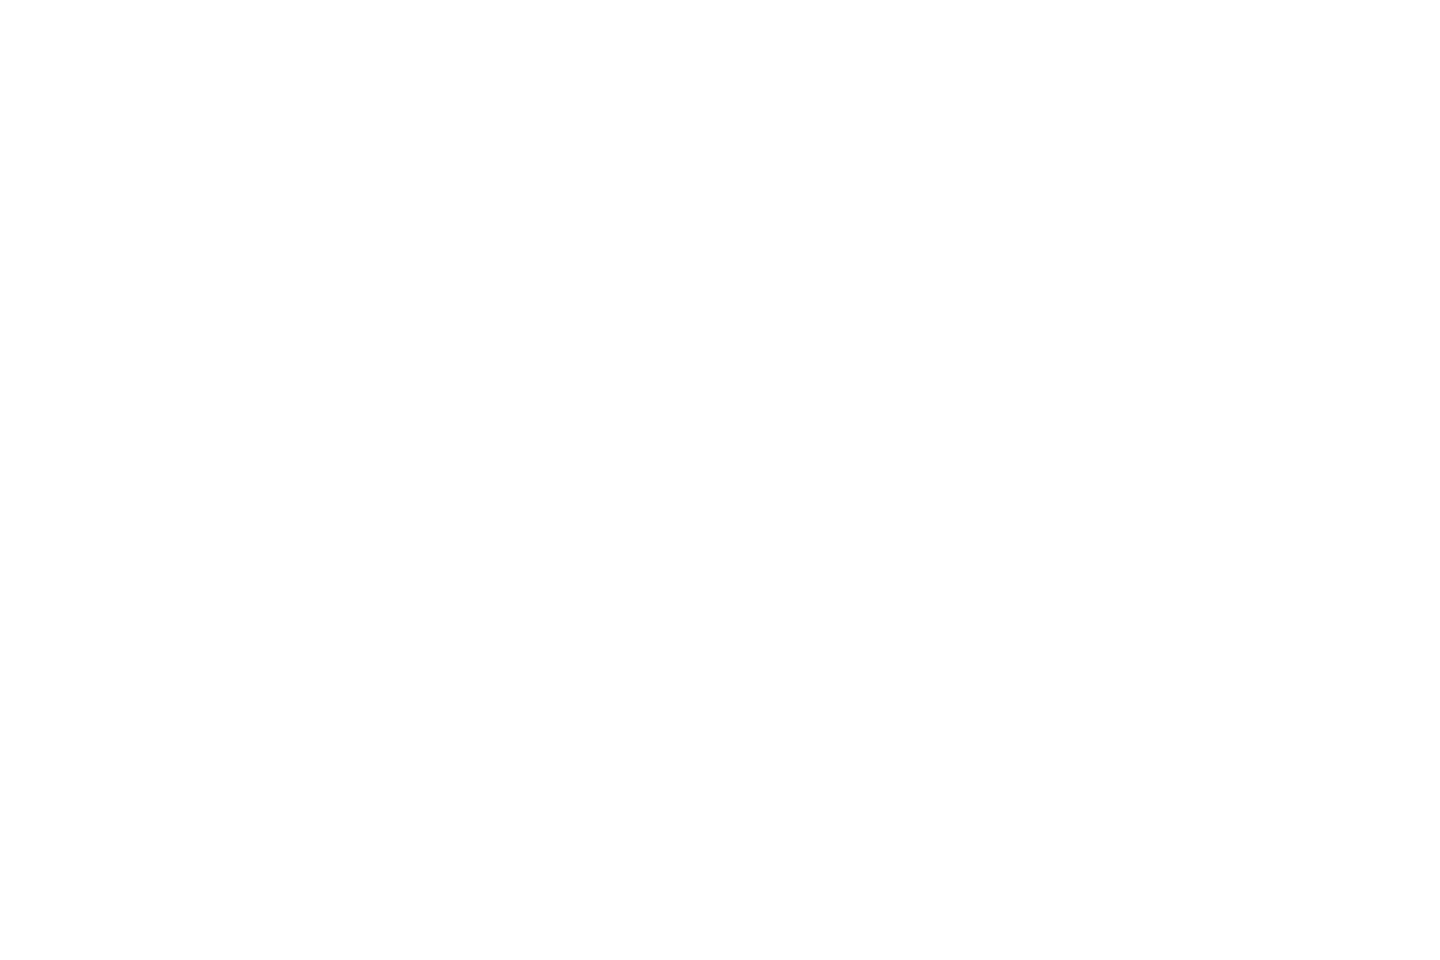

<IPython.core.display.Javascript object>


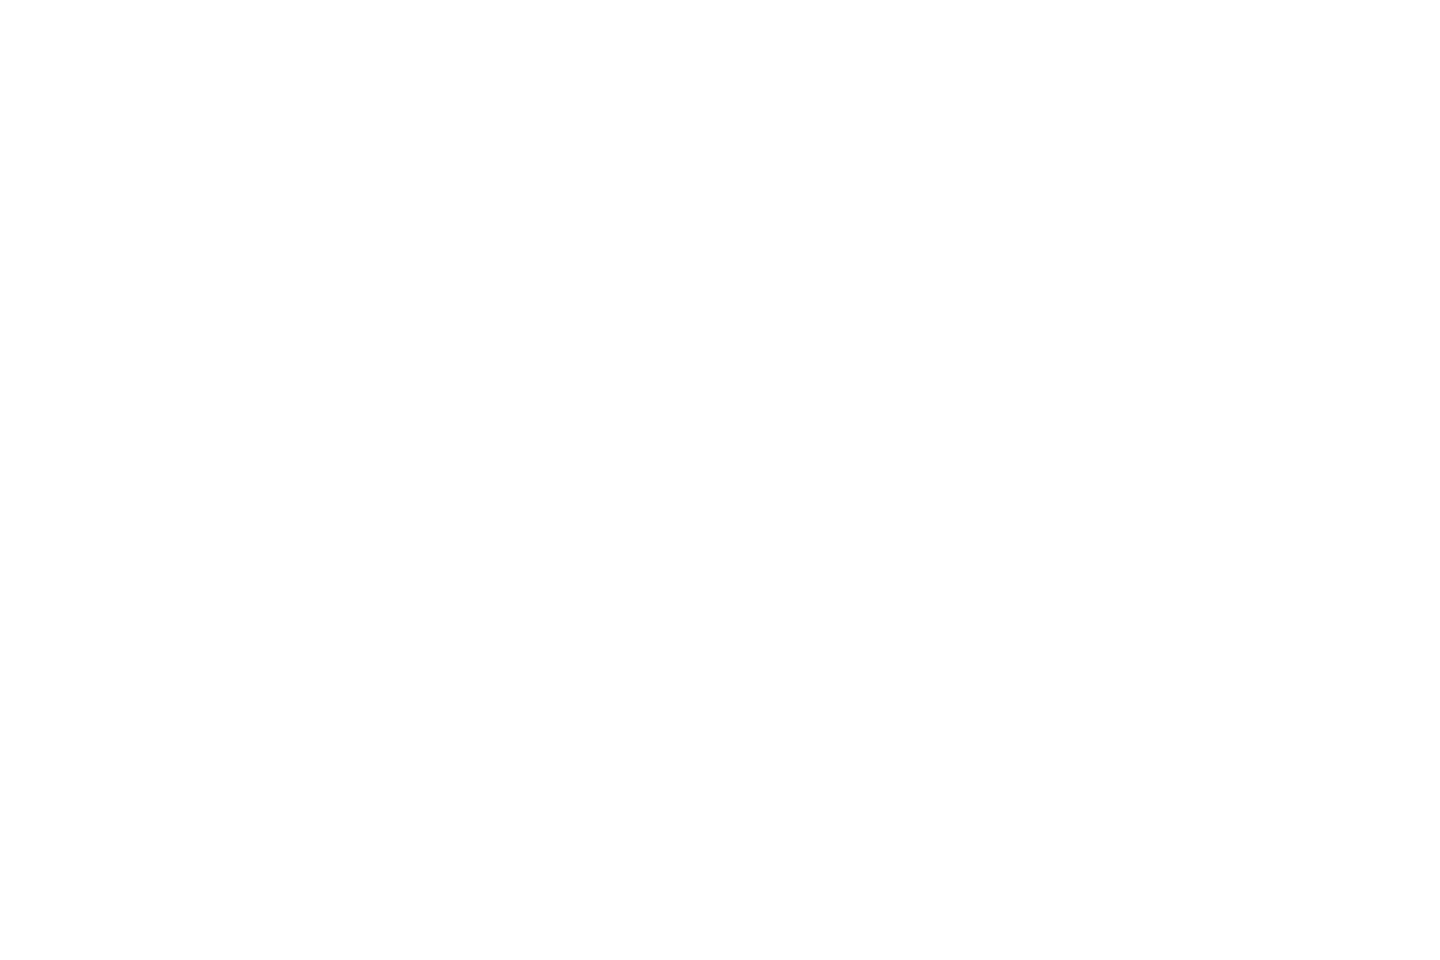

<IPython.core.display.Javascript object>


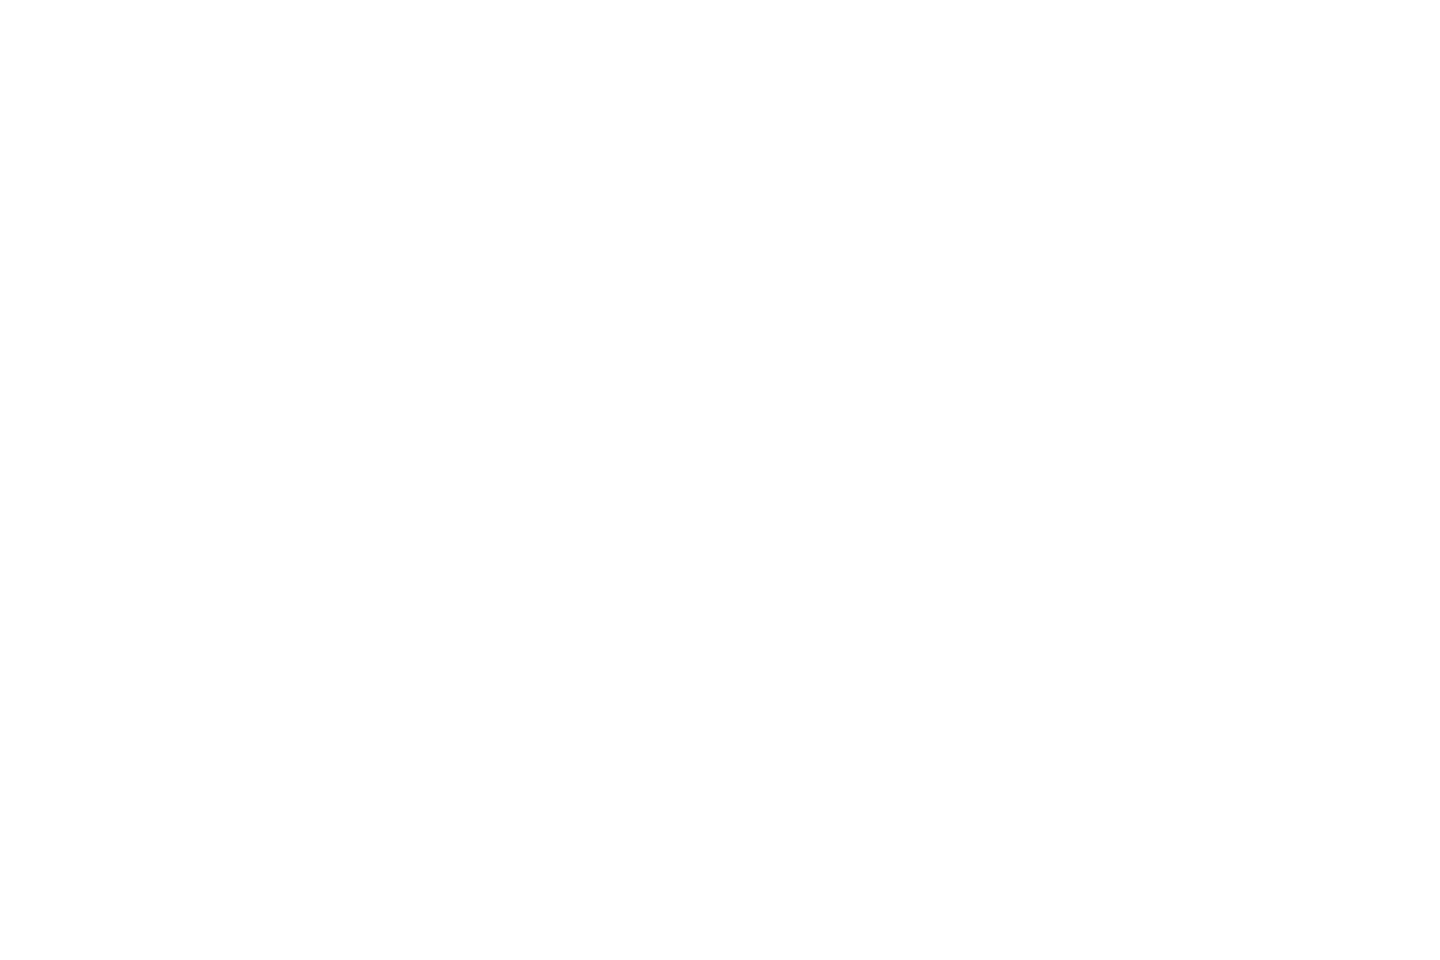

<IPython.core.display.Javascript object>


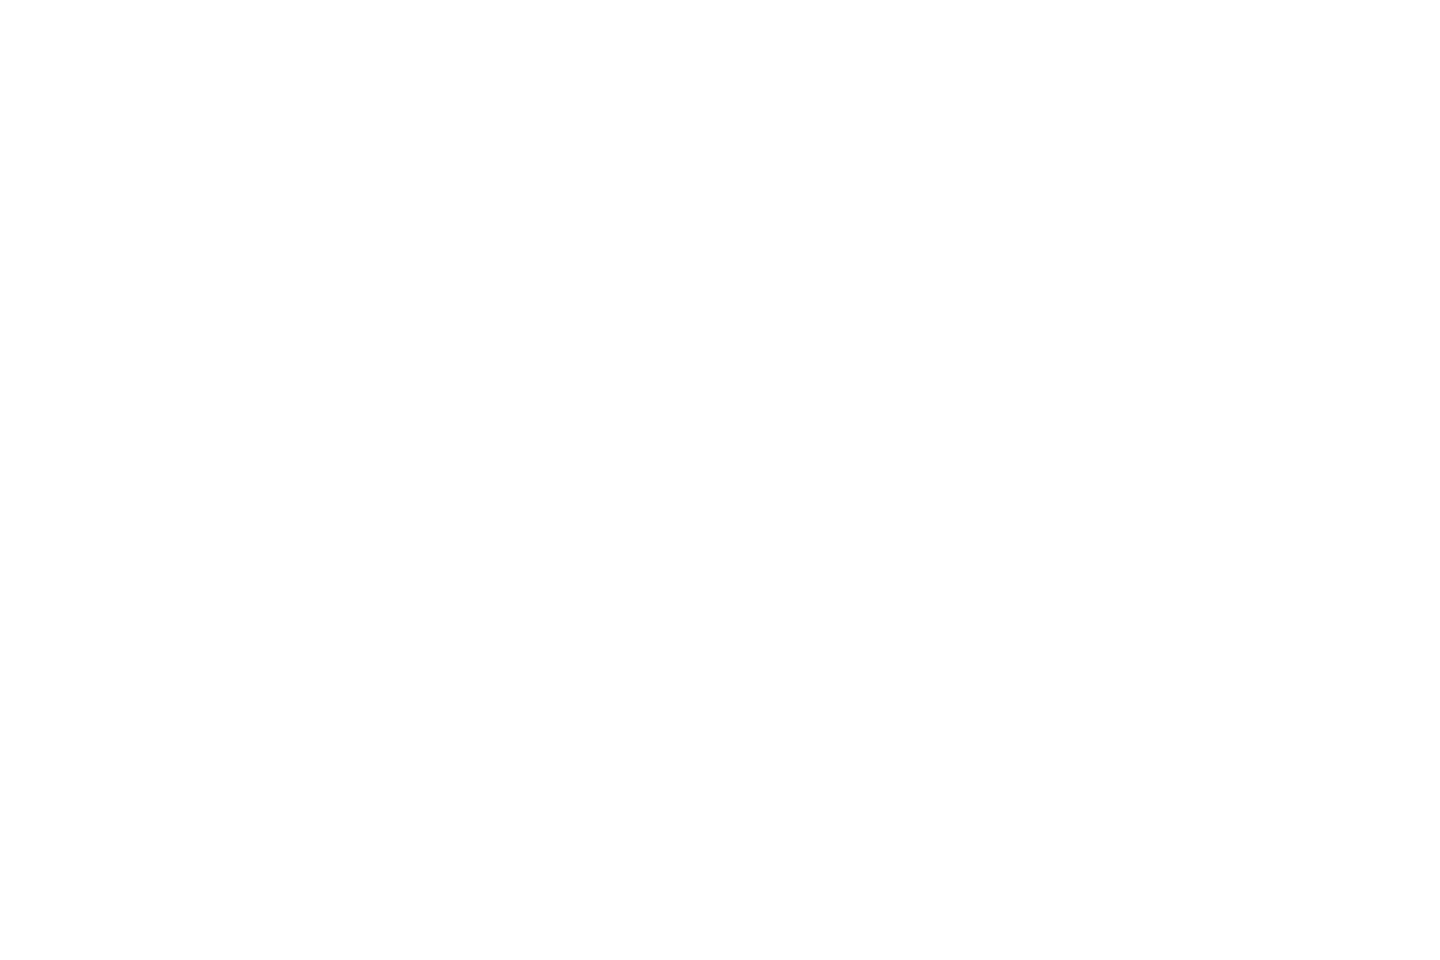

<IPython.core.display.Javascript object>


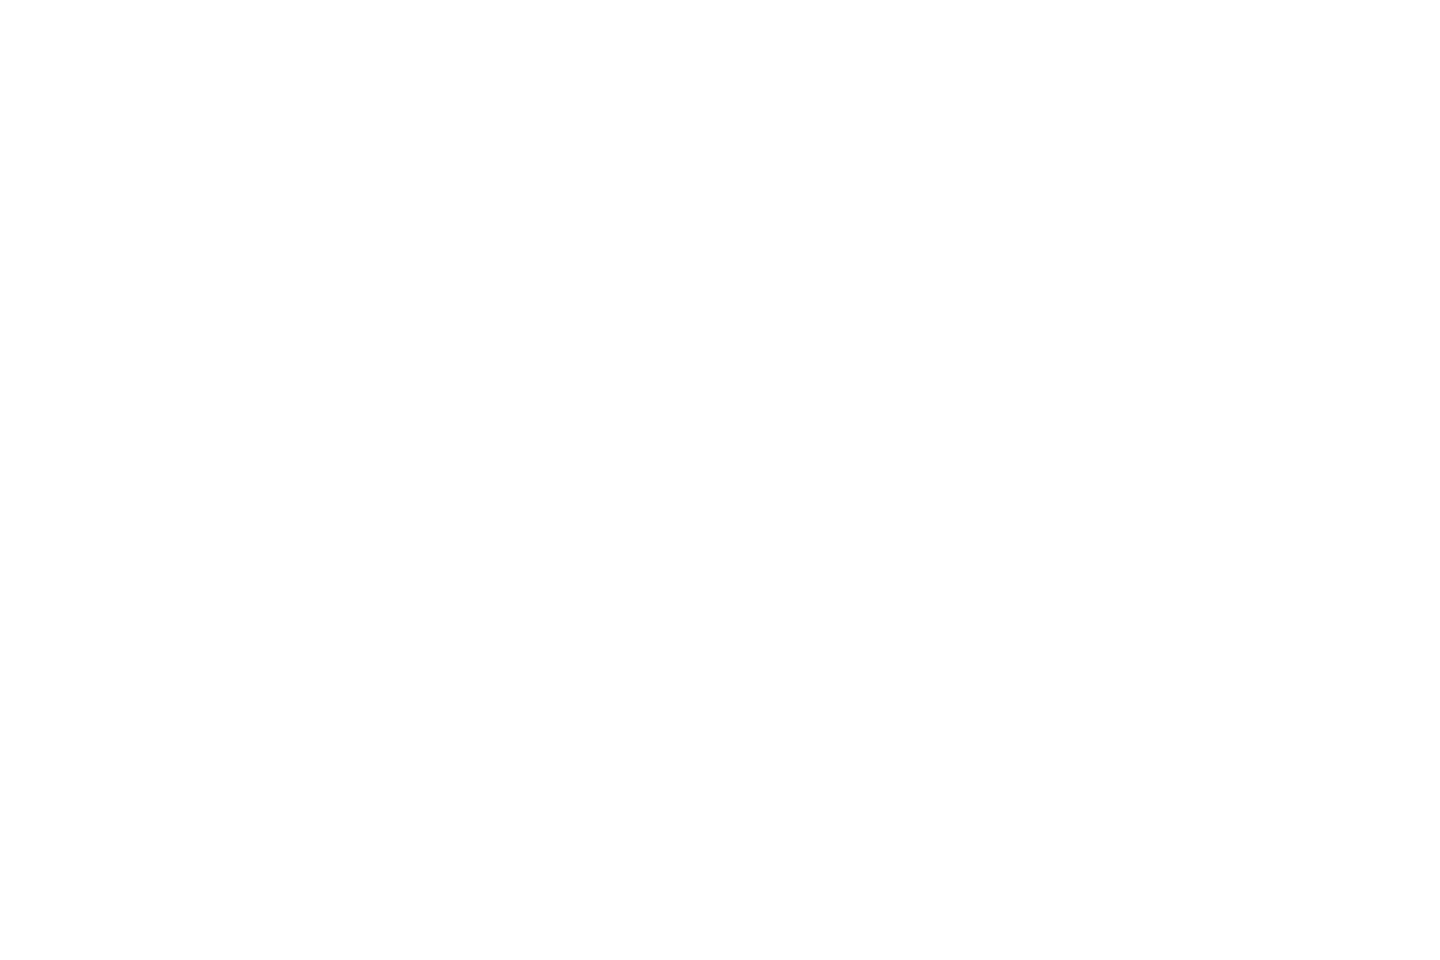

<IPython.core.display.Javascript object>


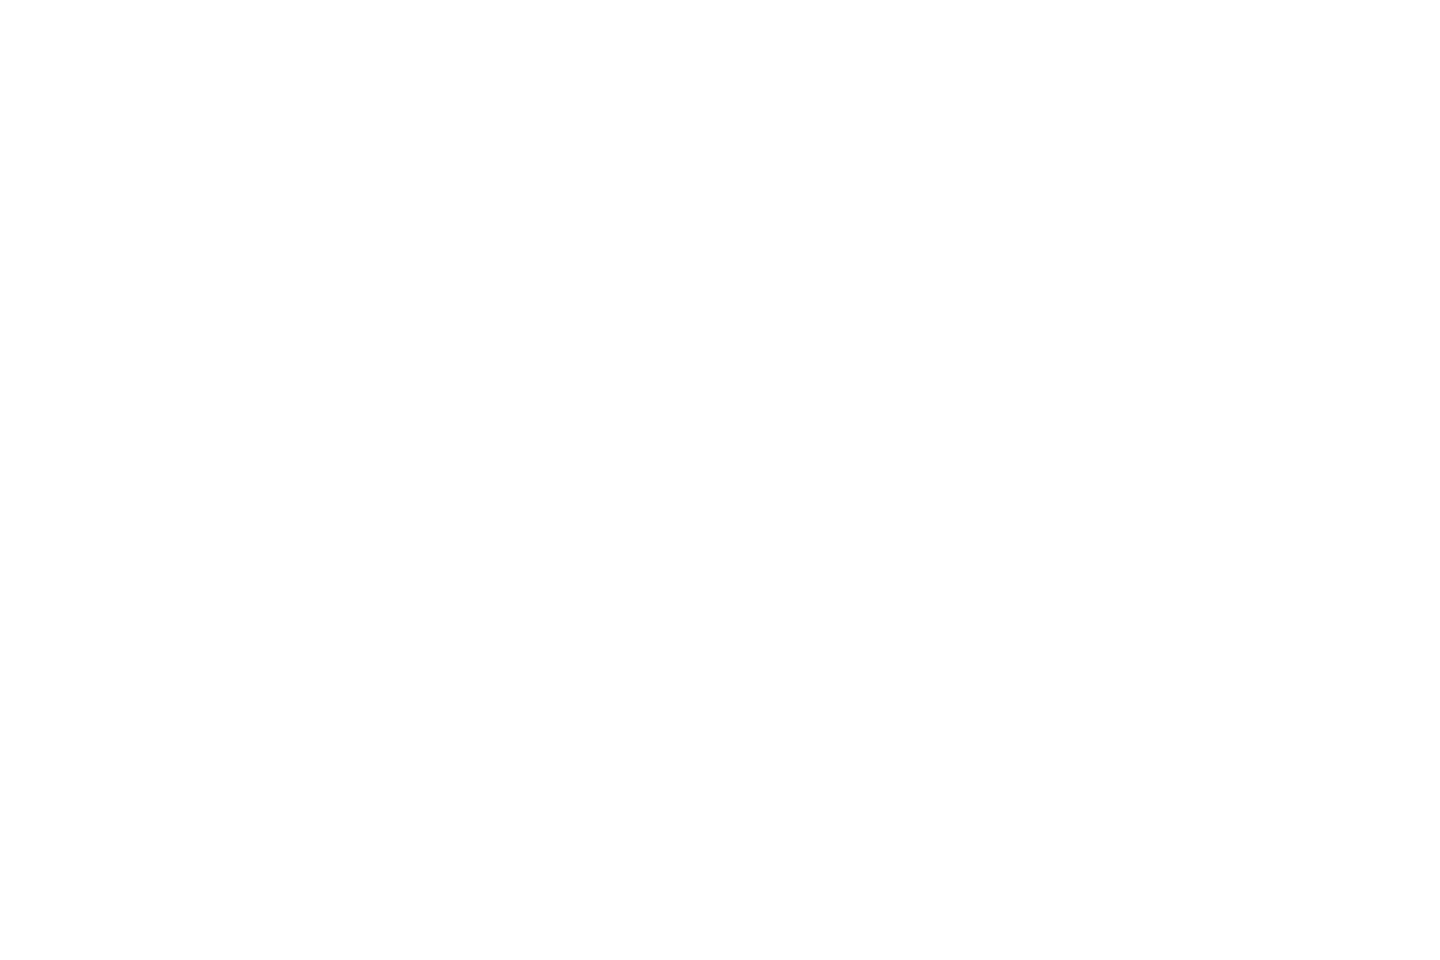

<IPython.core.display.Javascript object>


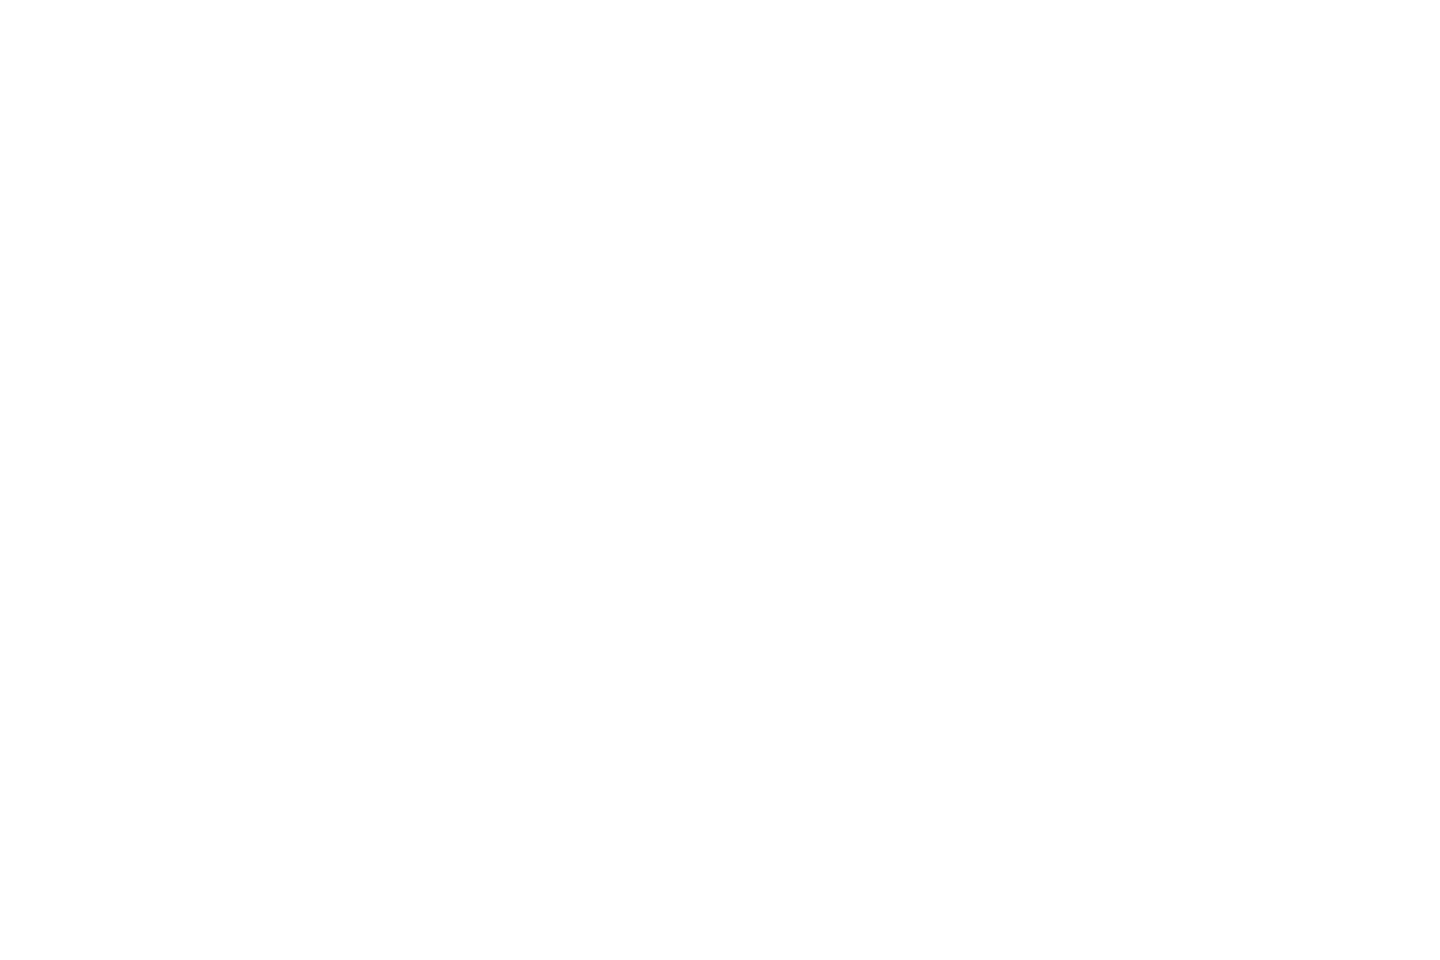

<IPython.core.display.Javascript object>


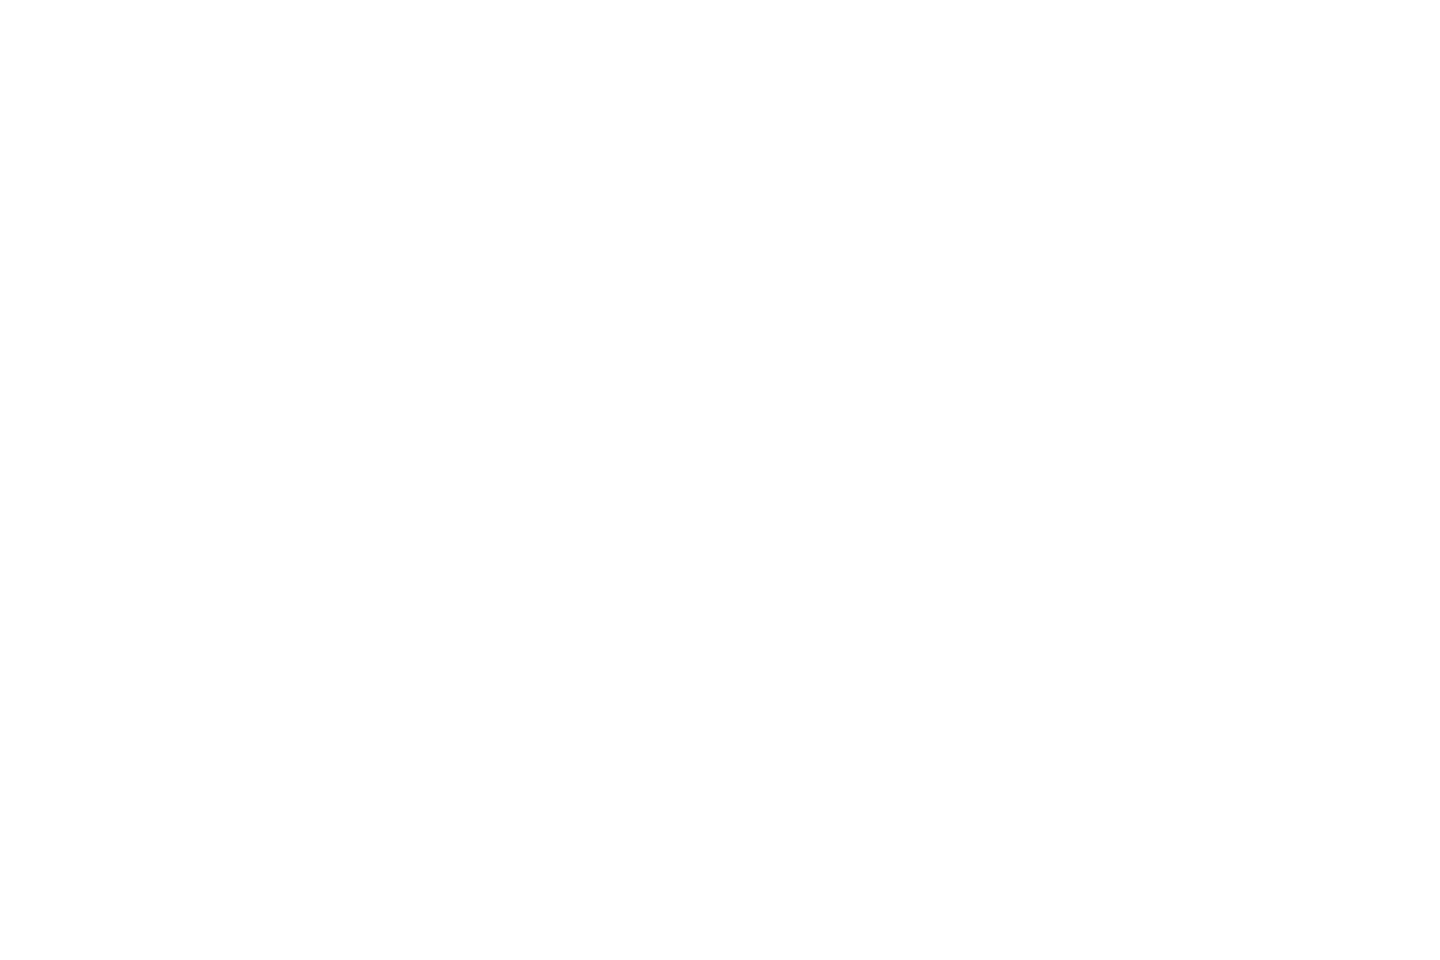

<IPython.core.display.Javascript object>


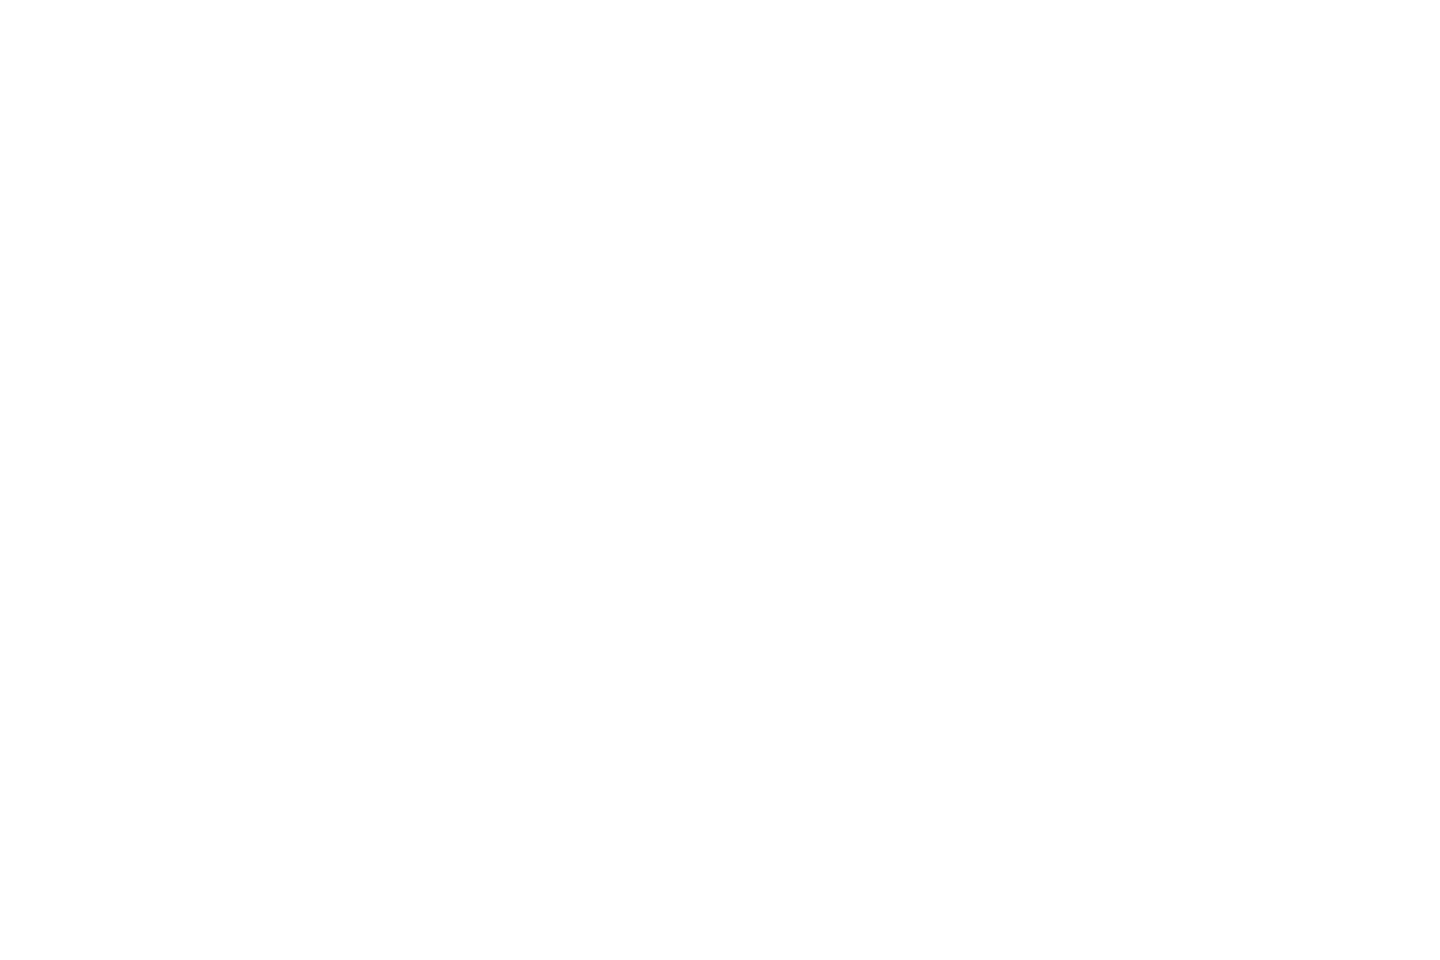

<IPython.core.display.Javascript object>


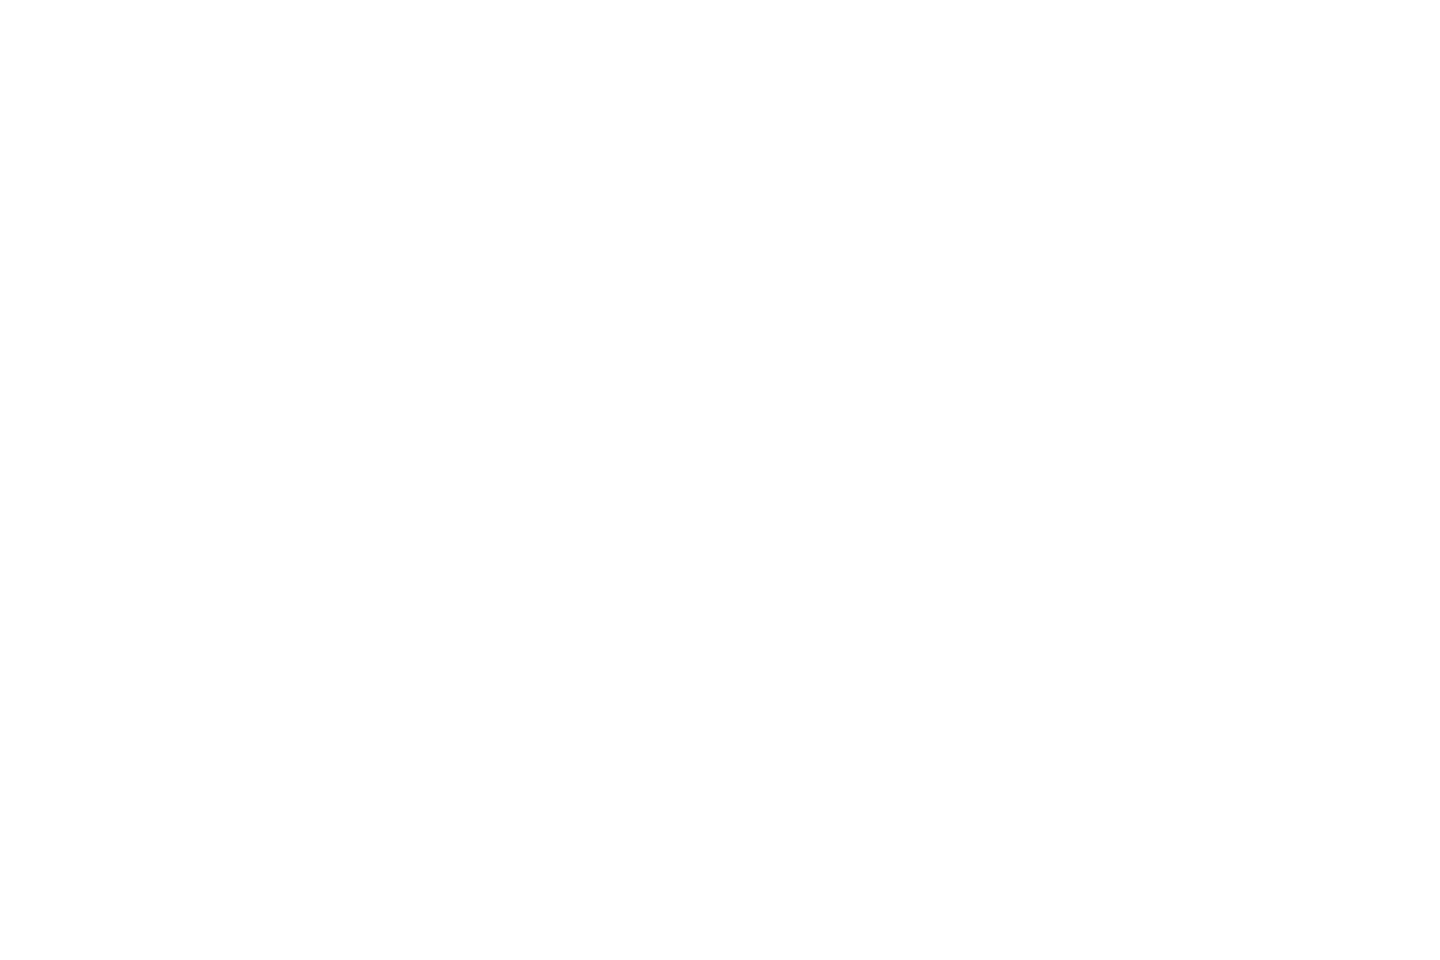

<IPython.core.display.Javascript object>


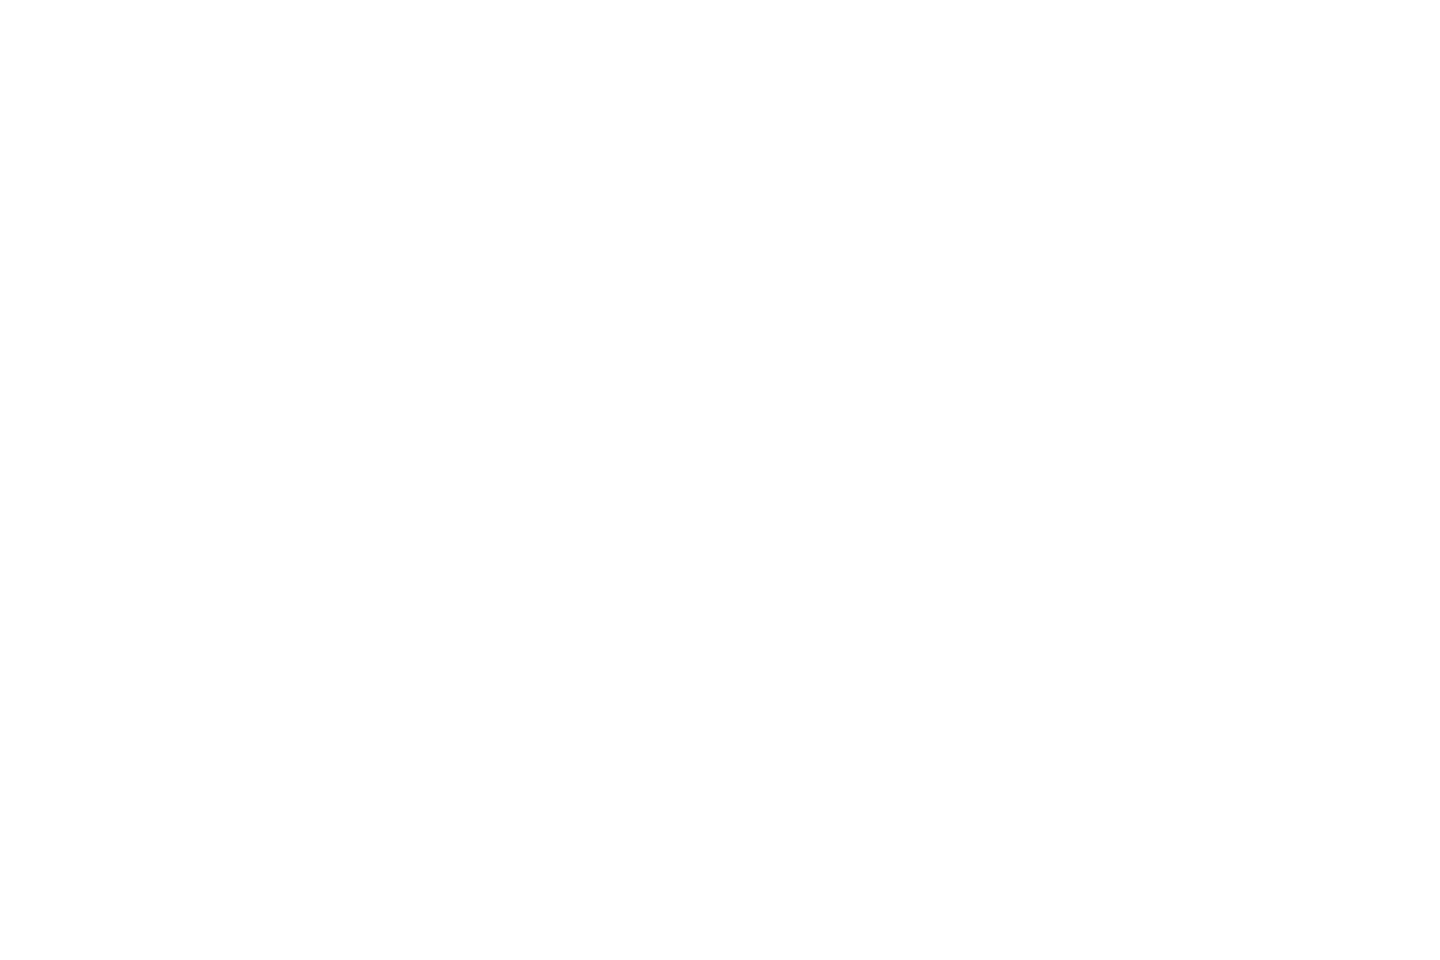

<IPython.core.display.Javascript object>


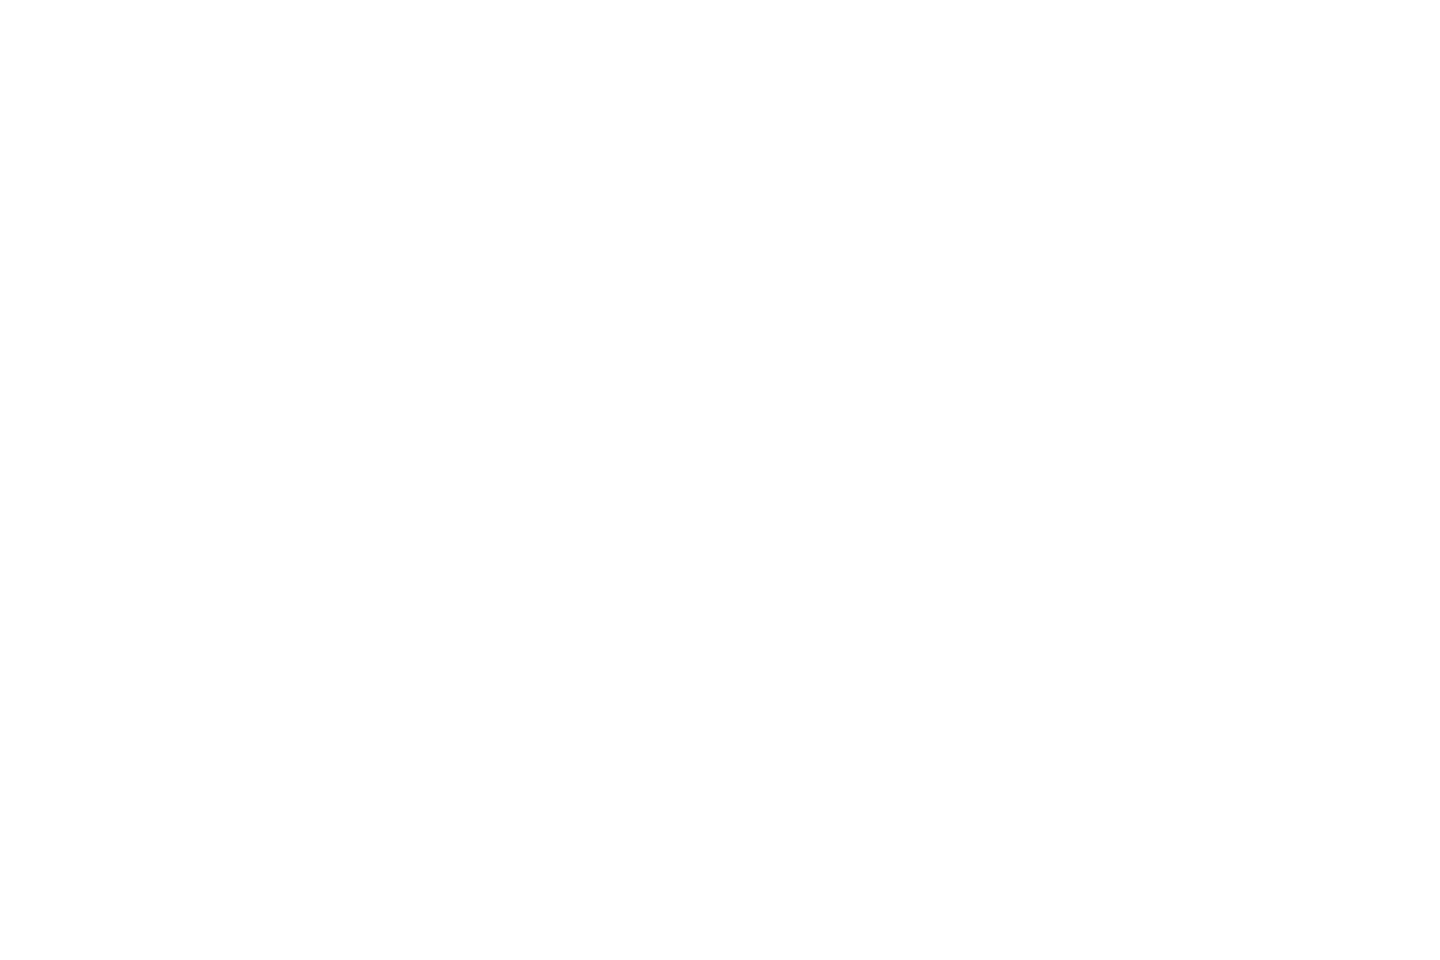

<IPython.core.display.Javascript object>


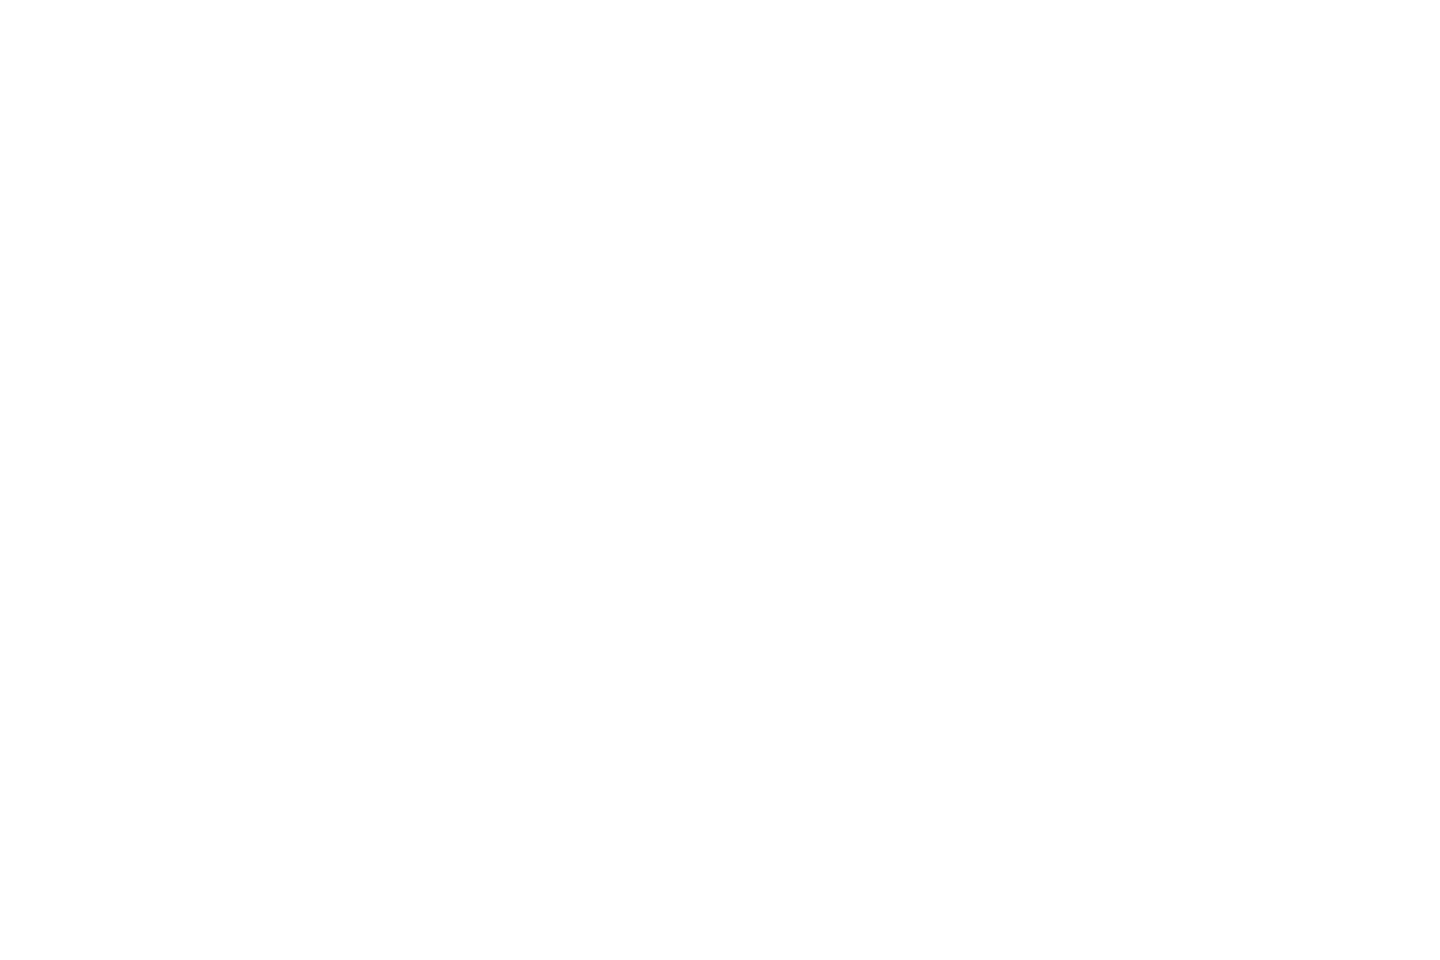

<IPython.core.display.Javascript object>


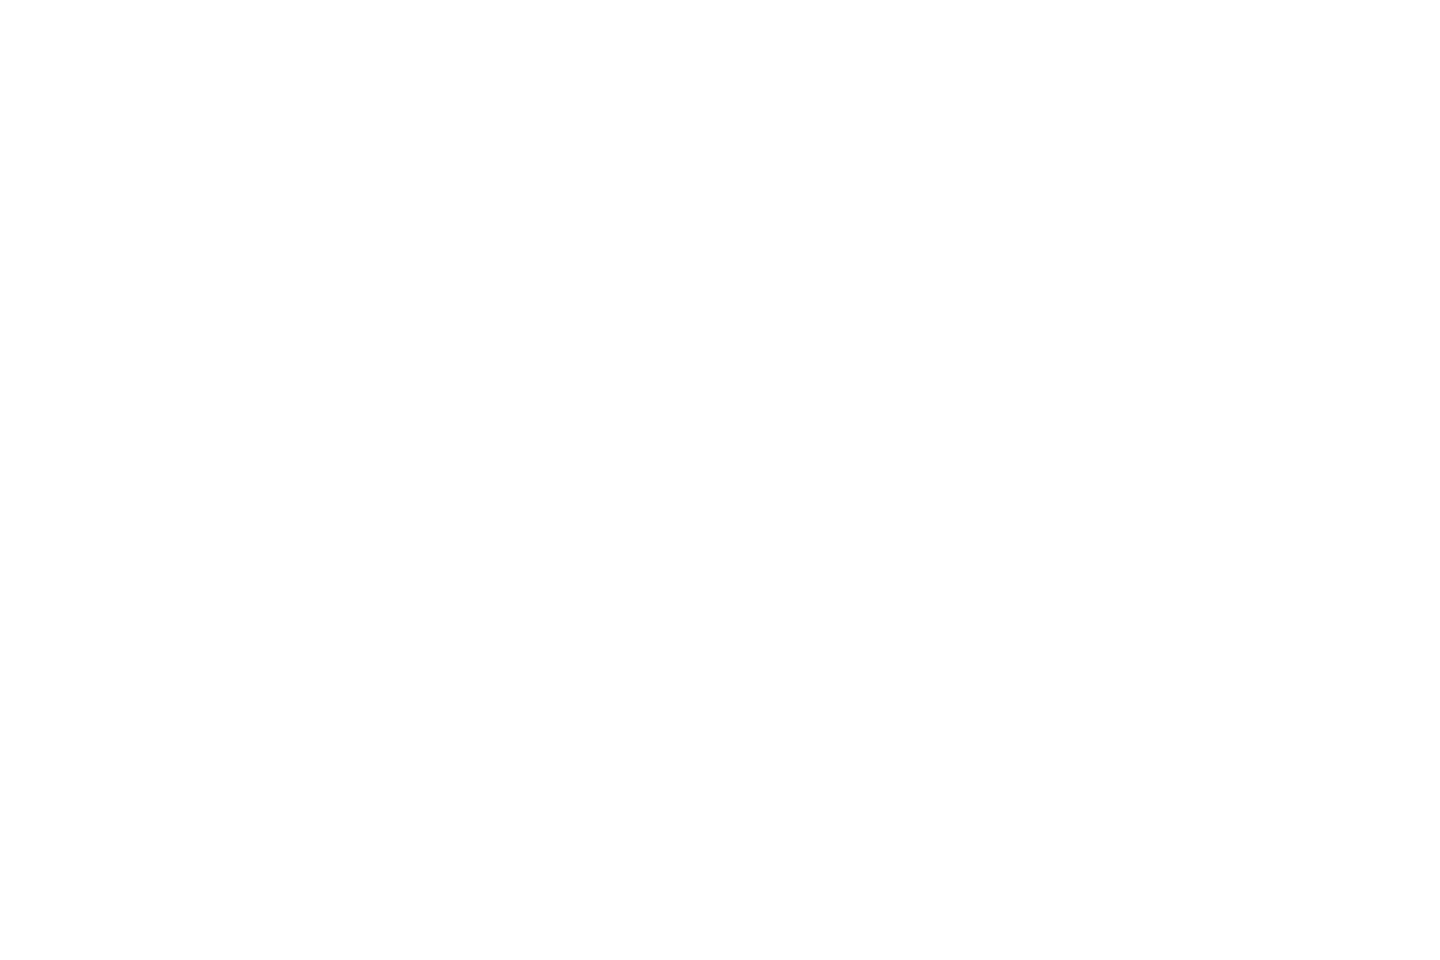

<IPython.core.display.Javascript object>


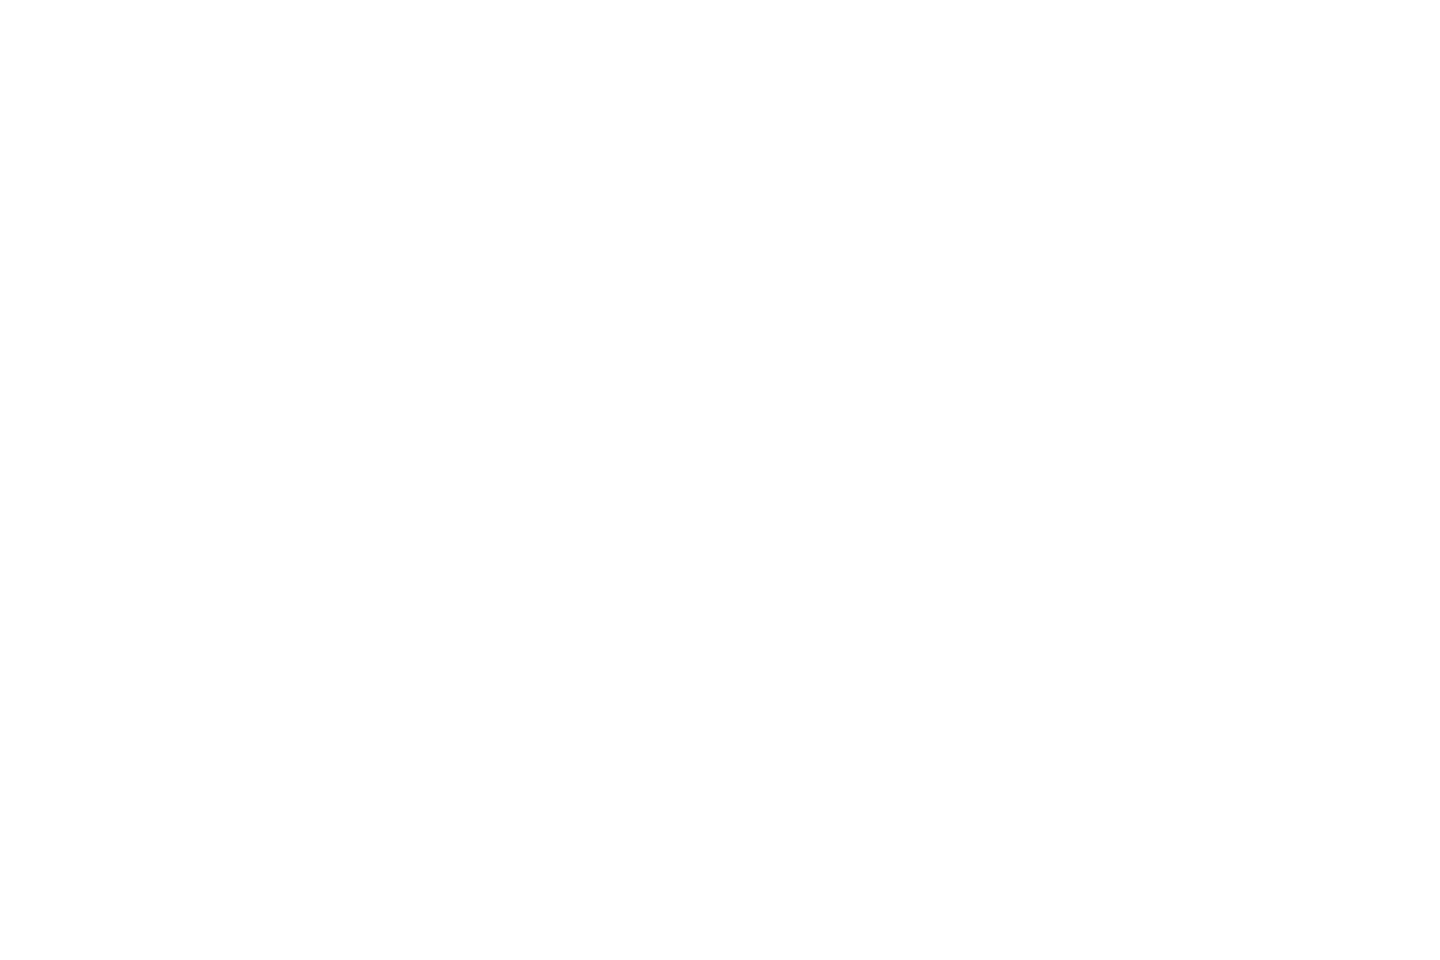

<IPython.core.display.Javascript object>


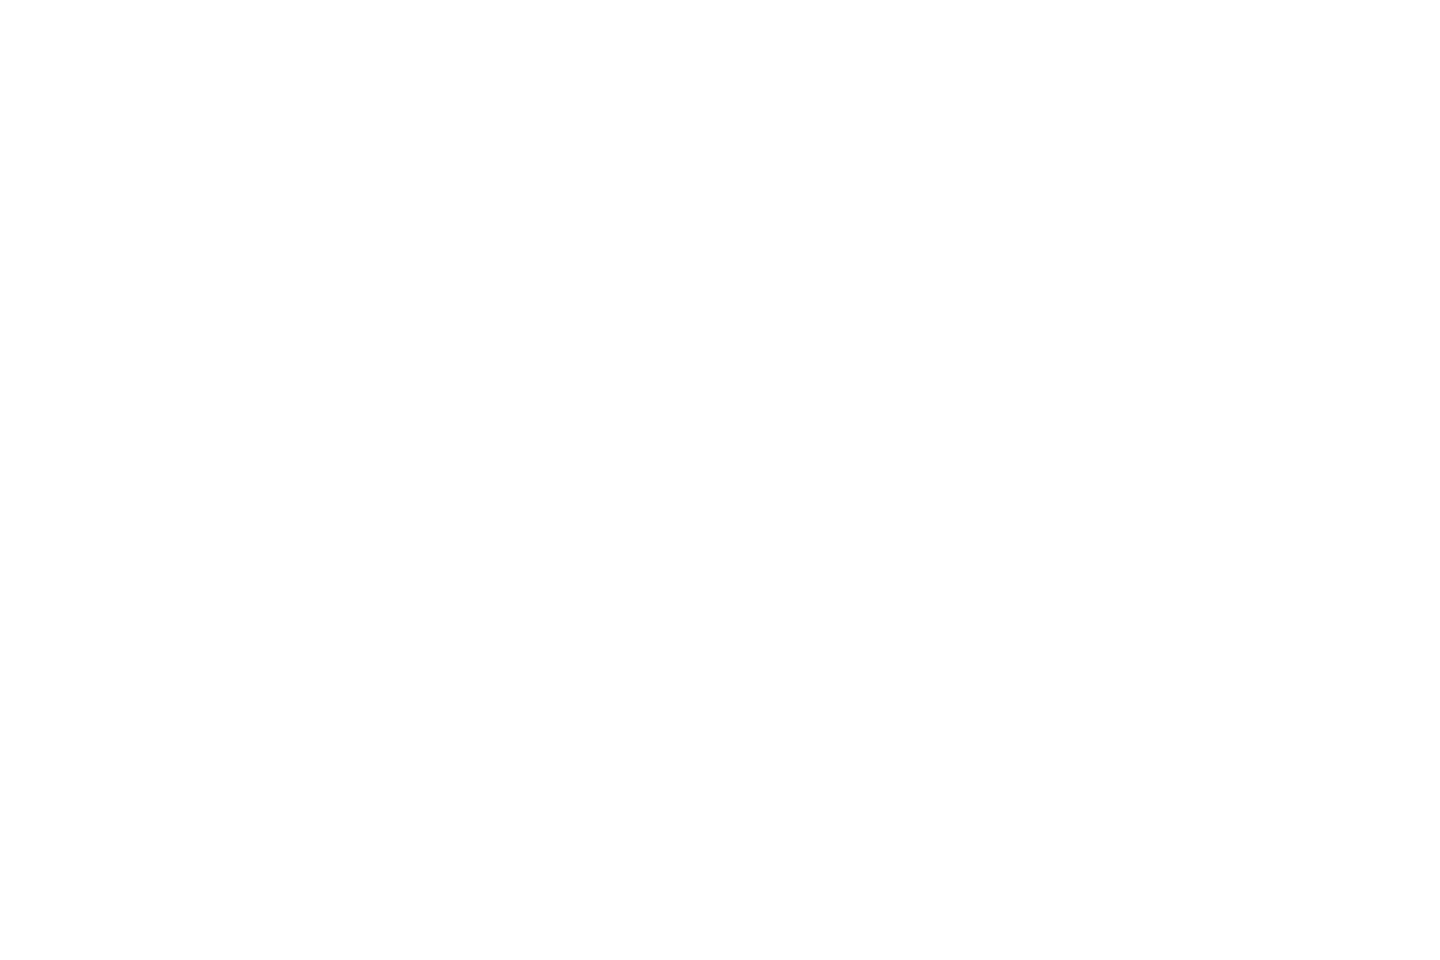

<IPython.core.display.Javascript object>


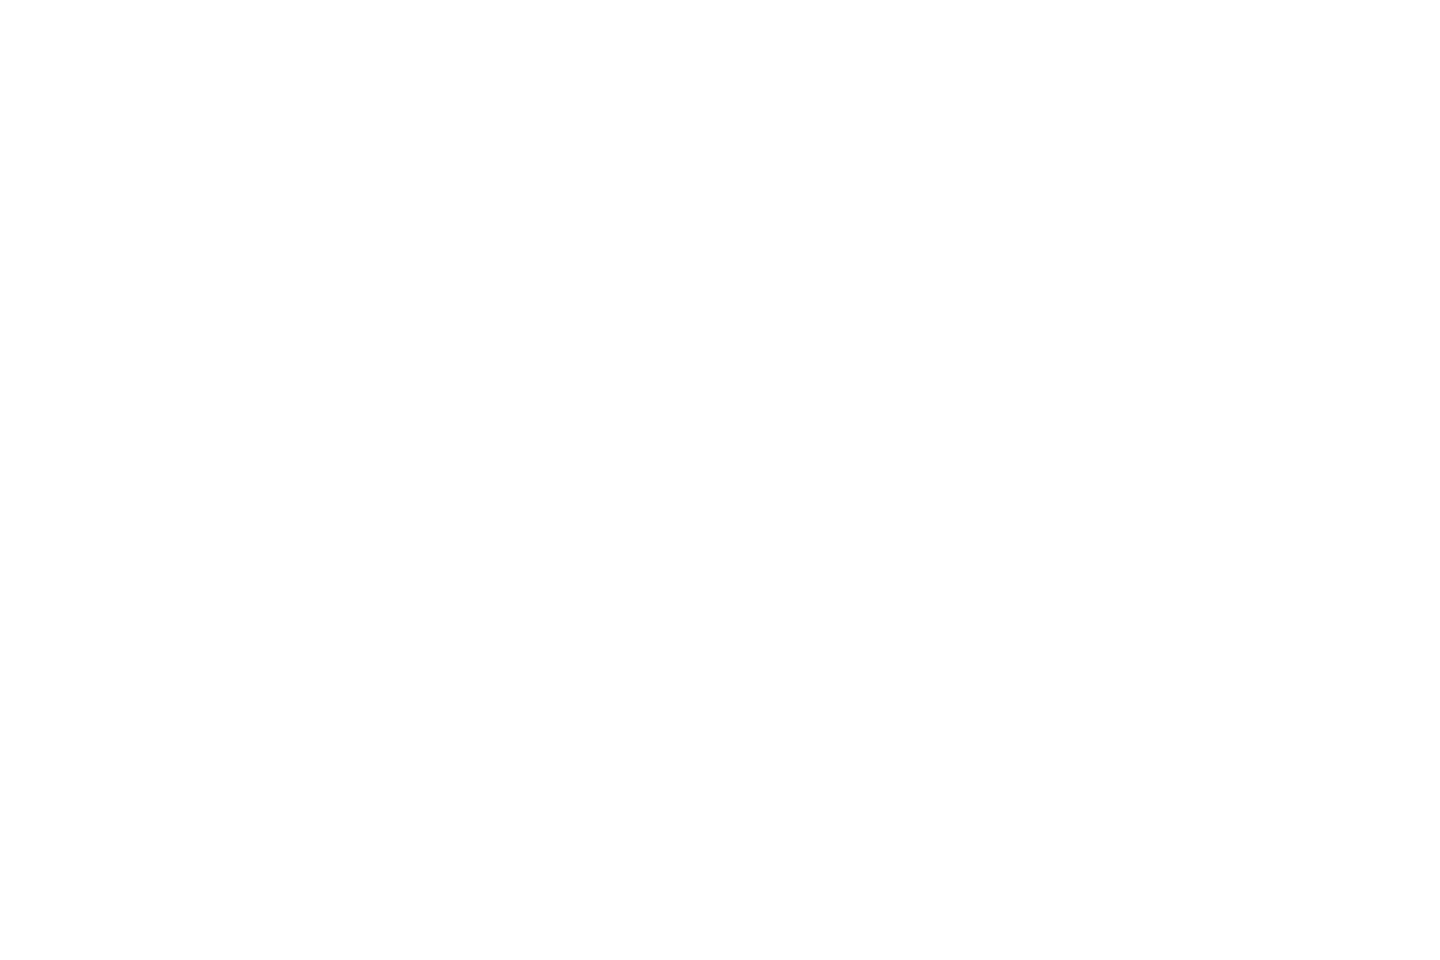

<IPython.core.display.Javascript object>


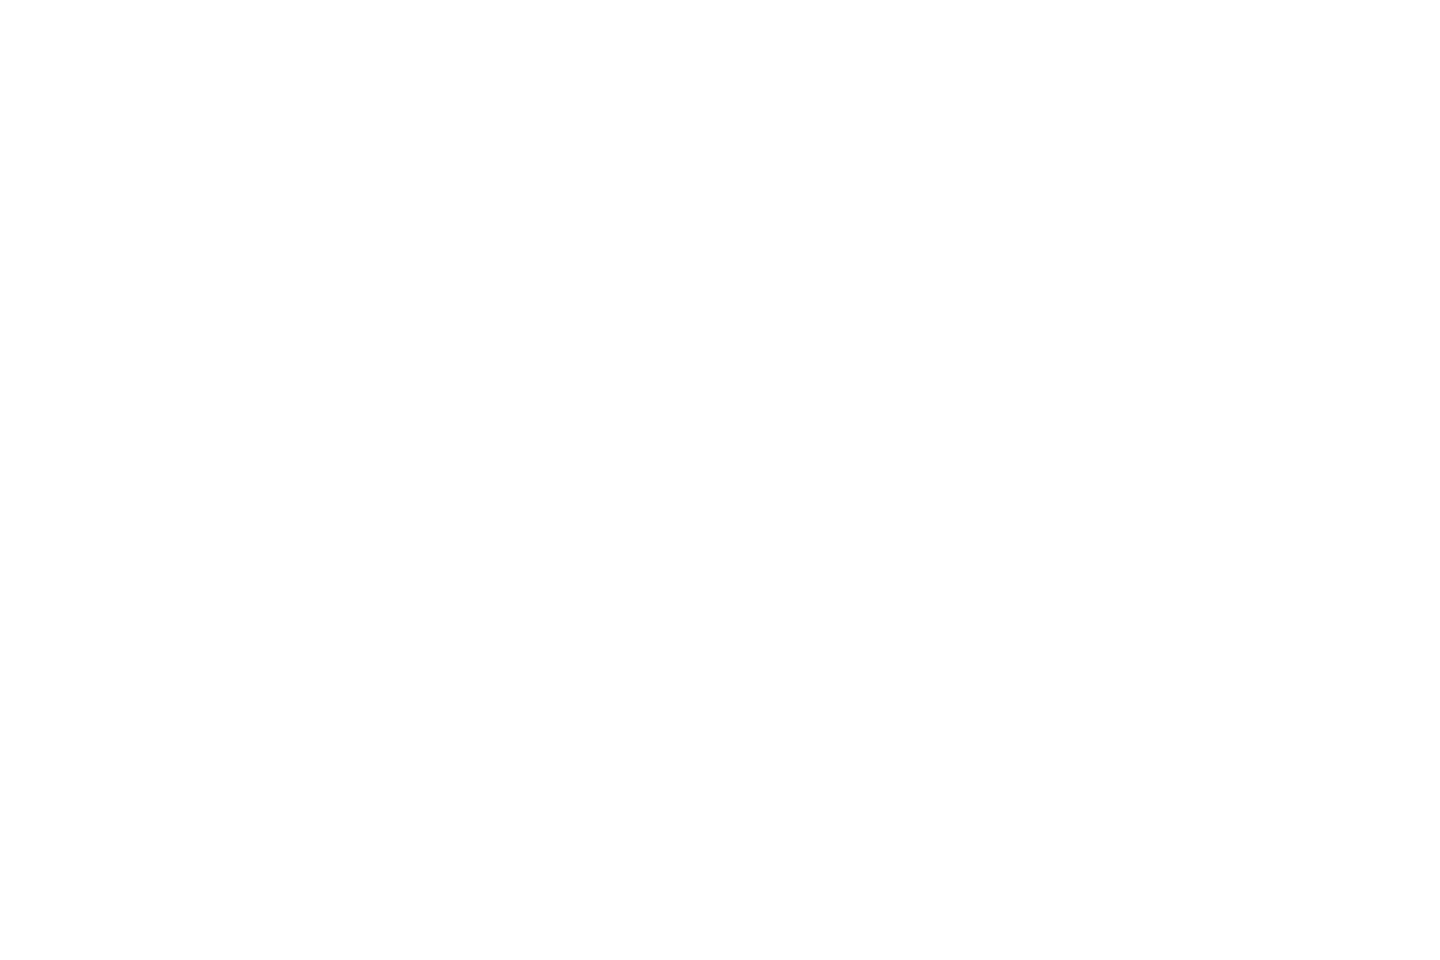

<IPython.core.display.Javascript object>


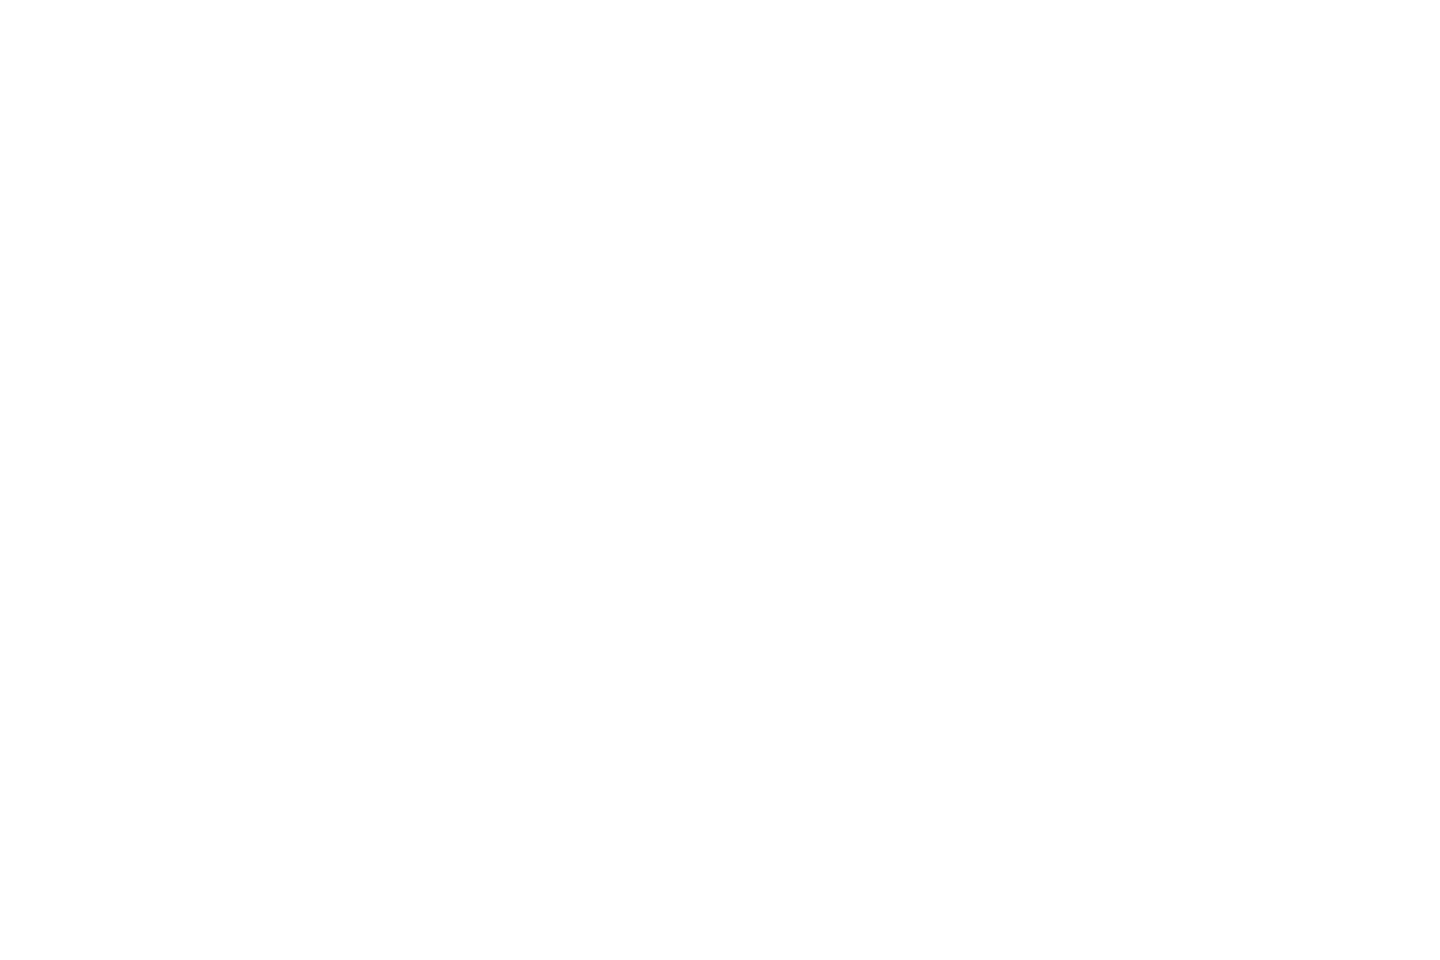

<IPython.core.display.Javascript object>


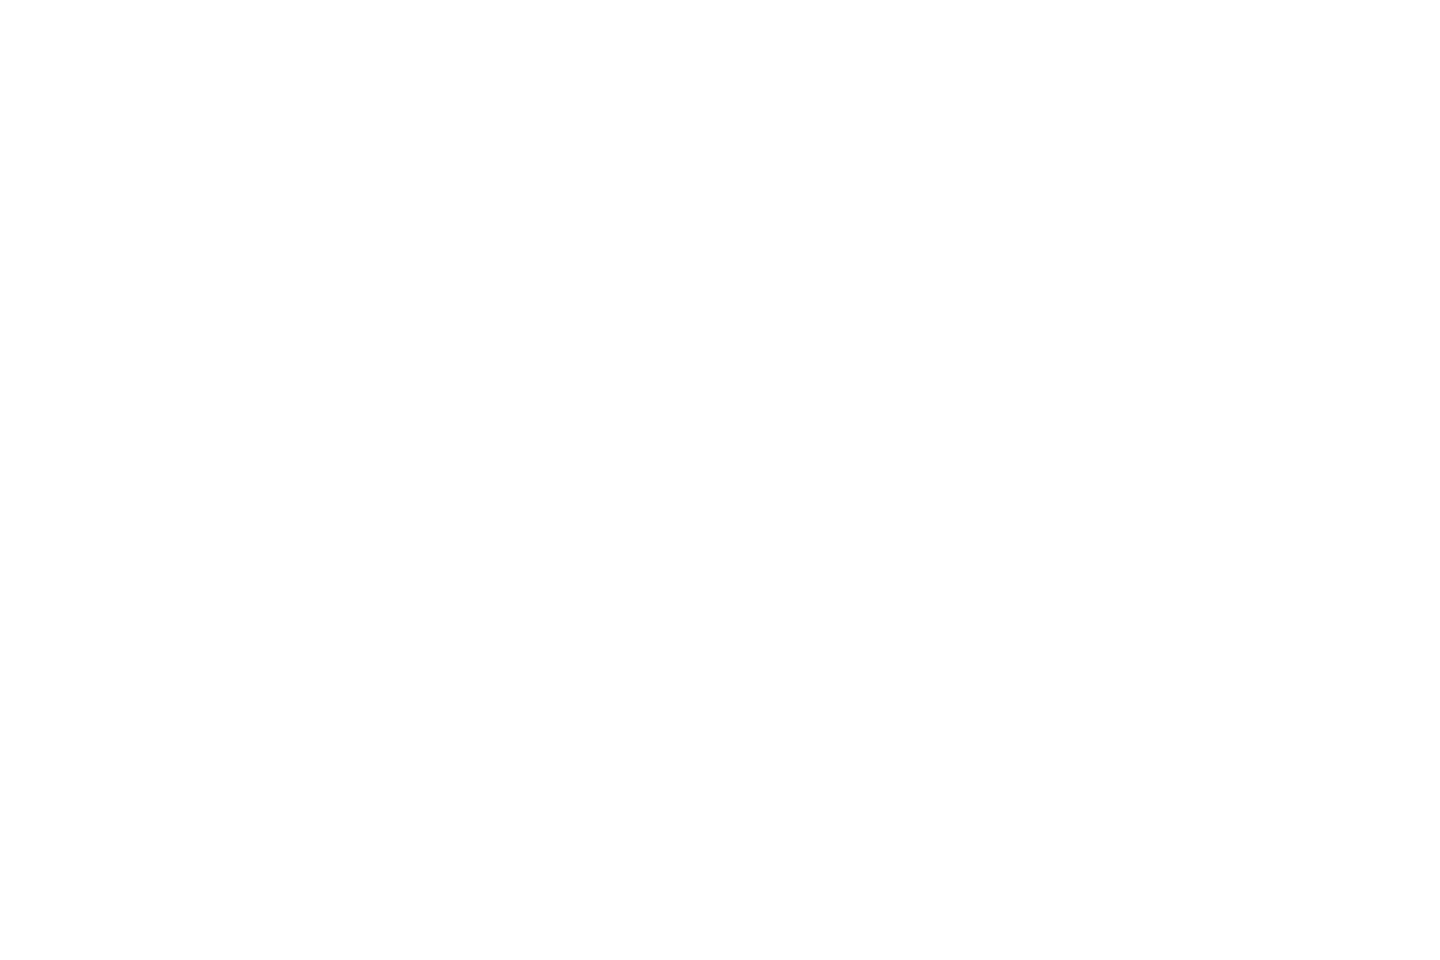

In [190]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    